In [3]:
#  Dependencies
import requests
from elasticsearch import Elasticsearch,helpers
import elasticsearch_dsl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import uuid
import random
import json

% matplotlib inline

In [4]:
# host_name = 'https://es-atlas.cern.ch/kibana'
# es-py __version__ is 2.3.0
# es_dsl __version__ is 5.3.0
# initialise elastic search with authorisation

es = Elasticsearch(['es-atlas.cern.ch:9203'],
                                 timeout=10000,
                                 use_ssl=True,
                                 verify_certs=True,
                                 ca_certs='/etc/pki/tls/certs/CERN-bundle.pem',
                                 http_auth='roatlas:la2Dbd5rtn3df!sx')

In [5]:
def get_indices(es):
    indices = es.indices.get_aliases().keys()
    # len(indices)
    rucio= (index for index in indices if('atlas_rucio-events' in index))
    events = []
    for event in rucio :
        events.append(event)
    print('total event indices:',len(events),'\n')
    #print(events)
    indices_dict = {}
    for event in events:
        i = es.count(index=event)
        indices_dict[event] = i['count']
    # print('total data points:',sum(int(list(indices_dict.values()))))
    print(indices_dict)
    return indices, indices_dict
    

# saves data to a dataframe
def extract_data(index, query, scan_size, scan_step):
    resp = es.search(
    index = index,
    scroll = '20m',
    body = query,
    size = scan_step)

    sid = resp['_scroll_id']
    scroll_size = resp['hits']['total']
    print('total hits in {} : {}'.format(index,scroll_size))
    results=[]
    for hit in resp['hits']['hits']:
        results.append(hit['_source']['payload'])
    #plot_data_stats(results)
    steps = int((scan_size-scan_step)/ scan_step)

    # Start scrolling

    for i in range(steps):
        if i%10==0:
            print("Scrolling index : {} ; step : {} ...\n ".format(index,i))
        resp = es.scroll(scroll_id = sid, scroll = '20m')
        # Update the scroll ID
        sid = resp['_scroll_id']
        # Get the number of results that we returned in the last scroll
        scroll_size = len(resp['hits']['hits'])
        if i%10==0:
            print("scroll size: " + str(scroll_size))
        for hit in resp['hits']['hits']:
            results.append(hit['_source']['payload'])
    
    print("\n Done Scrolling through {} !! \n".format(index))
    results = pd.DataFrame(results)
    print(results.info(), '\n')
    return results

def get_indices_data(indices_list, query, scan_step, scan_size=None, indices_dict=None):
    
    hdf = pd.HDFStore('raw_datastore.h5')
#     data = pd.DataFrame()

    for index in indices_list:
        if scan_size == None:
            scan_size = indices_dict[index]
        tmp_data = extract_data(index, query, scan_size, scan_step)
        plot_data_stats(tmp_data)
        file_name = (index+'.csv')
#         hdf.put(index, tmp_data, format='table', data_columns=True)
        tmp_data.to_csv(file_name)
        print('Saved {} data to disk !!'.format(index))
#         data = data.append(tmp_data, ignore_index=True)
#     print(data.info())
#     plot_data_stats(data)
    print("\n------------------- ALL DONE !!!!! -----------------------")
    return None
#     return data


def plot_data_stats(rucio_data):
    sns.set_context('poster')
    
    ax = sns.countplot(x='activity',data= rucio_data)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    plt.show()
    gx= sns.countplot(x='transfer-endpoint', data = rucio_data)
    gx.set_xticklabels(gx.get_xticklabels(), rotation=30)
    plt.show()
    vx = sns.countplot(x='protocol', data = rucio_data)
    plt.show()
    bx= sns.countplot(x='src-type', data=rucio_data)
    plt.show()
    cx= sns.countplot(x='dst-type', data=rucio_data)
    plt.show()
    
def preprocess_data(rucio_data):
    
    fields_to_drop = ['account','reason','checksum-adler','checksum-md5','guid','request-id','transfer-id','tool-id',
                      'transfer-link','name','previous-request-id','src-url','dst-url', 'Unnamed: 0']
    timestamps = ['started_at', 'submitted_at','transferred_at']

    #DROP FIELDS , CHANGE TIME FORMAT
    rucio_data = rucio_data.drop(fields_to_drop, axis=1)
    for timestamp in timestamps:
        rucio_data[timestamp]= pd.to_datetime(rucio_data[timestamp], infer_datetime_format=True)
    rucio_data['delay'] = rucio_data['started_at'] - rucio_data['submitted_at']
    rucio_data['delay'] = rucio_data['delay'].astype('timedelta64[s]')
    
    rucio_data = rucio_data.sort_values(by='submitted_at')

    rucio_data = rucio_data.drop(timestamps, axis=1)
    
    src_encoder = LabelEncoder()
    dst_encoder = LabelEncoder()
    scope_encoder = LabelEncoder()
    type_encoder = LabelEncoder()
    activity_encoder = LabelEncoder()
    protocol_encoder = LabelEncoder()
    t_endpoint_encoder = LabelEncoder()

    src_encoder.fit(rucio_data['src-rse'].unique())
    dst_encoder.fit(rucio_data['dst-rse'].unique())
    scope_encoder.fit(rucio_data['scope'].unique())
    type_encoder.fit(rucio_data['src-type'].unique())
    activity_encoder.fit(rucio_data['activity'].unique())
    protocol_encoder.fit(rucio_data['protocol'].unique())
    t_endpoint_encoder.fit(rucio_data['transfer-endpoint'].unique())

    rucio_data['src-rse'] = src_encoder.transform(rucio_data['src-rse'])
    rucio_data['dst-rse'] = dst_encoder.transform(rucio_data['dst-rse'])
    rucio_data['scope'] = scope_encoder.transform(rucio_data['scope'])
    rucio_data['src-type'] = type_encoder.transform(rucio_data['src-type'])
    rucio_data['dst-type'] = type_encoder.transform(rucio_data['dst-type'])
    rucio_data['activity'] = activity_encoder.transform(rucio_data['activity'])
    rucio_data['protocol'] = protocol_encoder.transform(rucio_data['protocol'])
    rucio_data['transfer-endpoint'] = t_endpoint_encoder.transform(rucio_data['transfer-endpoint'])
    
    return rucio_data


In [6]:
print(es.ping())
es.info()

True


{'cluster_name': 'atlas',
 'cluster_uuid': 'jGbidQR5T7Ok-8EoeXoFRA',
 'name': 'esatlass02-ites_atlas',
 'tagline': 'You Know, for Search',
 'version': {'build_date': '2017-02-09T22:05:32.386Z',
  'build_hash': 'db0d481',
  'build_snapshot': False,
  'lucene_version': '6.4.1',
  'number': '5.2.1'}}

In [7]:
es.cluster.health()

{'active_primary_shards': 2114,
 'active_shards': 4359,
 'active_shards_percent_as_number': 100.0,
 'cluster_name': 'atlas',
 'delayed_unassigned_shards': 0,
 'initializing_shards': 0,
 'number_of_data_nodes': 9,
 'number_of_in_flight_fetch': 0,
 'number_of_nodes': 14,
 'number_of_pending_tasks': 0,
 'relocating_shards': 0,
 'status': 'green',
 'task_max_waiting_in_queue_millis': 0,
 'timed_out': False,
 'unassigned_shards': 0}

In [8]:
indices, indices_to_count = get_indices(es)

total event indices: 32 

{'atlas_rucio-events-2017.05.27': 8940869, 'atlas_rucio-events-2017.06.10': 8682198, 'atlas_rucio-events-2017.06.14': 8821194, 'atlas_rucio-events-2017.06.15': 10905390, 'atlas_rucio-events-2017.05.26': 13379263, 'atlas_rucio-events-2017.06.17': 8502957, 'atlas_rucio-events-2017.06.02': 16490541, 'atlas_rucio-events-2017.06.18': 11822060, 'atlas_rucio-events-2017.06.01': 13624672, 'atlas_rucio-events-2017.05.25': 13829032, 'atlas_rucio-events-test': 36, 'atlas_rucio-events-2017.06.04': 9845288, 'atlas_rucio-events-2016-06-30': 36737, 'atlas_rucio-events-2017.06.07': 8533532, 'atlas_rucio-events-2017.06.20': 15475815, 'atlas_rucio-events-2017.06.21': 16075112, 'atlas_rucio-events-2017.06.03': 12449162, 'atlas_rucio-events-2017.05.29': 7871022, 'atlas_rucio-events-2017.06.11': 6900458, 'atlas_rucio-events-2017.06.09': 11647283, 'atlas_rucio-events-2017.06.12': 13273519, 'atlas_rucio-events-2017.06.13': 10110855, 'atlas_rucio-events-2017.06.16': 11092802, 'atlas_

# Total Data Points in the atlas_rucio-events-* index

In [9]:
import time
count=es.count(index='atlas_rucio-events-*')
print('total documents at- {} : {}'.format(time.strftime("%c"), count['count']) )

total documents at- Thu Jun 22 18:27:50 2017 : 338766397


In [10]:
indices_to_count['atlas_rucio-events-2017.05.25']

13829032

In [11]:
stats = es.field_stats(index='atlas_rucio-events-2016-06-30', fields=['payload.created_at'])
#atlas_rucio-events-2016-06-30
print(stats)

{'_shards': {'failed': 0, 'successful': 5, 'total': 5}, 'indices': {'_all': {'fields': {'payload.created_at': {'searchable': True, 'aggregatable': True, 'sum_doc_freq': 139636, 'max_doc': 36737, 'sum_total_term_freq': -1, 'type': 'date', 'max_value_as_string': '2016-06-30 13:53:42', 'min_value_as_string': '2016-06-30 13:17:36', 'density': 95, 'min_value': 1467292656000, 'max_value': 1467294822000, 'doc_count': 34909}}}}}


# Extracting Data from 2-3 Months

In [12]:
k = [index for index in indices if ('atlas_rucio-events-2017.05' in index)] #may-indices
l = [index for index in indices if ('atlas_rucio-events-2017.06' in index)] #june-indices
print(len(k), '\n', len(l))

8 
 22


total hits in atlas_rucio-events-2017.06.05 : 2197839
Scrolling index : atlas_rucio-events-2017.06.05 ; step : 0 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.05 ; step : 10 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.05 ; step : 20 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.05 ; step : 30 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.05 ; step : 40 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.05 ; step : 50 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.05 ; step : 60 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.05 ; step : 70 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.05 ; step : 80 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.05 ; step : 90 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.05 ; step : 100 ...
 
scroll size: 10000
Scrolling i

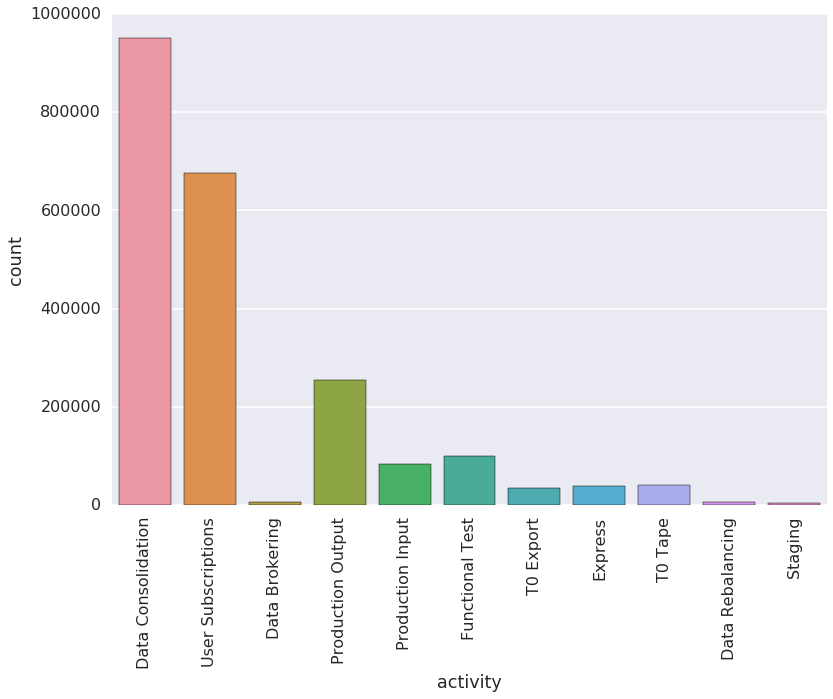

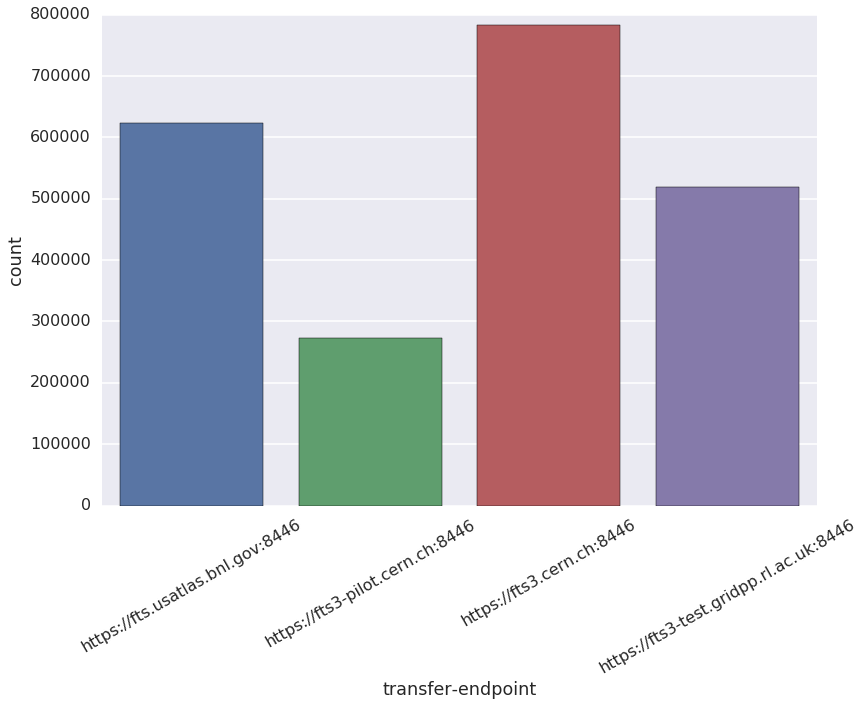

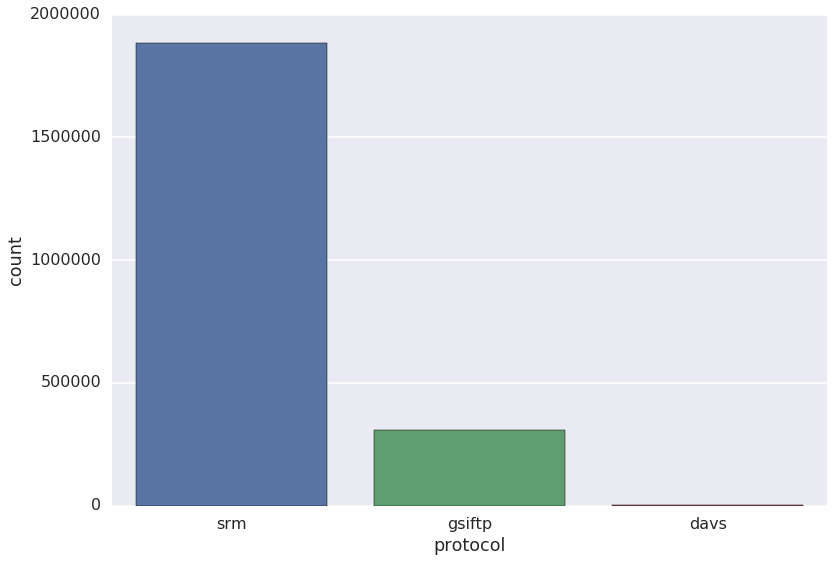

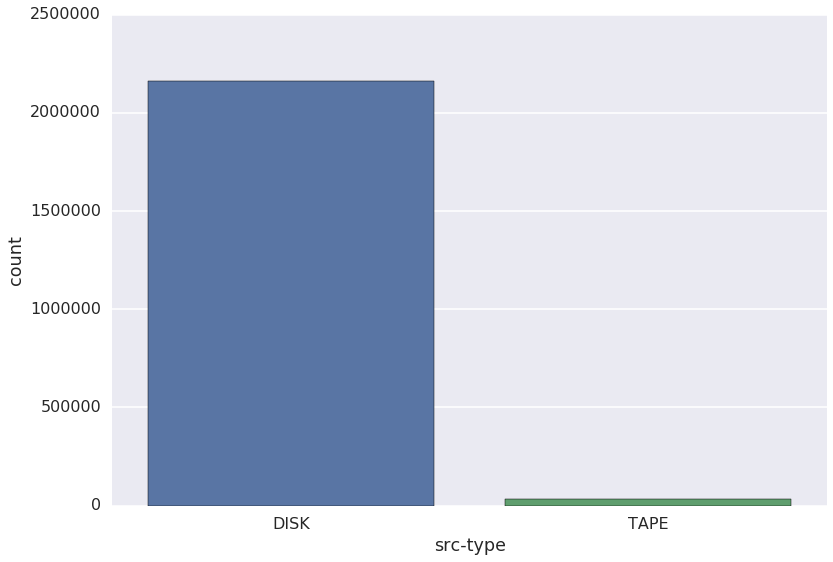

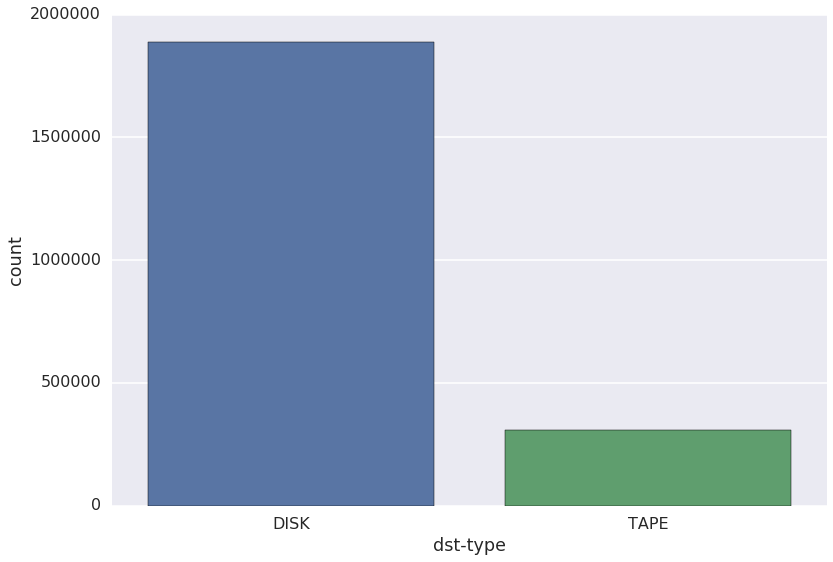

Saved atlas_rucio-events-2017.06.05 data to disk !!
total hits in atlas_rucio-events-2017.06.20 : 1793831
Scrolling index : atlas_rucio-events-2017.06.20 ; step : 0 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.20 ; step : 10 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.20 ; step : 20 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.20 ; step : 30 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.20 ; step : 40 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.20 ; step : 50 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.20 ; step : 60 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.20 ; step : 70 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.20 ; step : 80 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.20 ; step : 90 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.

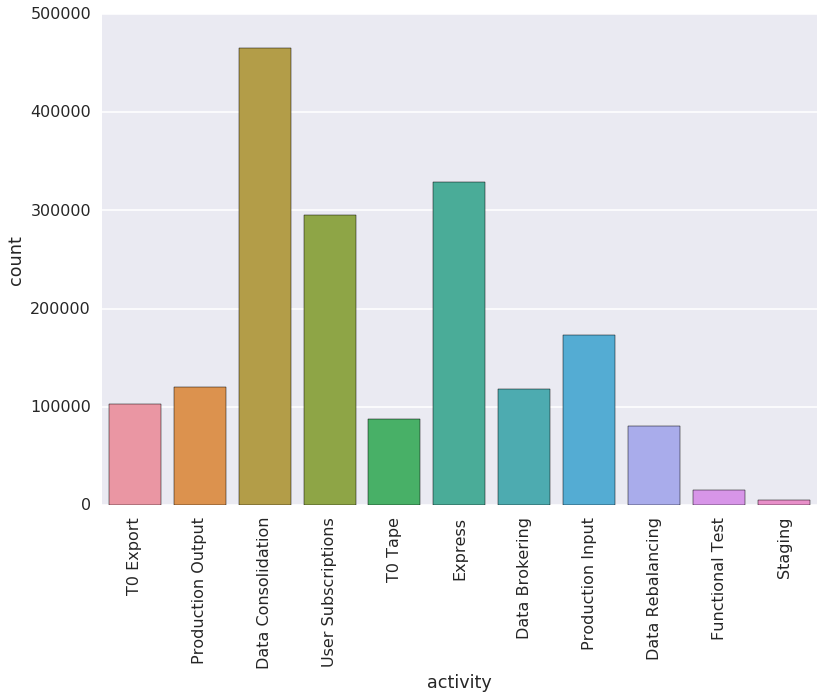

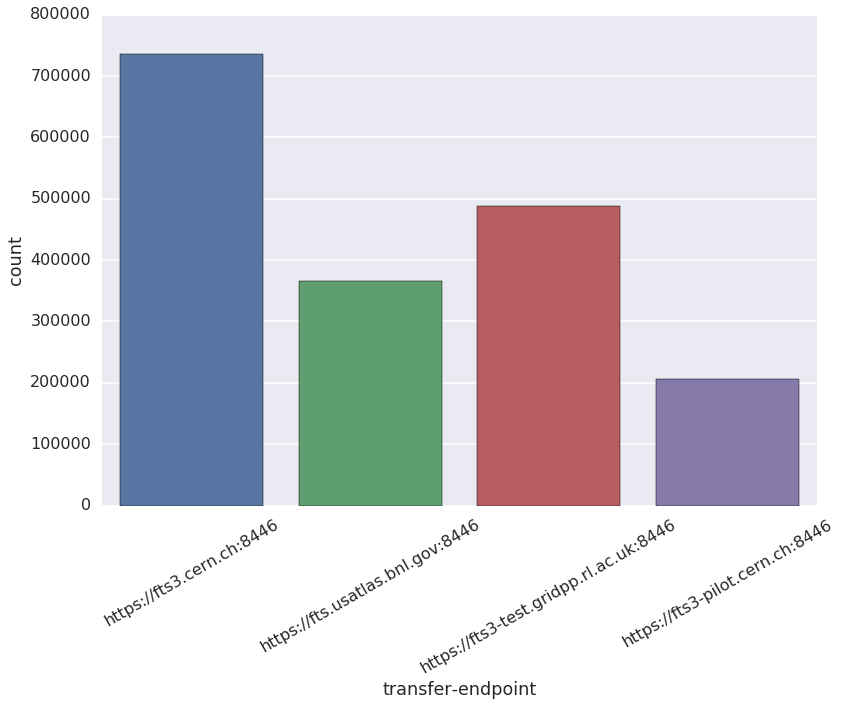

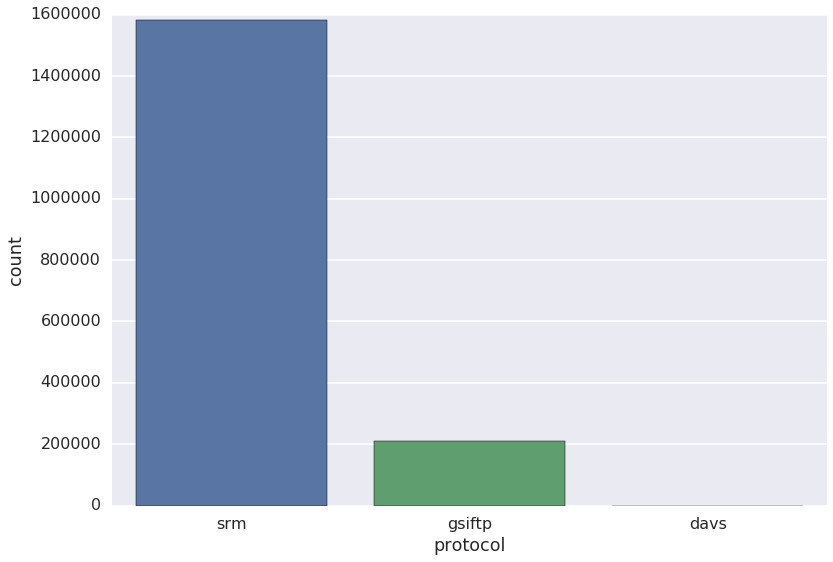

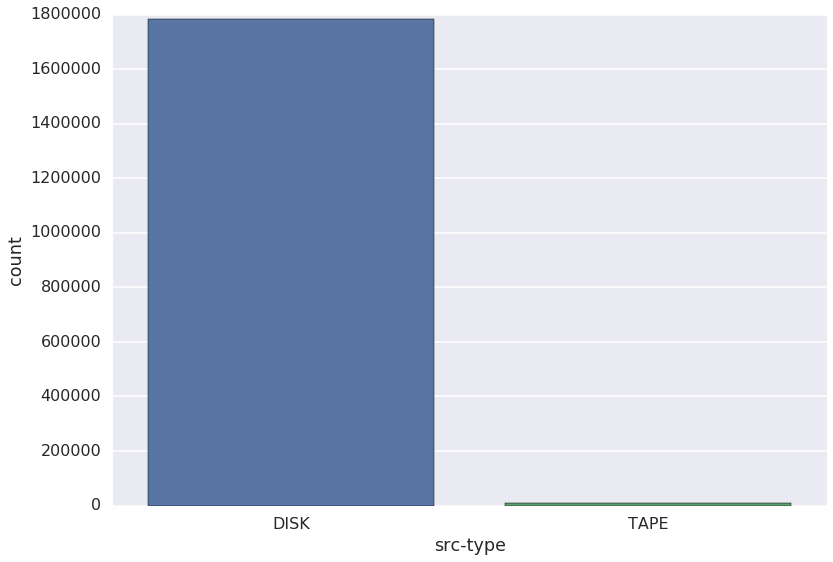

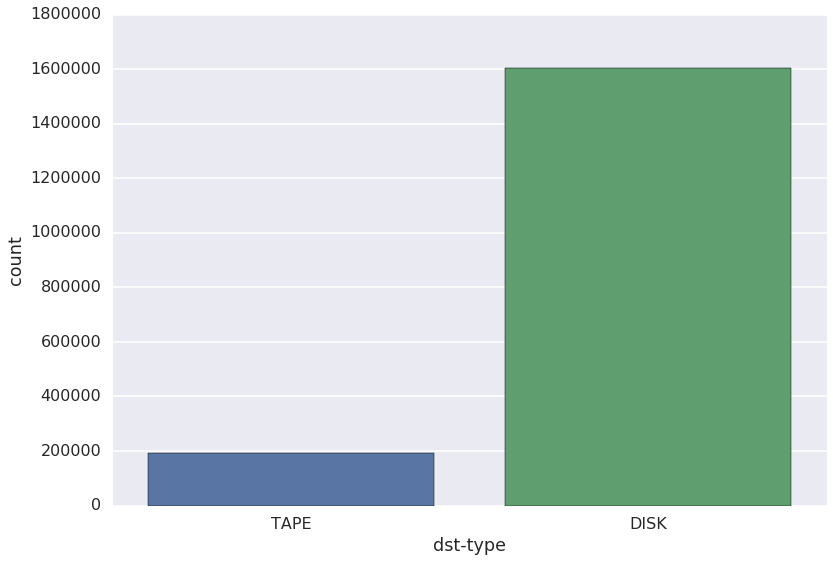

Saved atlas_rucio-events-2017.06.20 data to disk !!
total hits in atlas_rucio-events-2017.06.09 : 1983416
Scrolling index : atlas_rucio-events-2017.06.09 ; step : 0 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.09 ; step : 10 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.09 ; step : 20 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.09 ; step : 30 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.09 ; step : 40 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.09 ; step : 50 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.09 ; step : 60 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.09 ; step : 70 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.09 ; step : 80 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.09 ; step : 90 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.

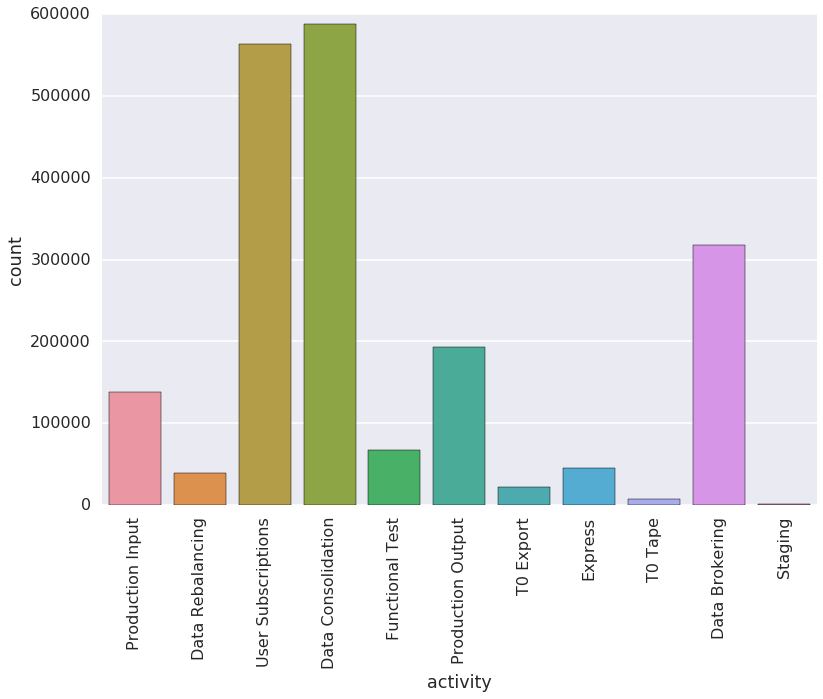

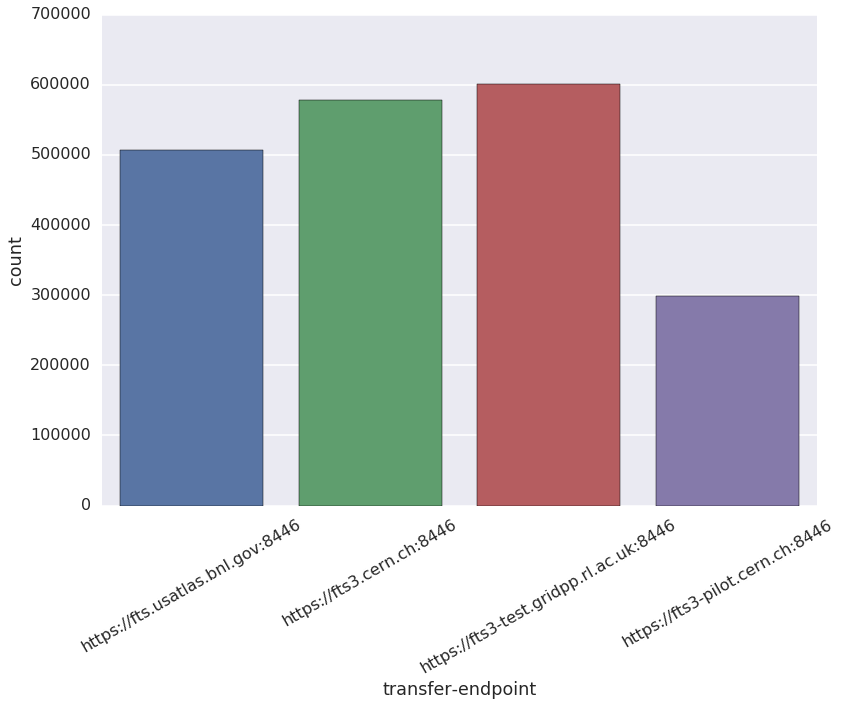

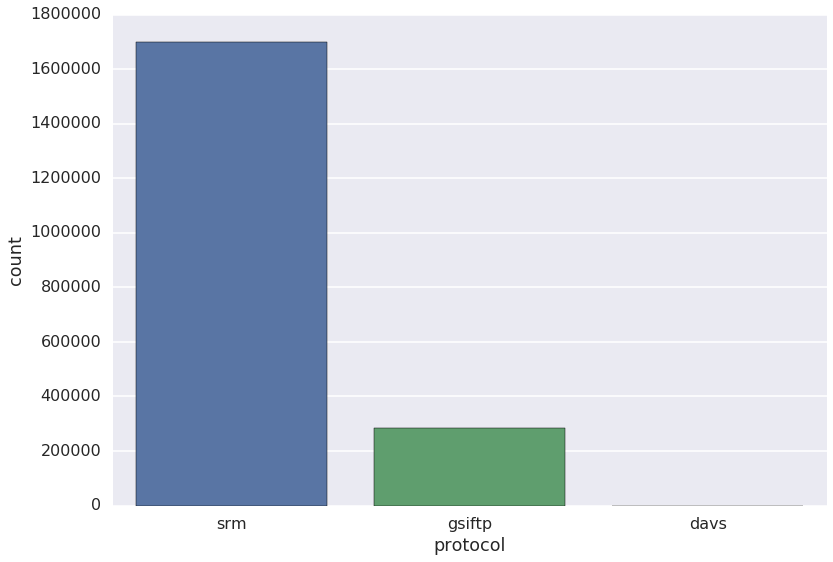

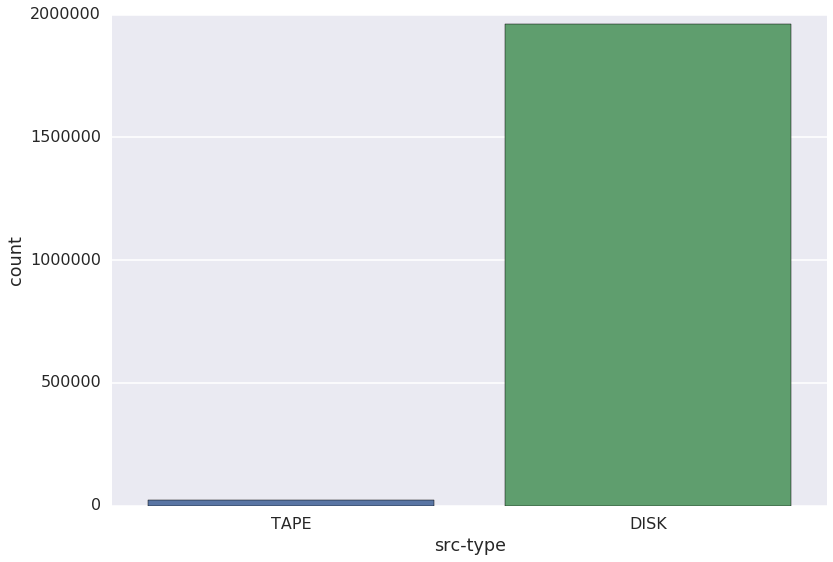

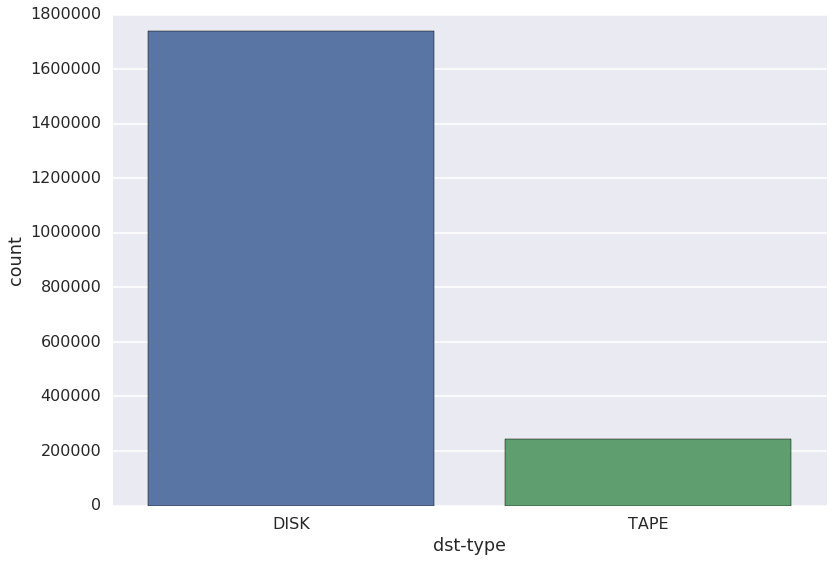

Saved atlas_rucio-events-2017.06.09 data to disk !!
total hits in atlas_rucio-events-2017.06.04 : 1378899
Scrolling index : atlas_rucio-events-2017.06.04 ; step : 0 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.04 ; step : 10 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.04 ; step : 20 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.04 ; step : 30 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.04 ; step : 40 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.04 ; step : 50 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.04 ; step : 60 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.04 ; step : 70 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.04 ; step : 80 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.04 ; step : 90 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.

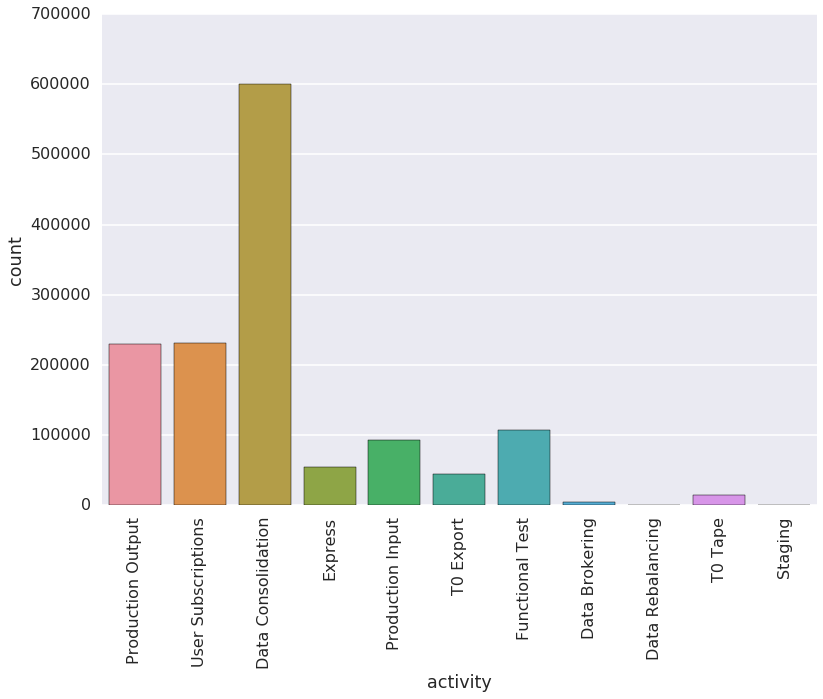

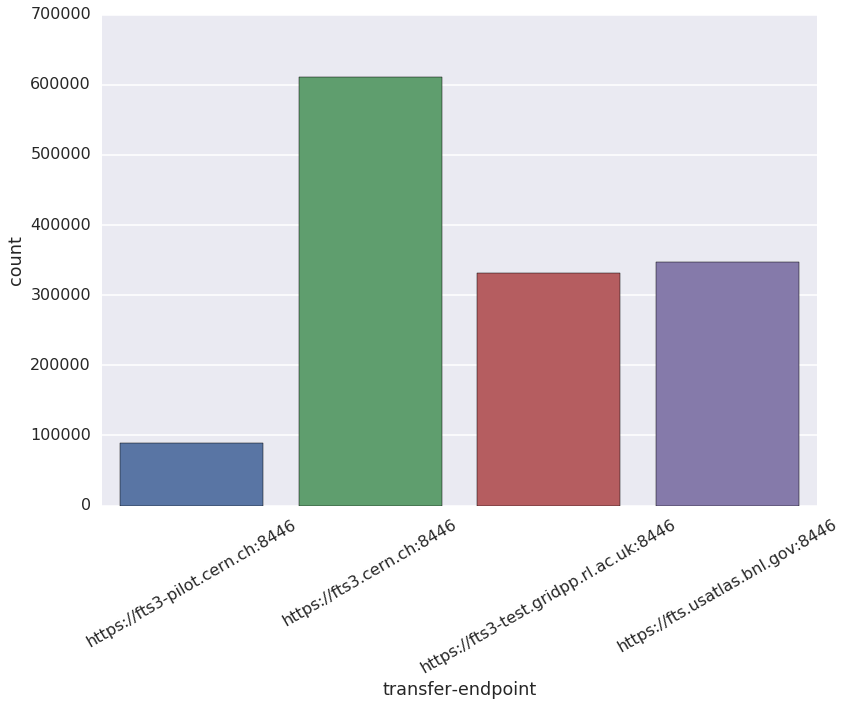

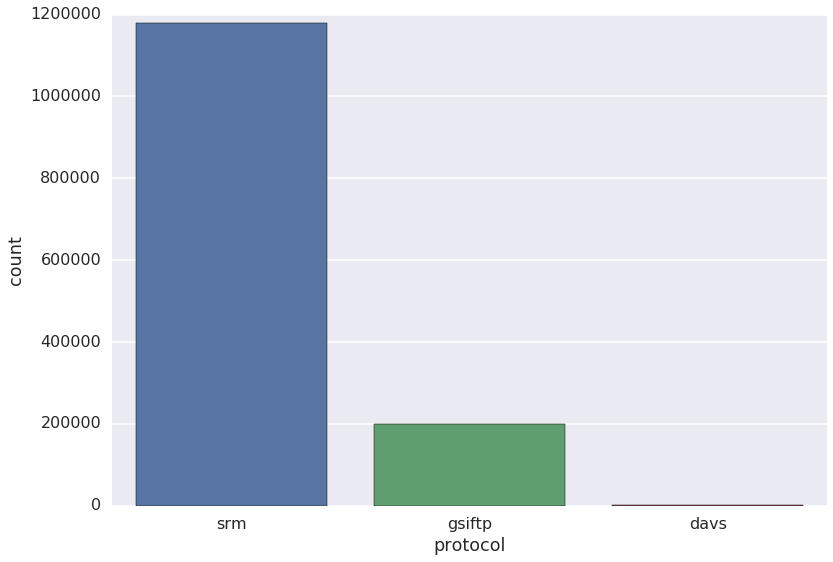

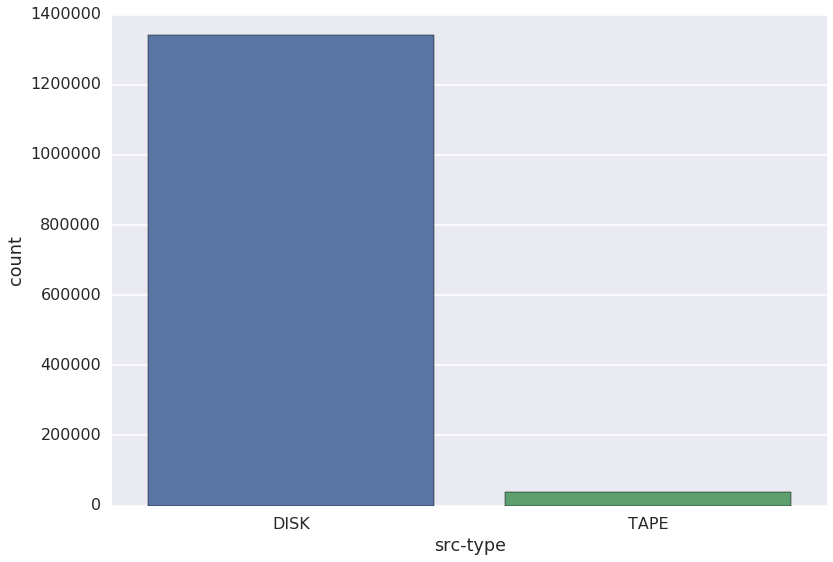

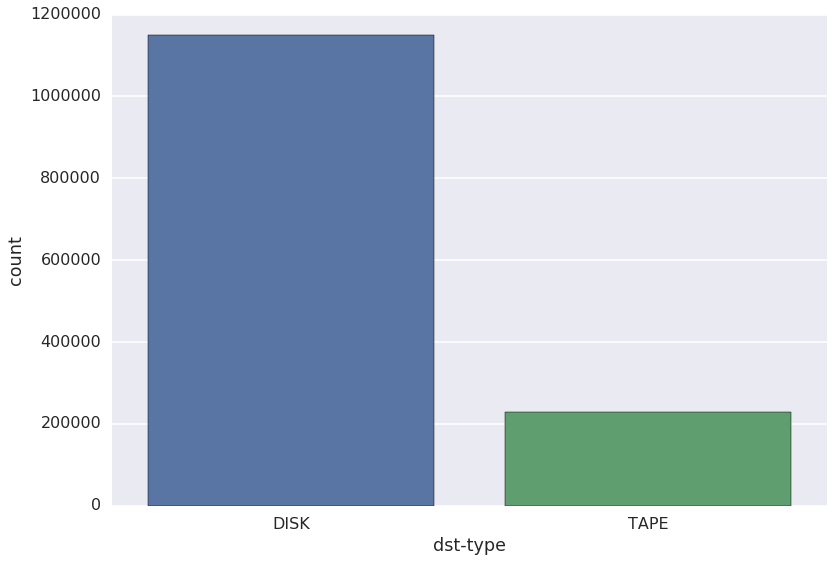

Saved atlas_rucio-events-2017.06.04 data to disk !!
total hits in atlas_rucio-events-2017.06.14 : 1576331
Scrolling index : atlas_rucio-events-2017.06.14 ; step : 0 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.14 ; step : 10 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.14 ; step : 20 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.14 ; step : 30 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.14 ; step : 40 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.14 ; step : 50 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.14 ; step : 60 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.14 ; step : 70 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.14 ; step : 80 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.14 ; step : 90 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.

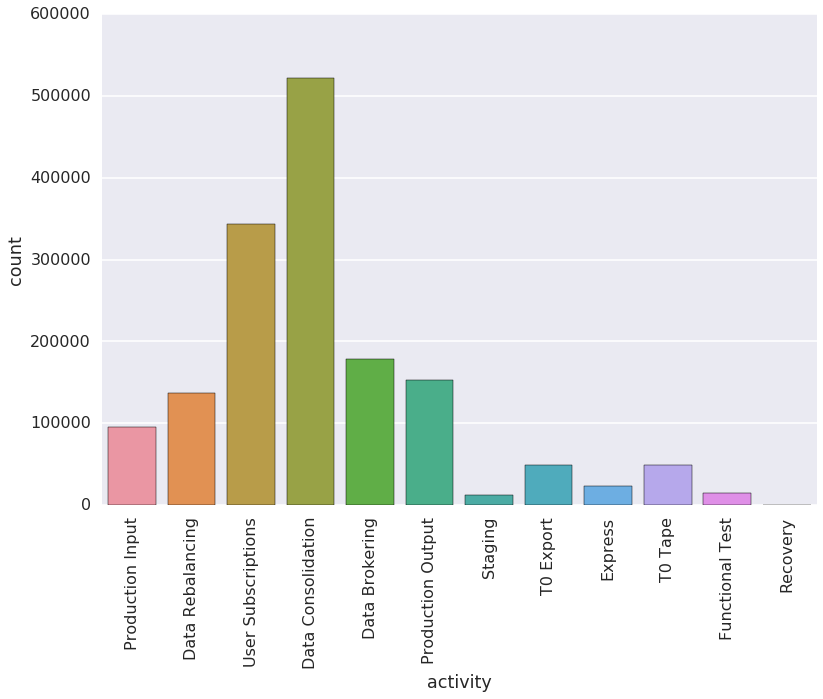

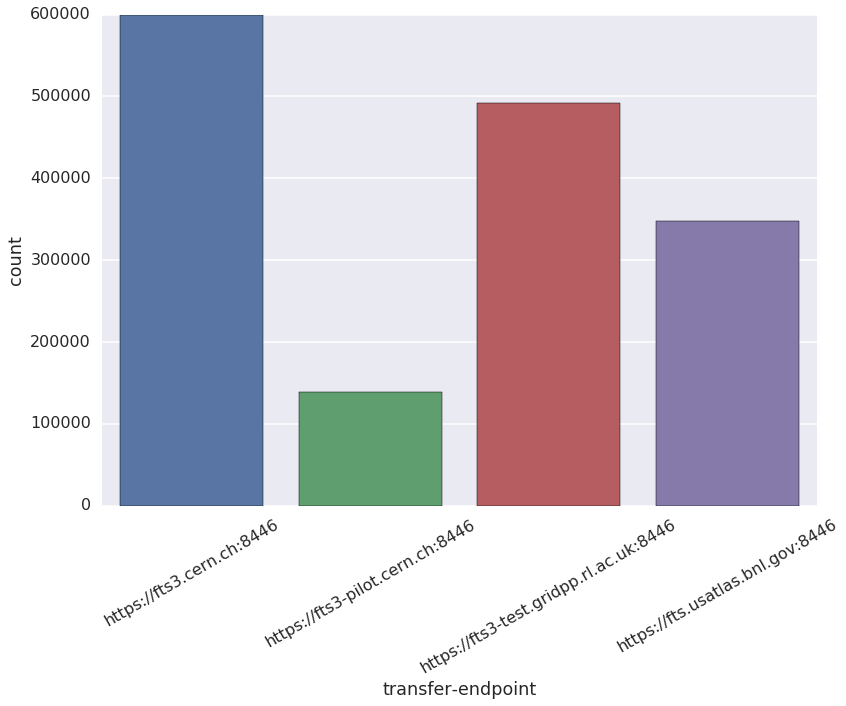

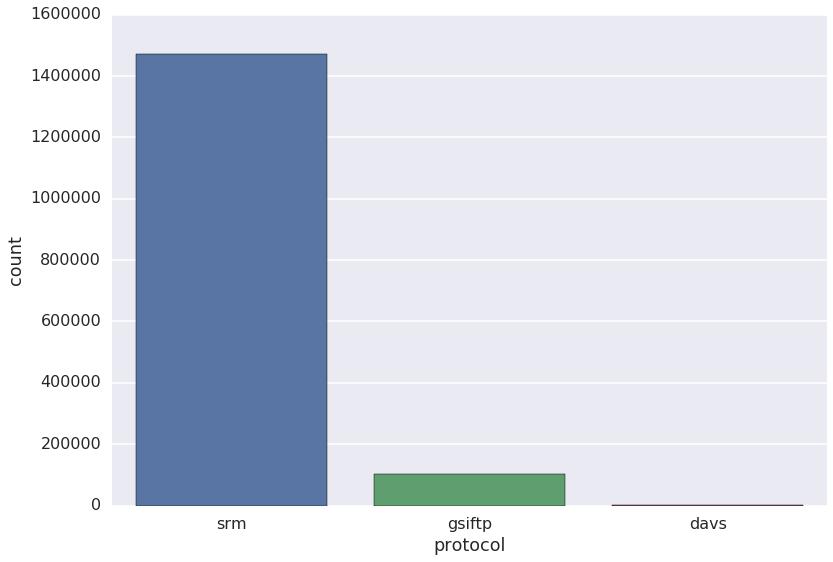

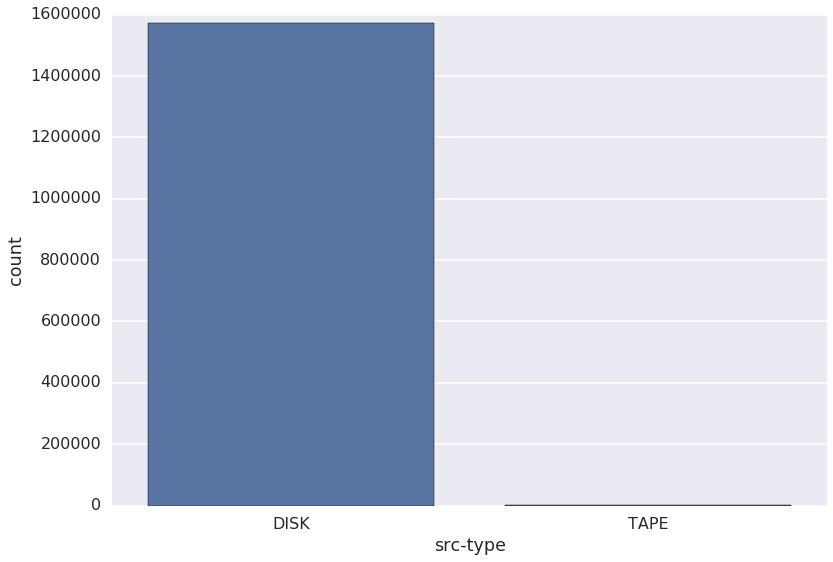

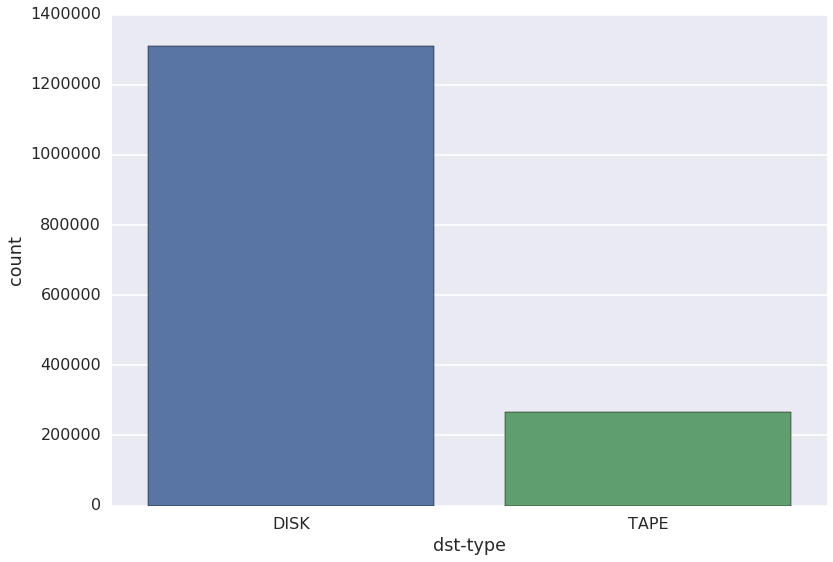

Saved atlas_rucio-events-2017.06.14 data to disk !!
total hits in atlas_rucio-events-2017.06.22 : 1367720
Scrolling index : atlas_rucio-events-2017.06.22 ; step : 0 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.22 ; step : 10 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.22 ; step : 20 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.22 ; step : 30 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.22 ; step : 40 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.22 ; step : 50 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.22 ; step : 60 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.22 ; step : 70 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.22 ; step : 80 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.22 ; step : 90 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.

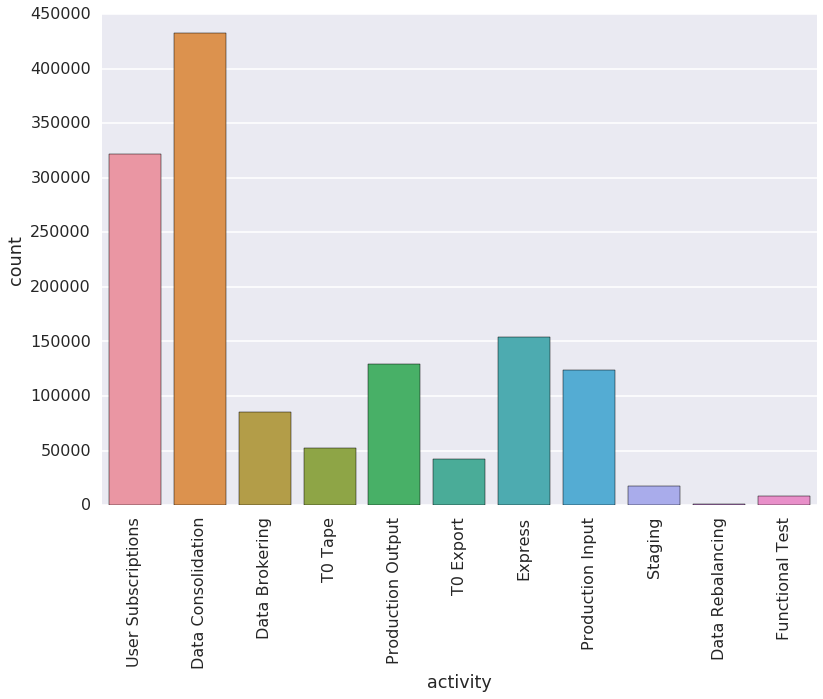

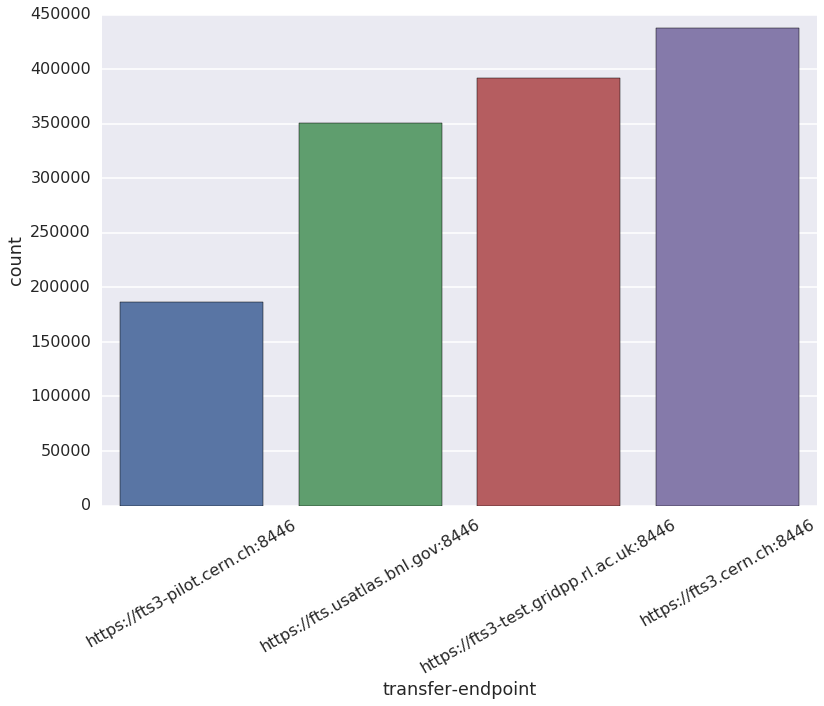

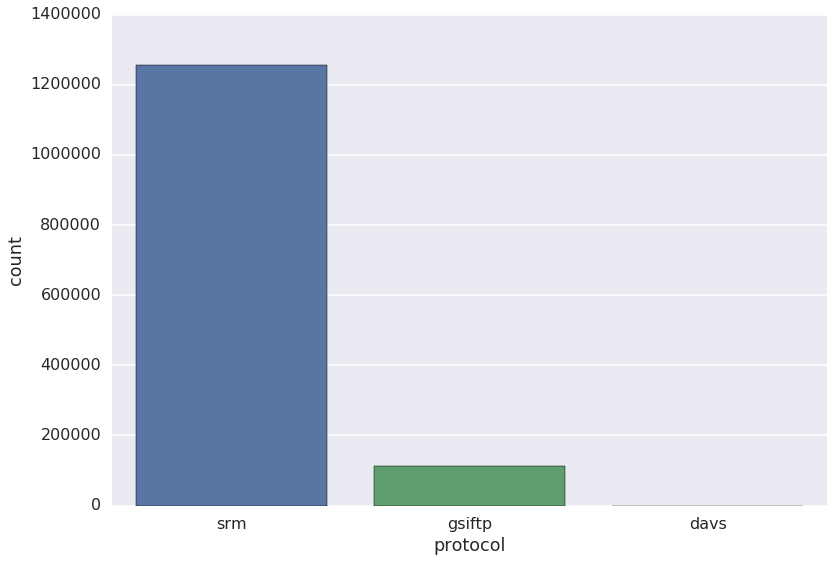

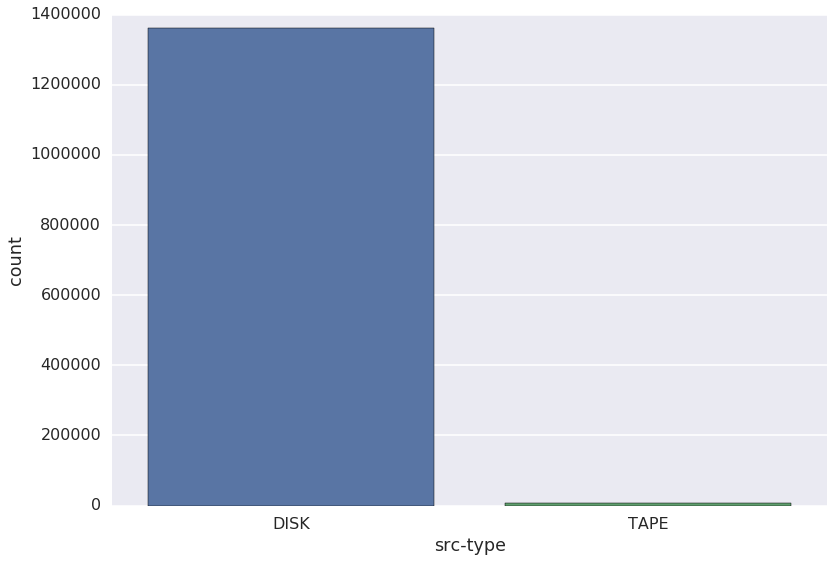

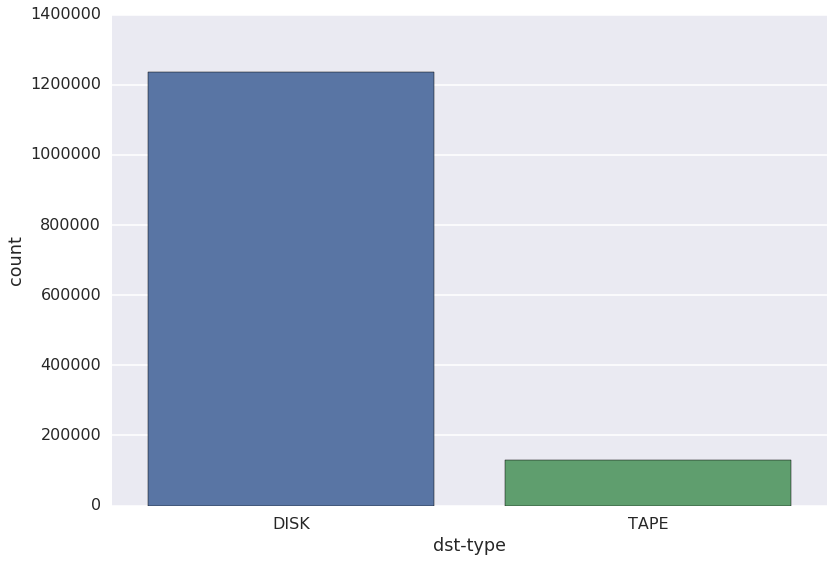

Saved atlas_rucio-events-2017.06.22 data to disk !!
total hits in atlas_rucio-events-2017.06.10 : 1353588
Scrolling index : atlas_rucio-events-2017.06.10 ; step : 0 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.10 ; step : 10 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.10 ; step : 20 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.10 ; step : 30 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.10 ; step : 40 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.10 ; step : 50 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.10 ; step : 60 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.10 ; step : 70 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.10 ; step : 80 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.10 ; step : 90 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.

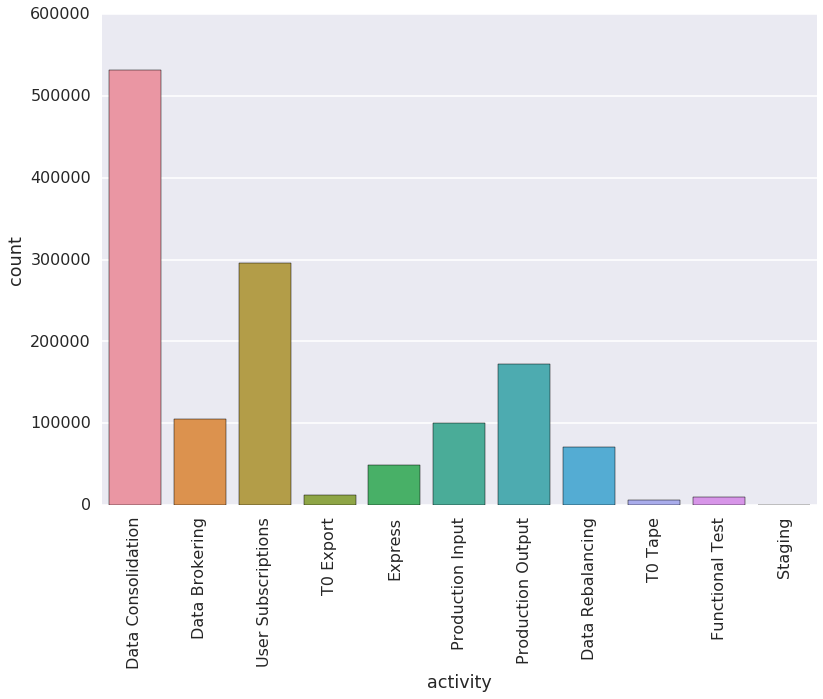

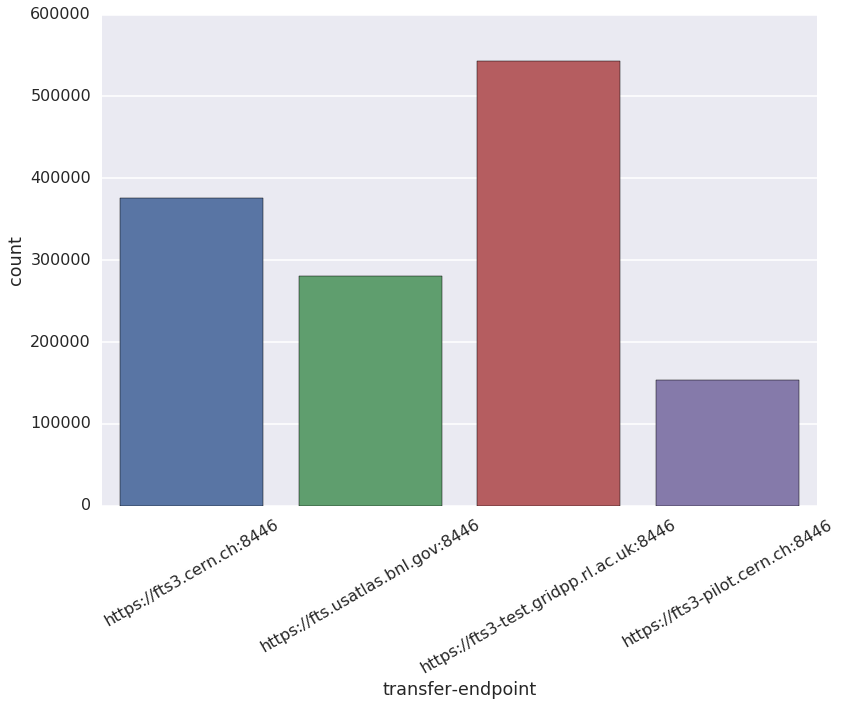

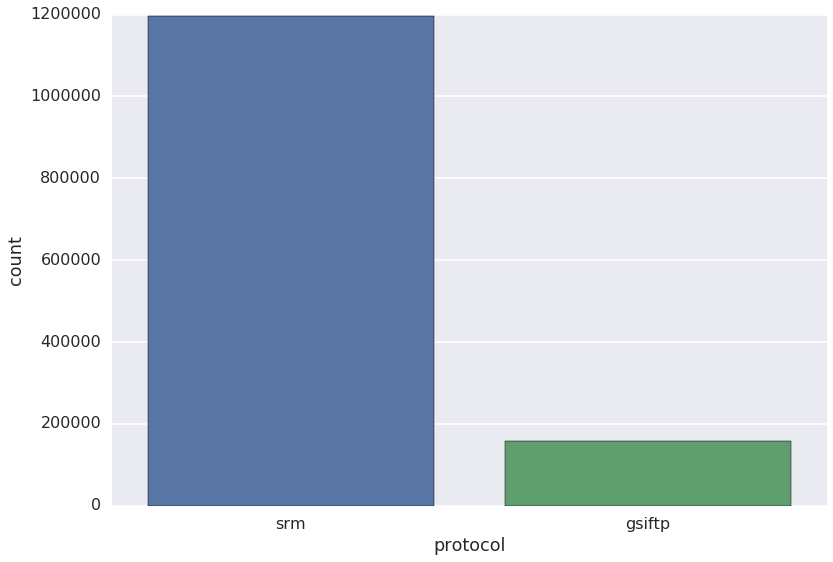

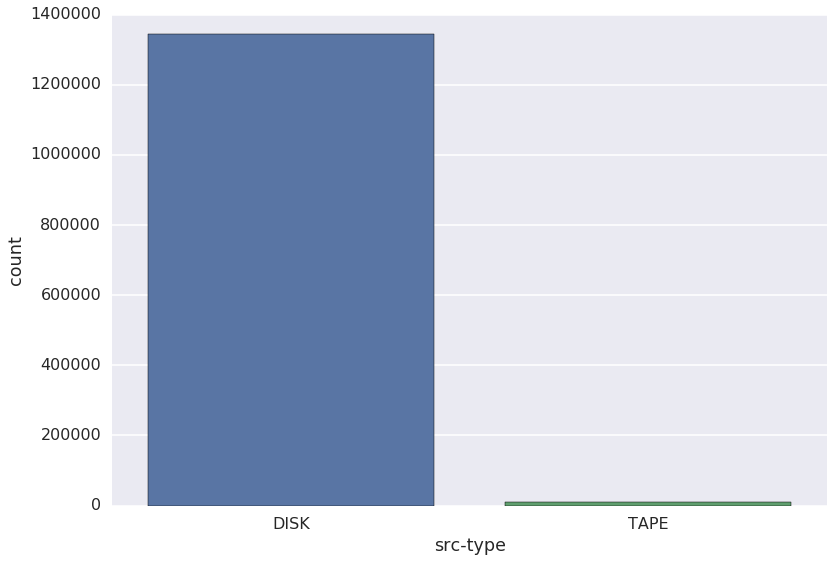

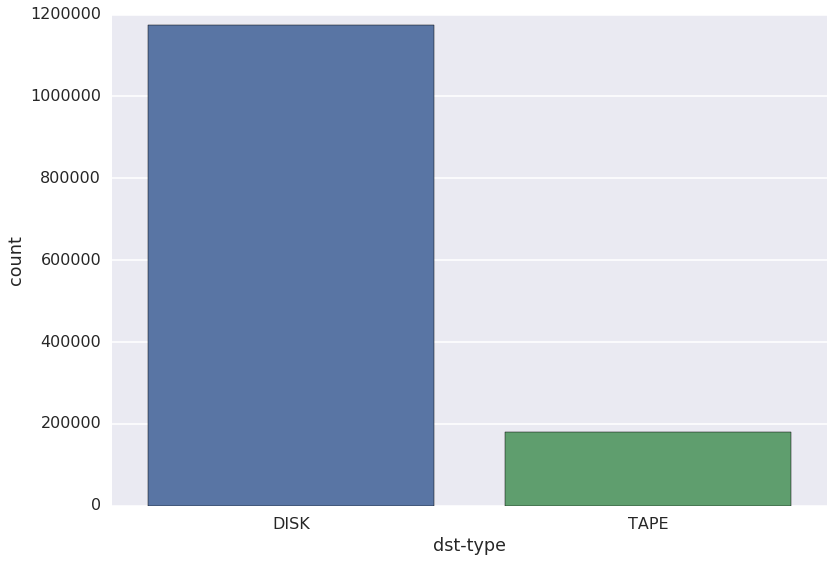

Saved atlas_rucio-events-2017.06.10 data to disk !!
total hits in atlas_rucio-events-2017.06.13 : 1617416
Scrolling index : atlas_rucio-events-2017.06.13 ; step : 0 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.13 ; step : 10 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.13 ; step : 20 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.13 ; step : 30 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.13 ; step : 40 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.13 ; step : 50 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.13 ; step : 60 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.13 ; step : 70 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.13 ; step : 80 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.13 ; step : 90 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.

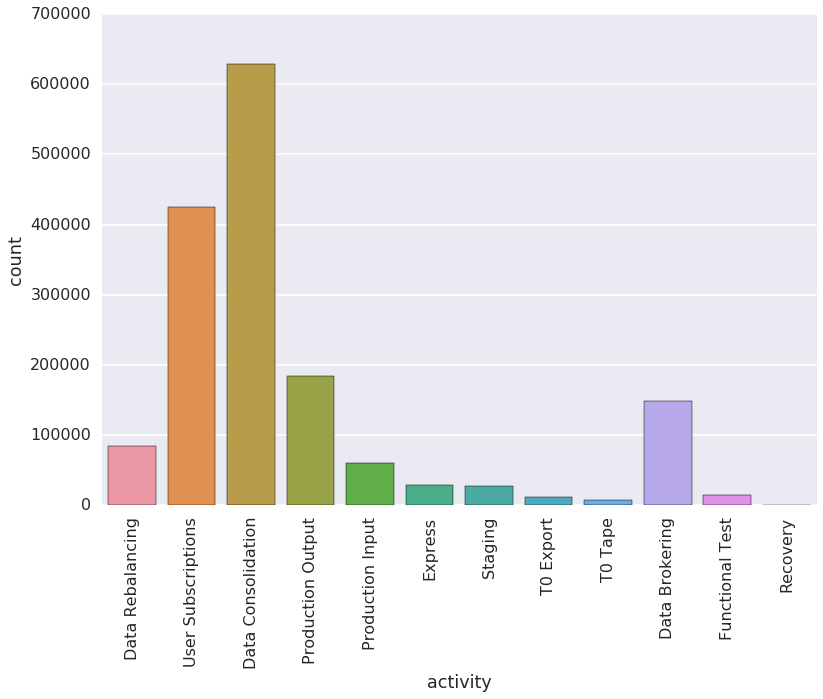

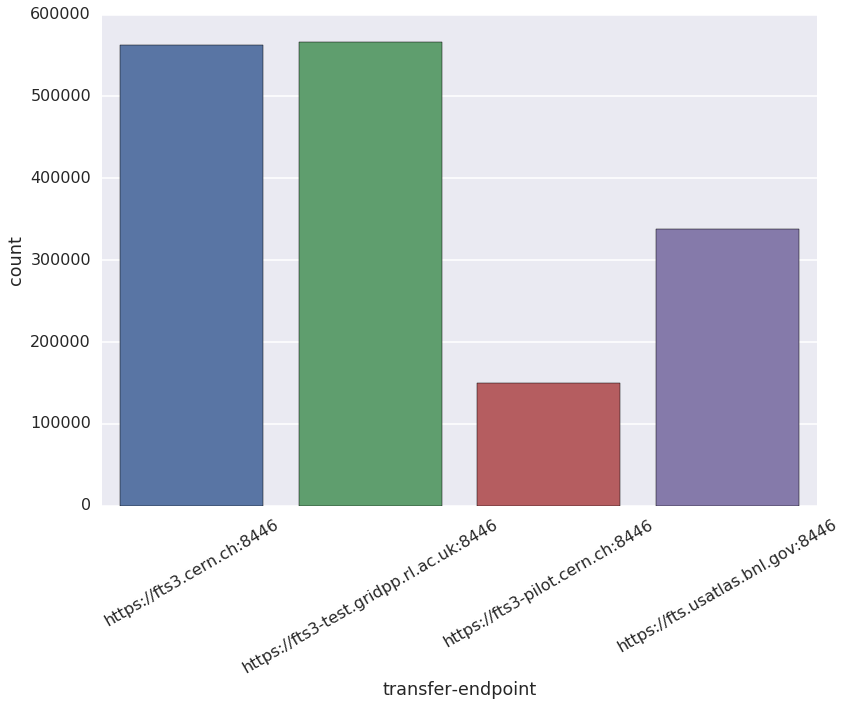

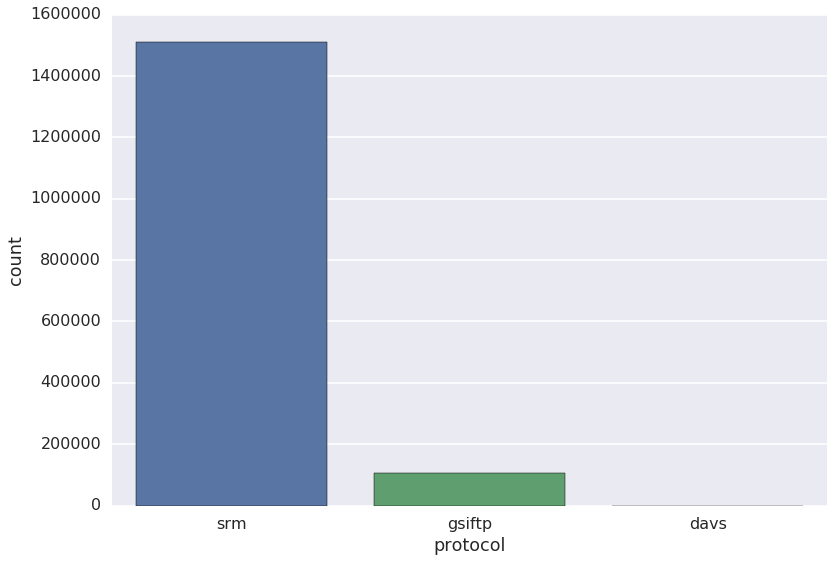

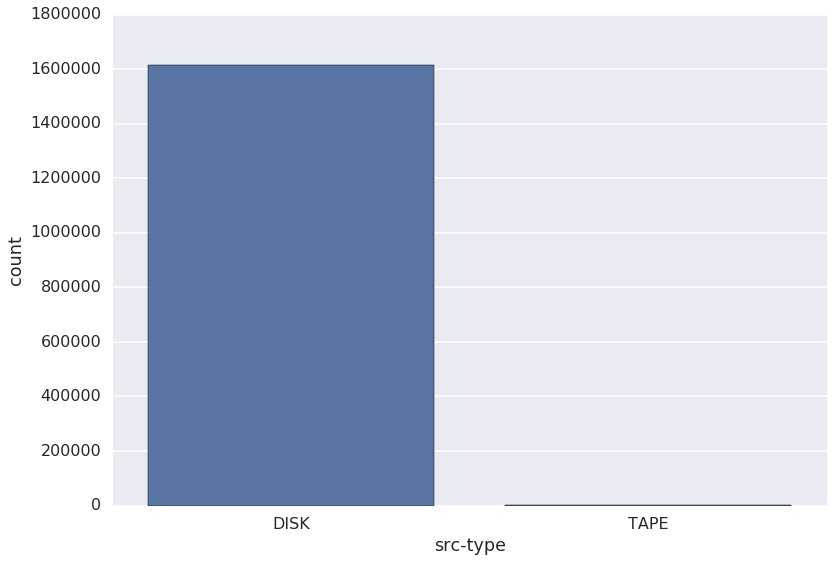

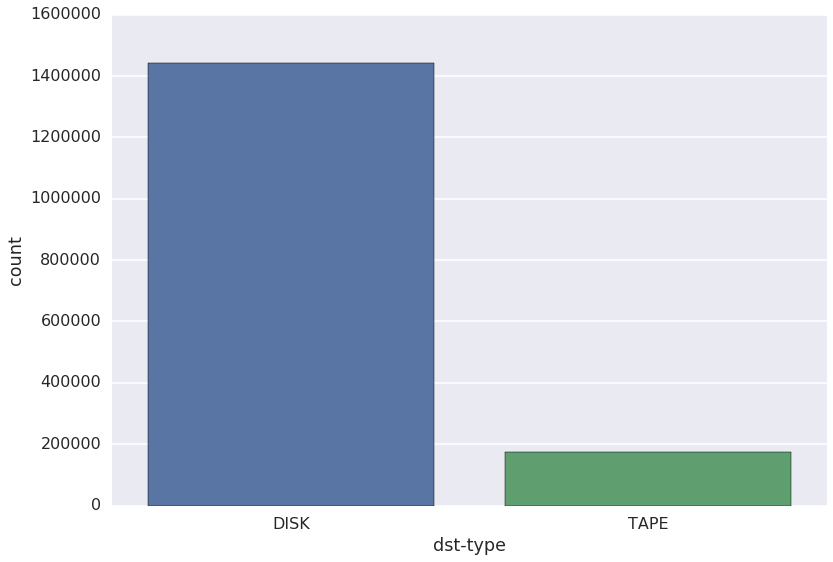

Saved atlas_rucio-events-2017.06.13 data to disk !!
total hits in atlas_rucio-events-2017.06.07 : 1379264
Scrolling index : atlas_rucio-events-2017.06.07 ; step : 0 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.07 ; step : 10 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.07 ; step : 20 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.07 ; step : 30 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.07 ; step : 40 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.07 ; step : 50 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.07 ; step : 60 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.07 ; step : 70 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.07 ; step : 80 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.07 ; step : 90 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.

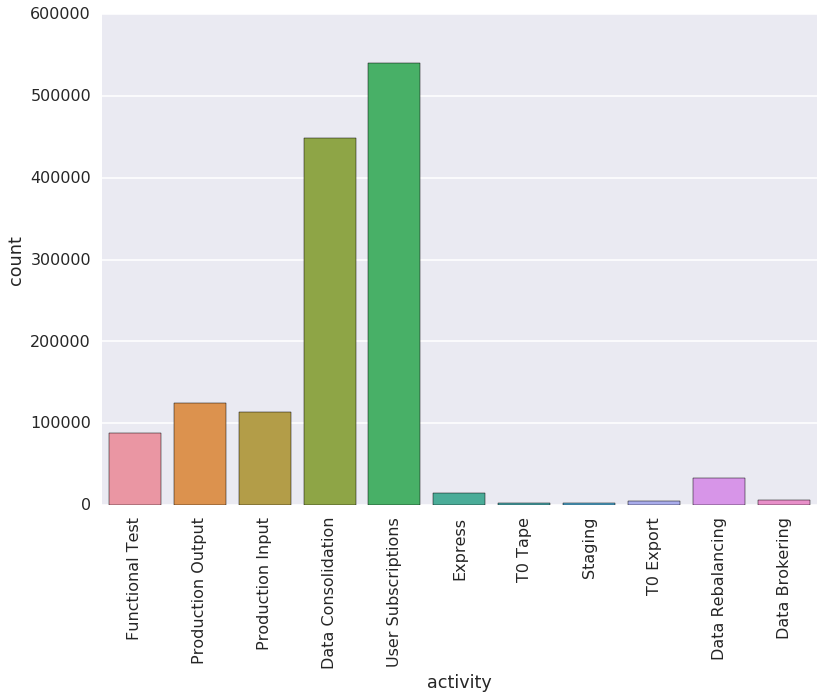

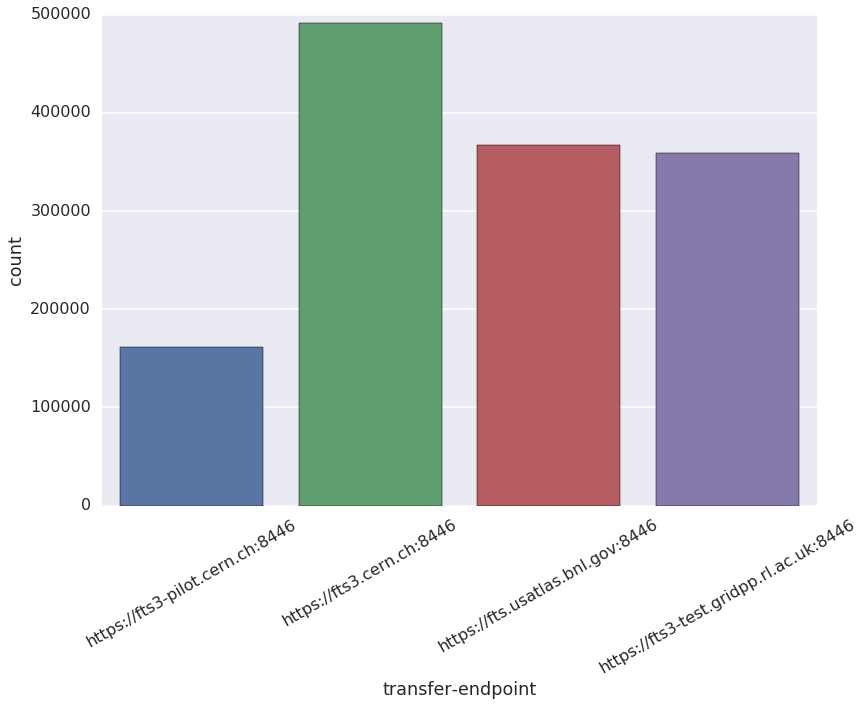

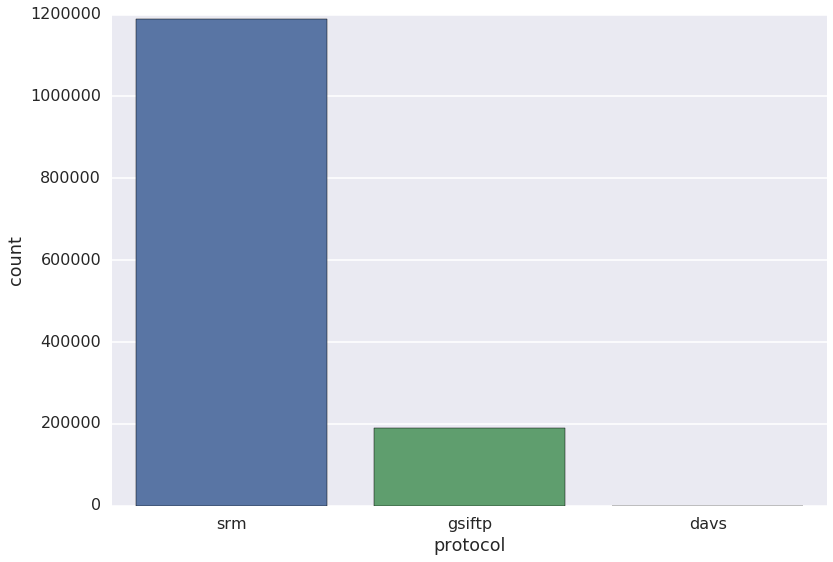

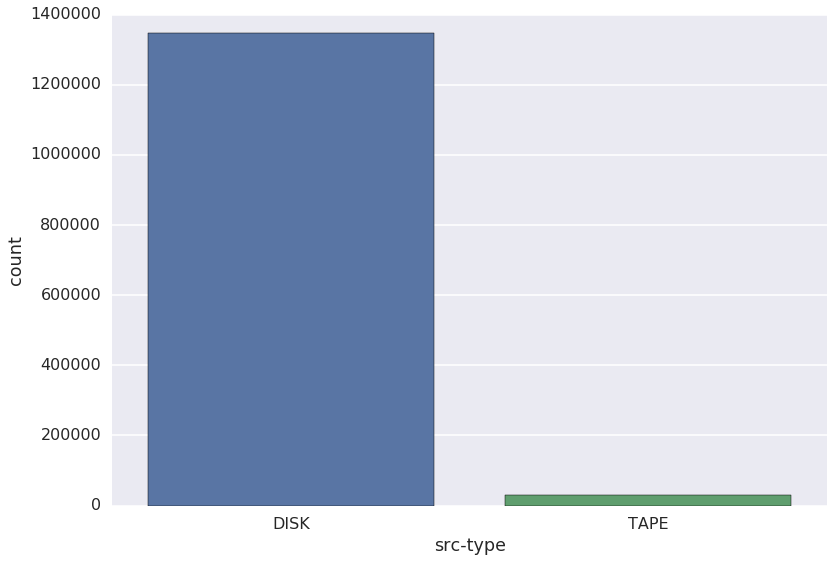

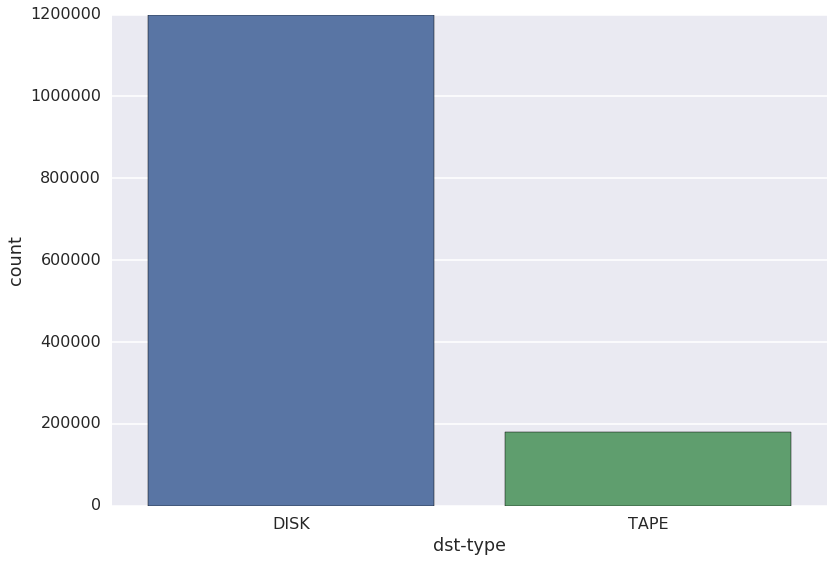

Saved atlas_rucio-events-2017.06.07 data to disk !!
total hits in atlas_rucio-events-2017.06.12 : 2009764
Scrolling index : atlas_rucio-events-2017.06.12 ; step : 0 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.12 ; step : 10 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.12 ; step : 20 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.12 ; step : 30 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.12 ; step : 40 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.12 ; step : 50 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.12 ; step : 60 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.12 ; step : 70 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.12 ; step : 80 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.12 ; step : 90 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.

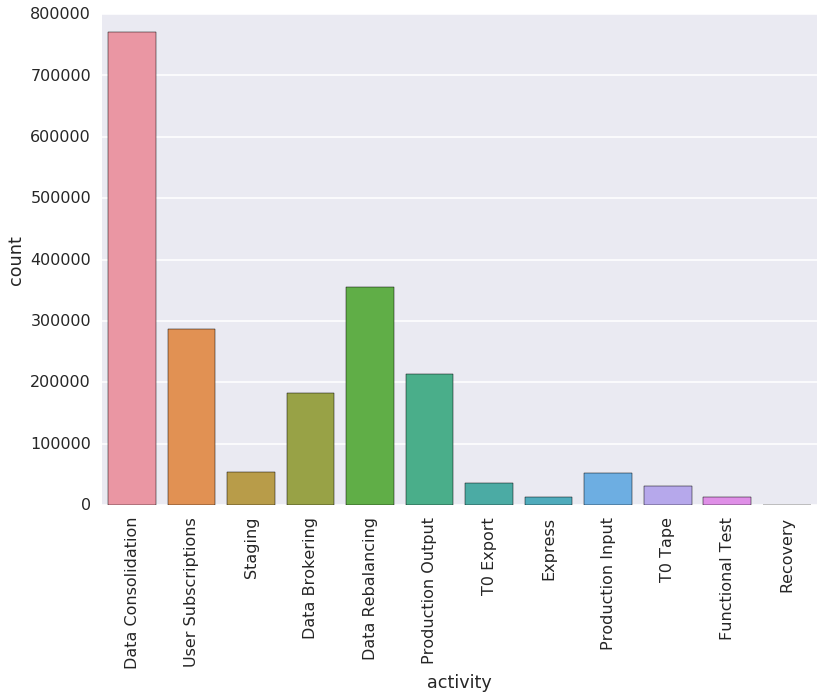

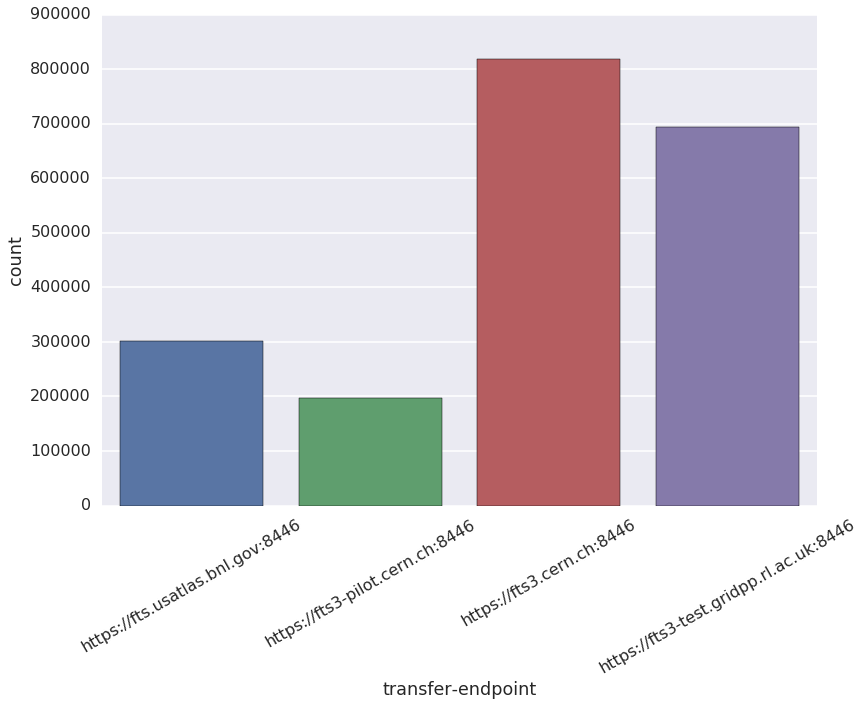

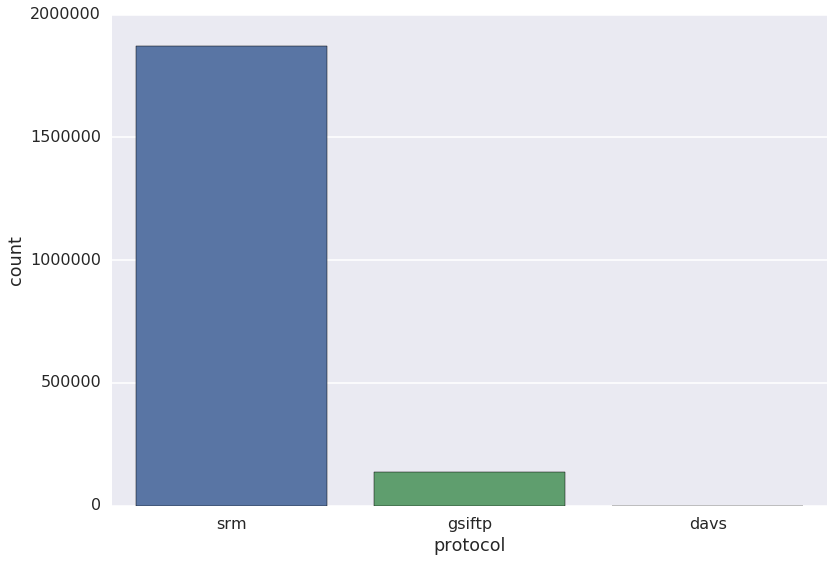

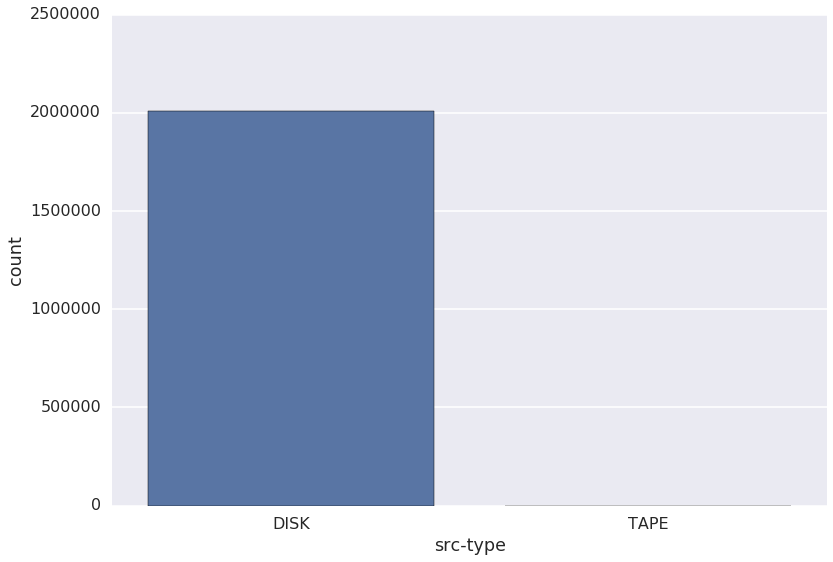

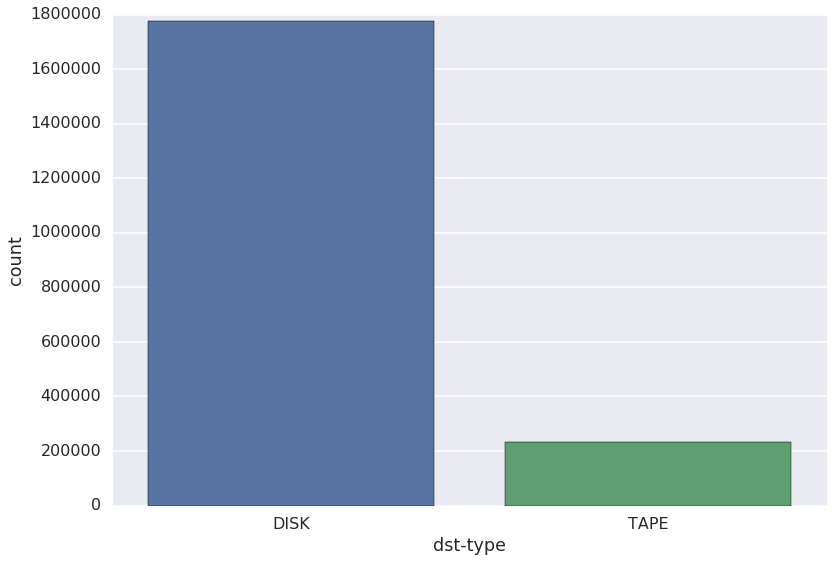

Saved atlas_rucio-events-2017.06.12 data to disk !!
total hits in atlas_rucio-events-2017.06.01 : 1862550
Scrolling index : atlas_rucio-events-2017.06.01 ; step : 0 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.01 ; step : 10 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.01 ; step : 20 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.01 ; step : 30 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.01 ; step : 40 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.01 ; step : 50 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.01 ; step : 60 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.01 ; step : 70 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.01 ; step : 80 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.01 ; step : 90 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.

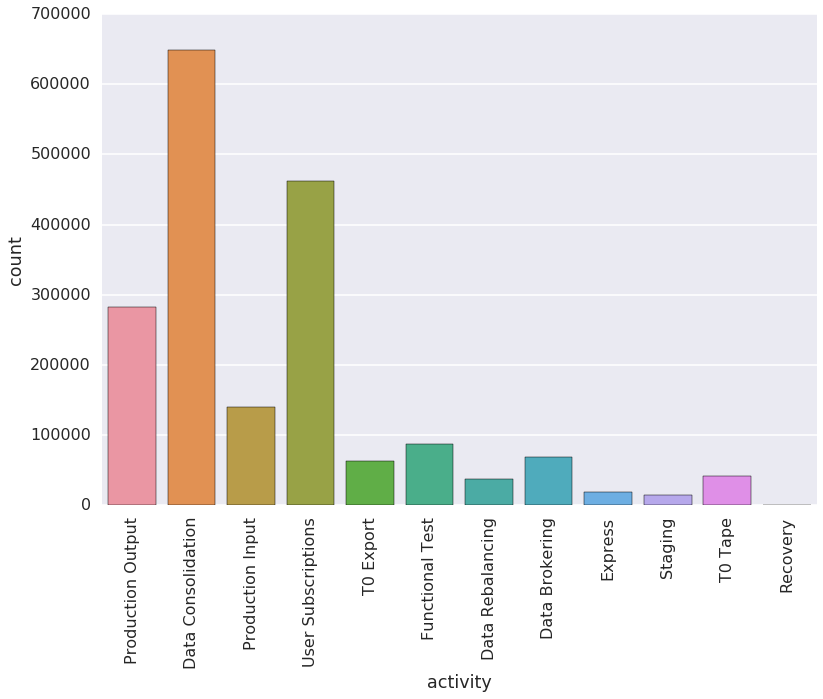

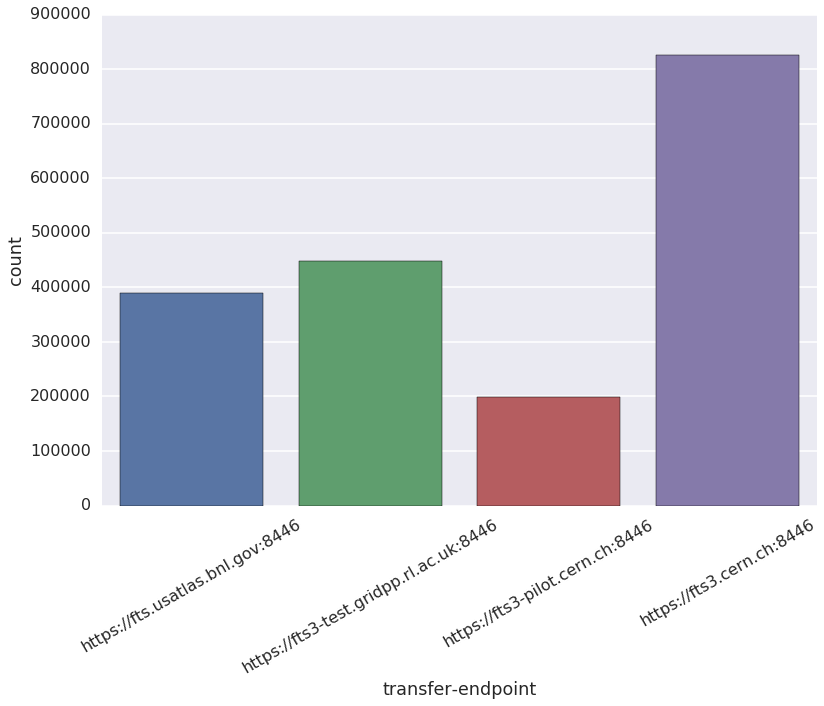

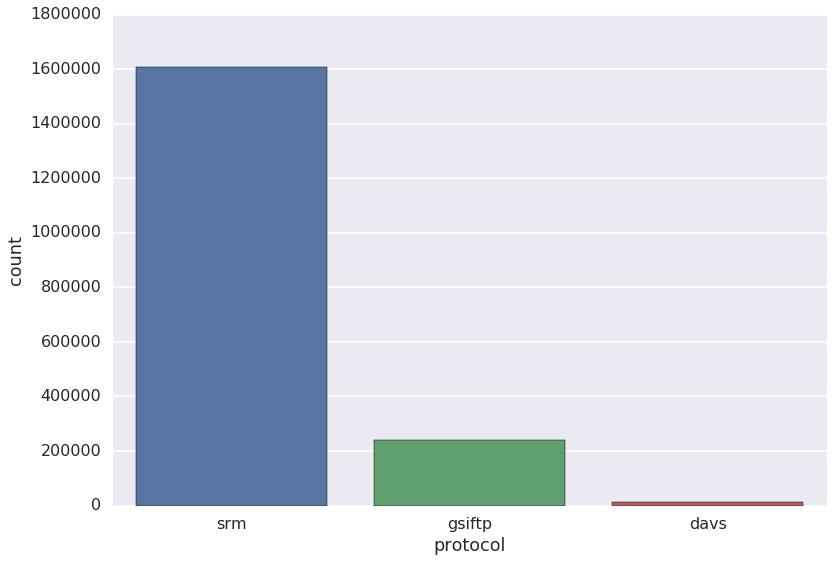

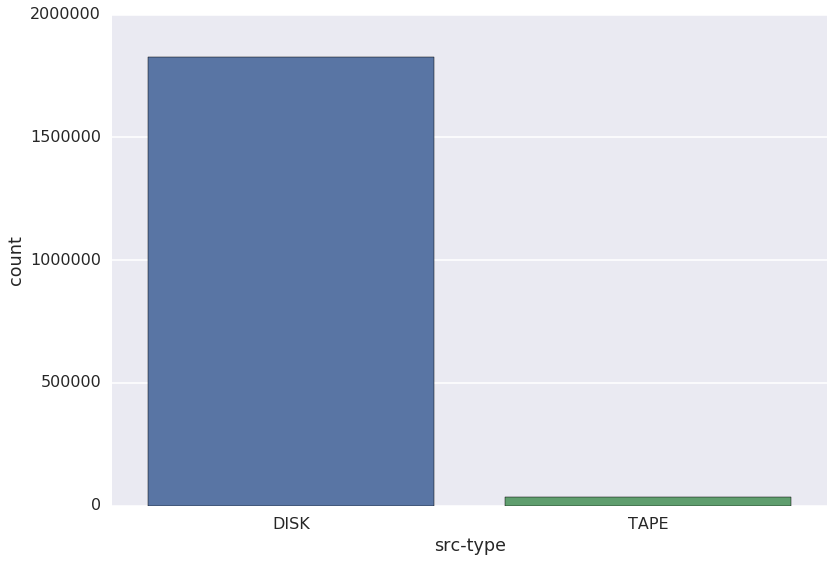

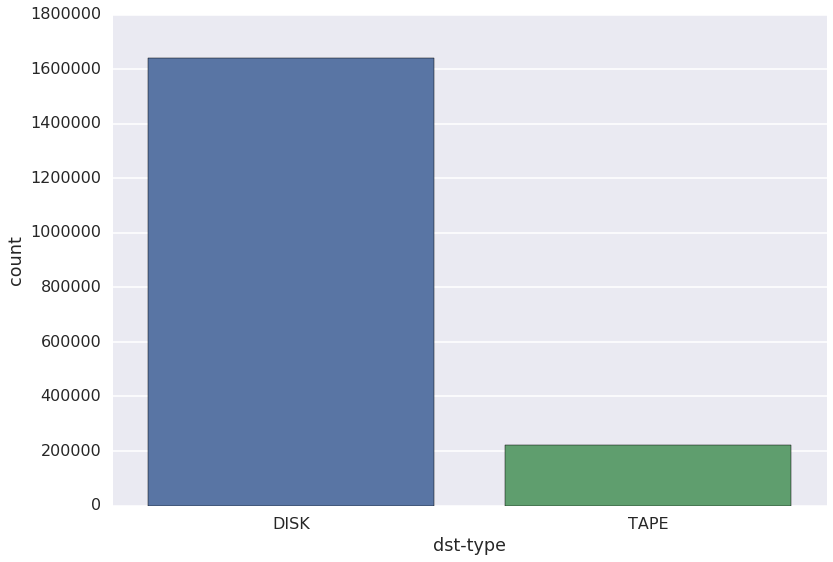

Saved atlas_rucio-events-2017.06.01 data to disk !!
total hits in atlas_rucio-events-2017.06.08 : 1641755
Scrolling index : atlas_rucio-events-2017.06.08 ; step : 0 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.08 ; step : 10 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.08 ; step : 20 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.08 ; step : 30 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.08 ; step : 40 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.08 ; step : 50 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.08 ; step : 60 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.08 ; step : 70 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.08 ; step : 80 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.08 ; step : 90 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.

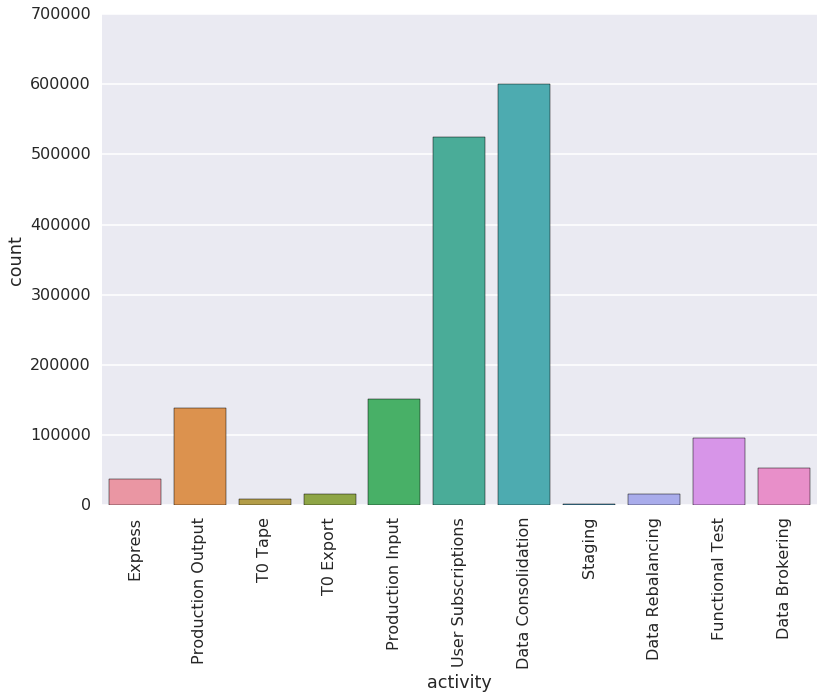

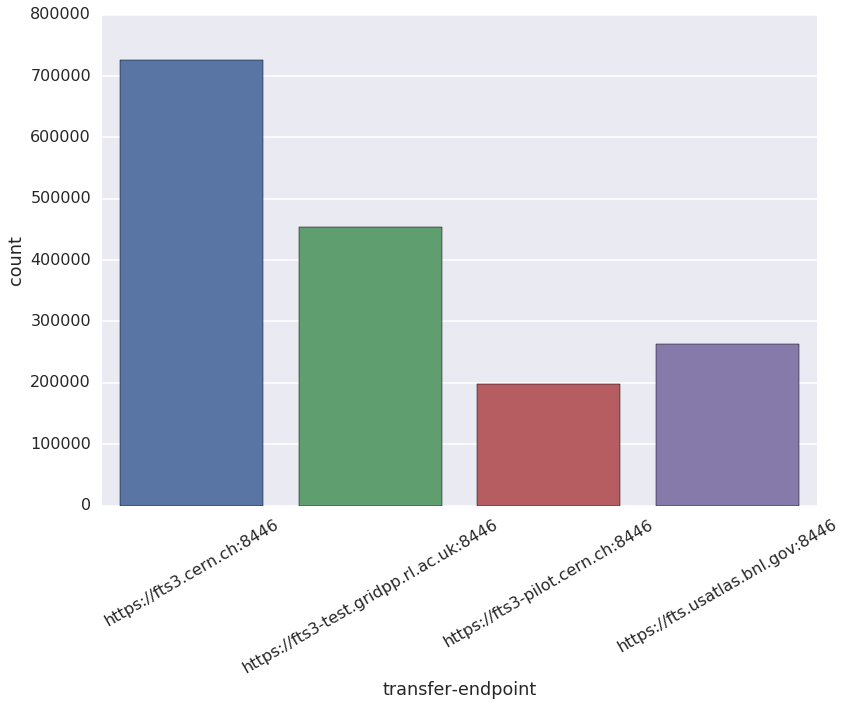

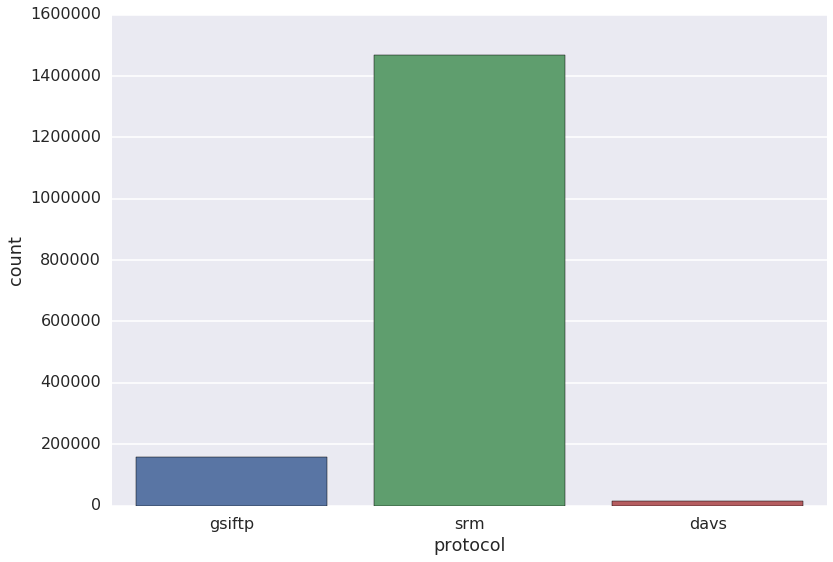

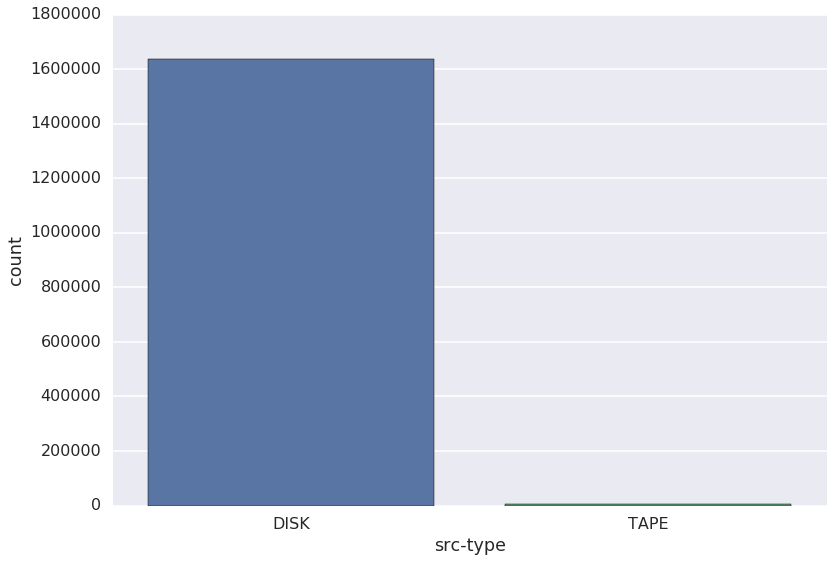

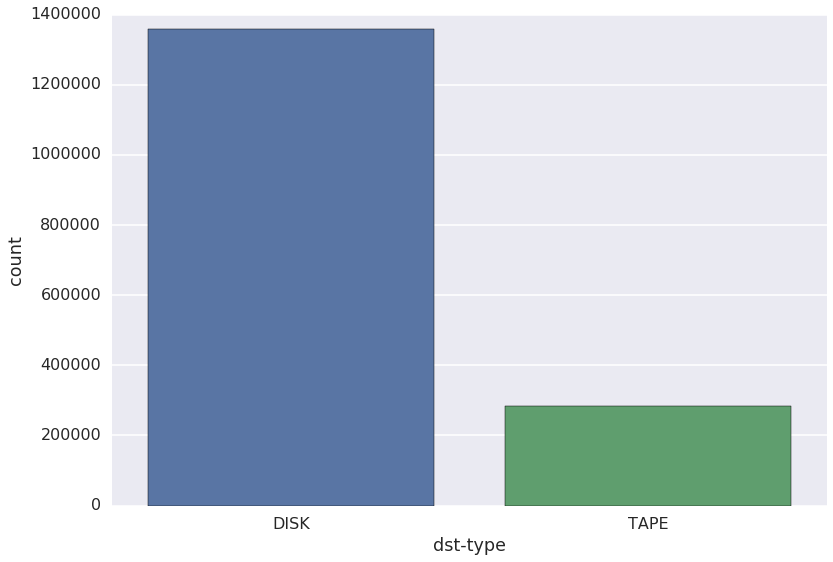

Saved atlas_rucio-events-2017.06.08 data to disk !!
total hits in atlas_rucio-events-2017.06.17 : 1176896
Scrolling index : atlas_rucio-events-2017.06.17 ; step : 0 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.17 ; step : 10 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.17 ; step : 20 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.17 ; step : 30 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.17 ; step : 40 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.17 ; step : 50 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.17 ; step : 60 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.17 ; step : 70 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.17 ; step : 80 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.17 ; step : 90 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.

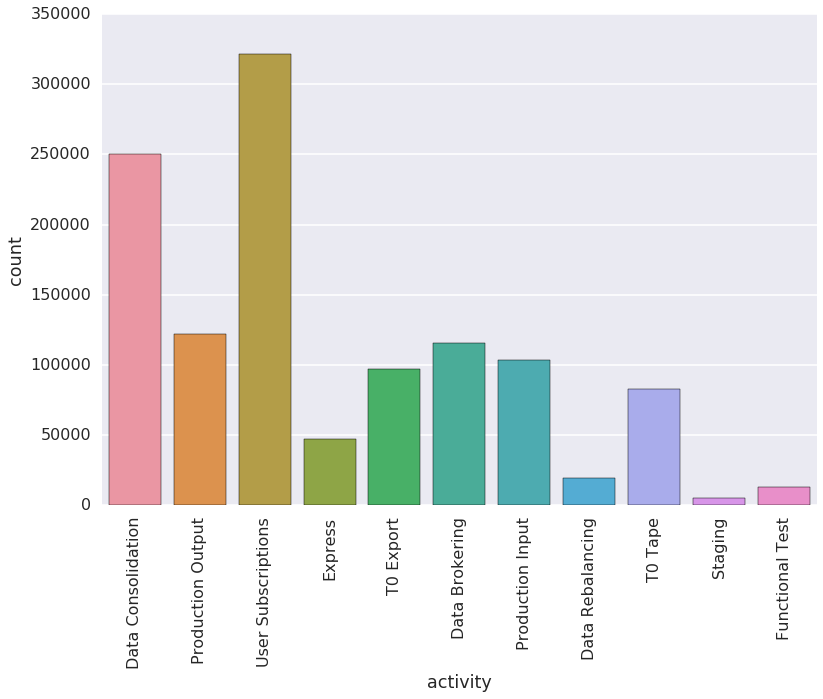

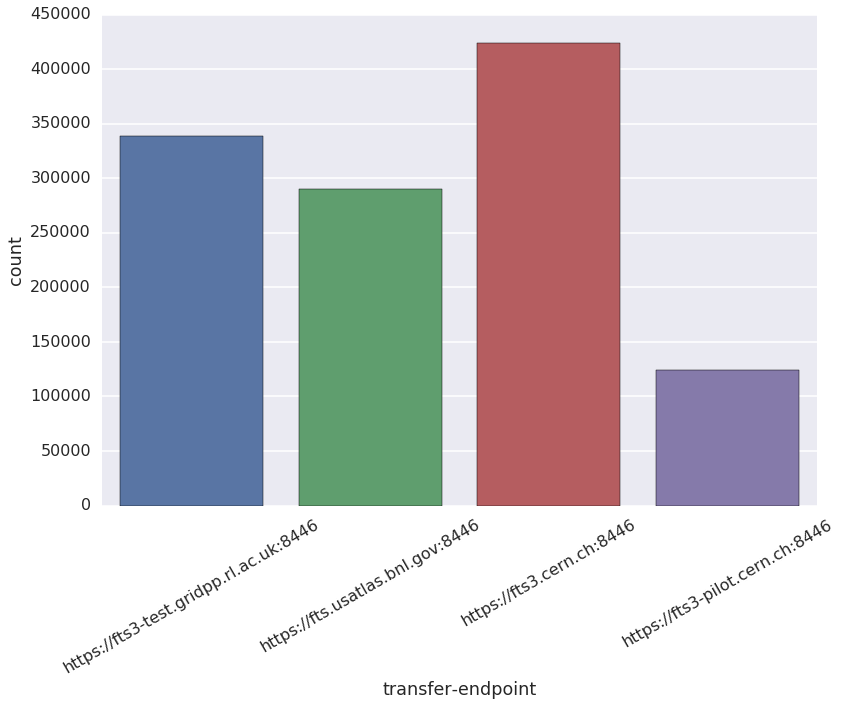

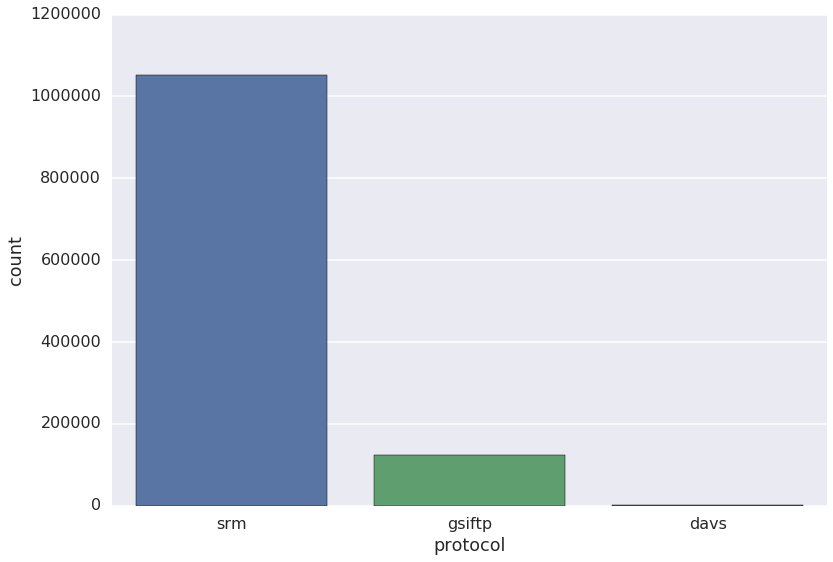

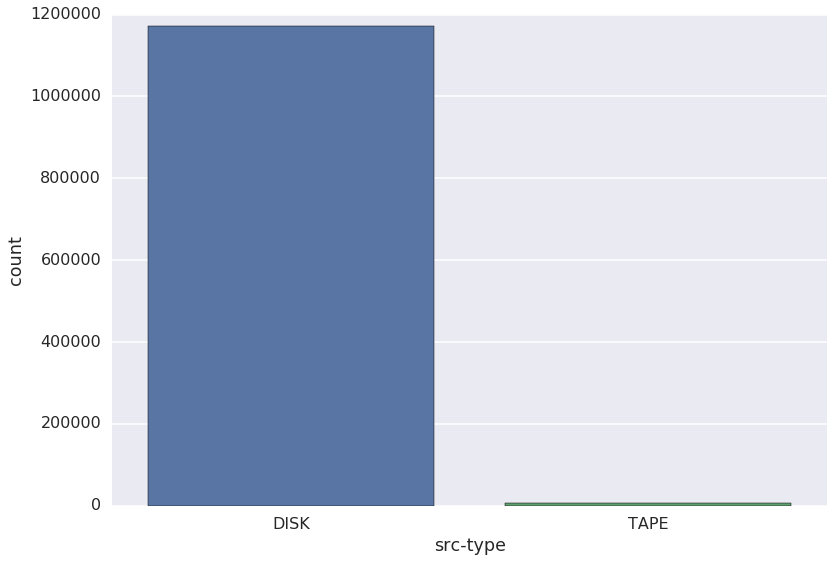

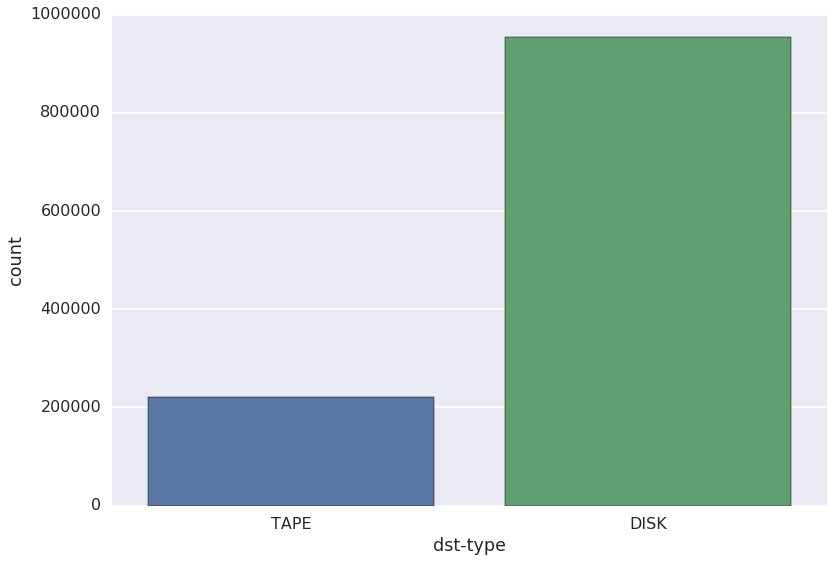

Saved atlas_rucio-events-2017.06.17 data to disk !!
total hits in atlas_rucio-events-2017.06.15 : 1593270
Scrolling index : atlas_rucio-events-2017.06.15 ; step : 0 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.15 ; step : 10 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.15 ; step : 20 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.15 ; step : 30 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.15 ; step : 40 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.15 ; step : 50 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.15 ; step : 60 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.15 ; step : 70 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.15 ; step : 80 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.15 ; step : 90 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.

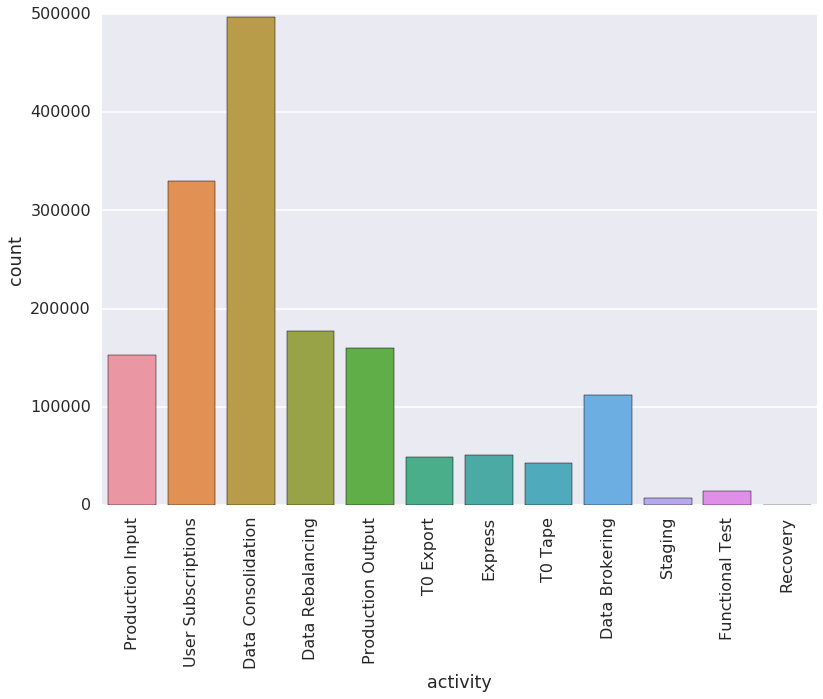

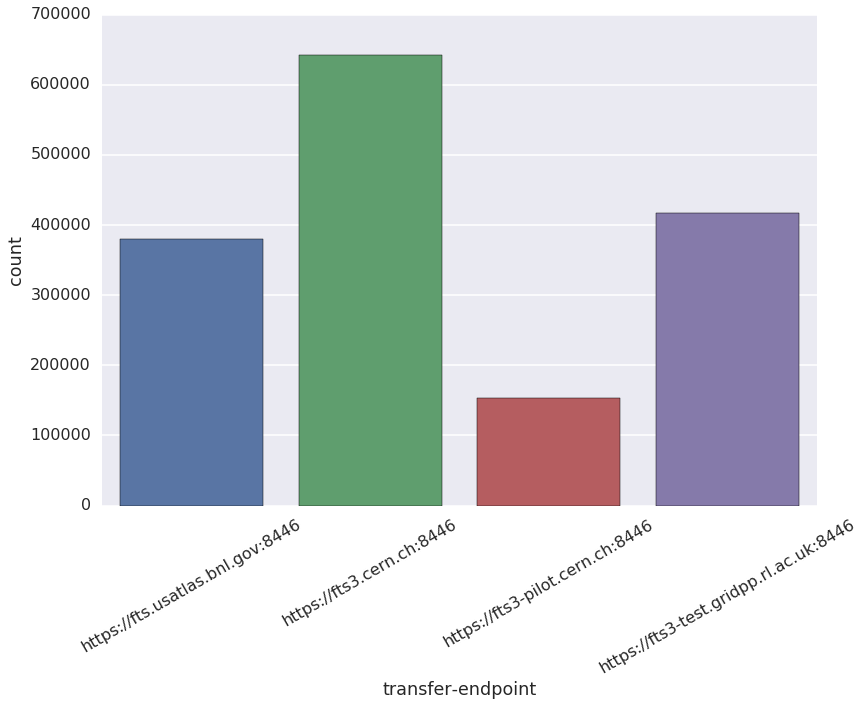

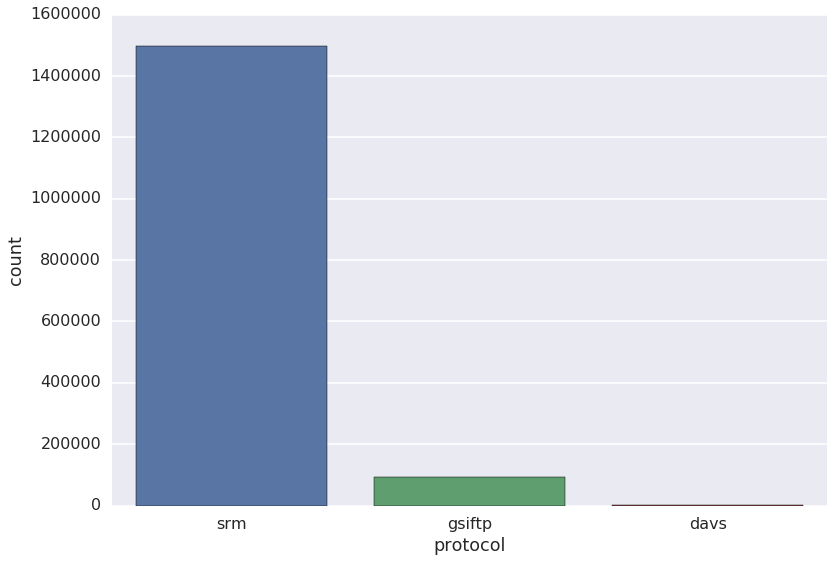

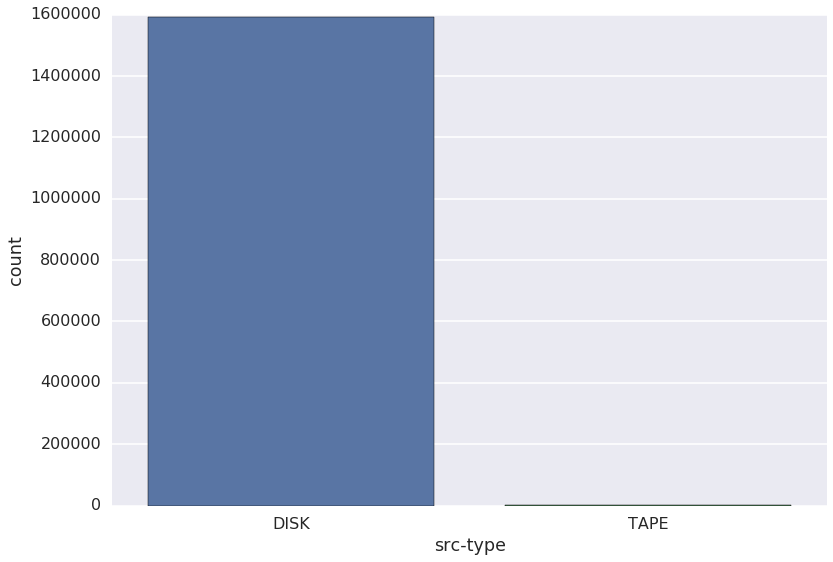

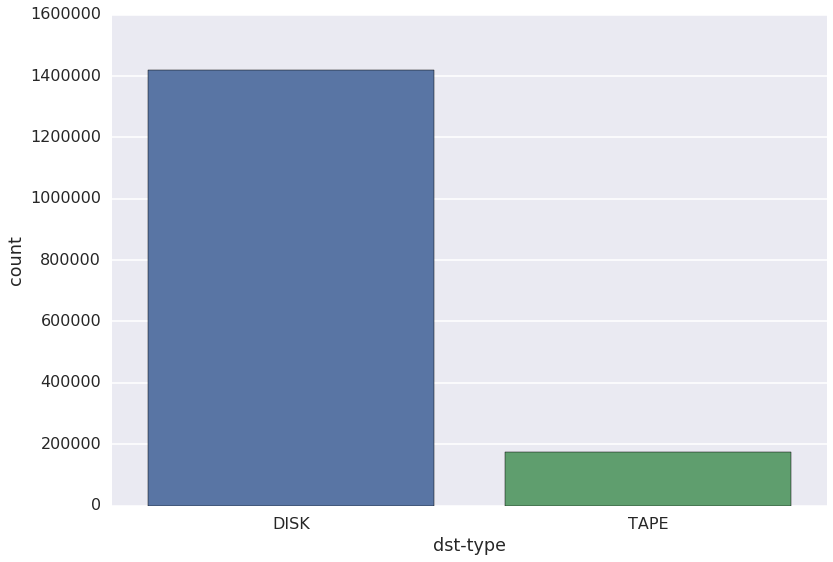

Saved atlas_rucio-events-2017.06.15 data to disk !!
total hits in atlas_rucio-events-2017.06.19 : 1708407
Scrolling index : atlas_rucio-events-2017.06.19 ; step : 0 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.19 ; step : 10 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.19 ; step : 20 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.19 ; step : 30 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.19 ; step : 40 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.19 ; step : 50 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.19 ; step : 60 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.19 ; step : 70 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.19 ; step : 80 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.19 ; step : 90 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.

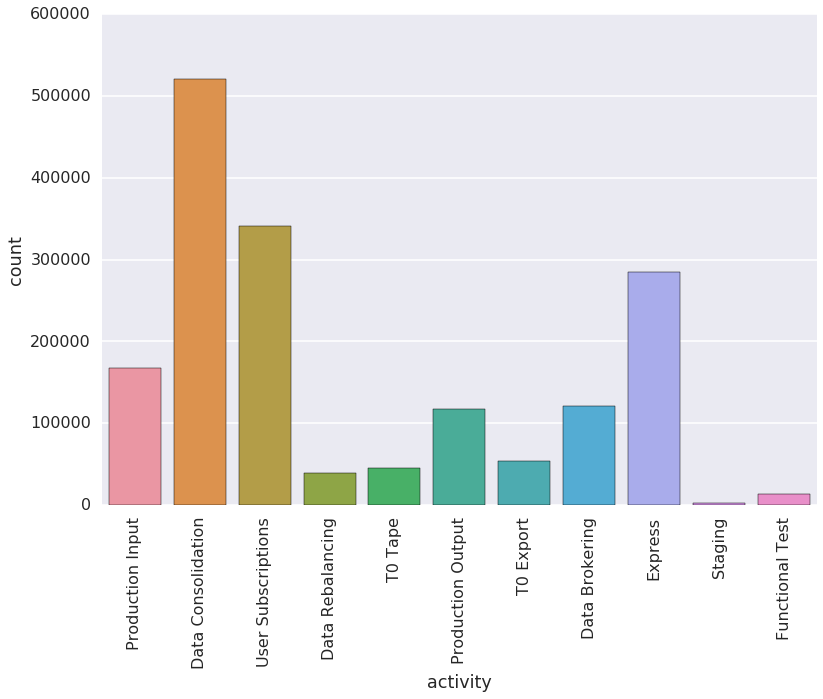

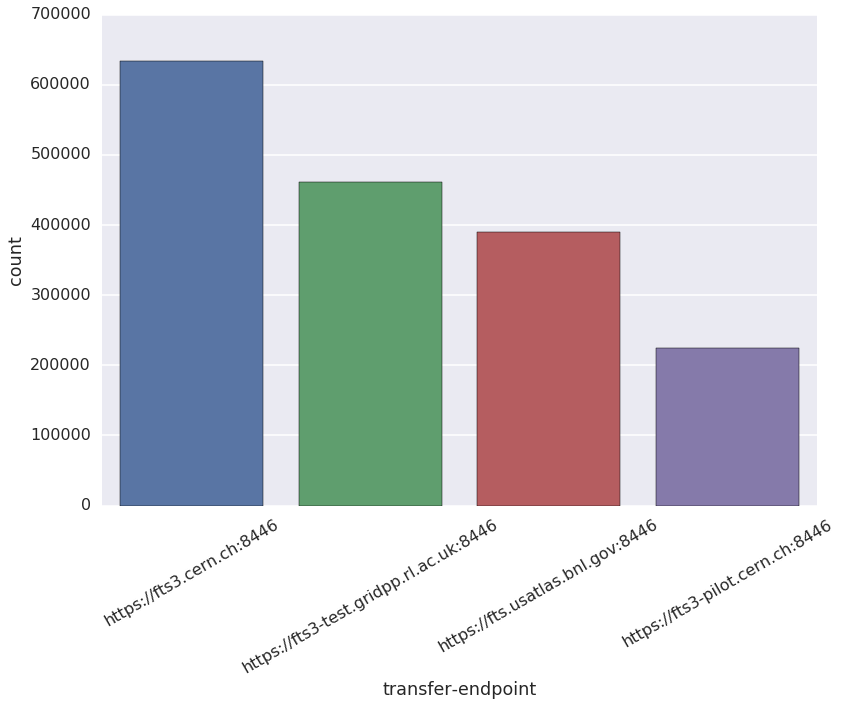

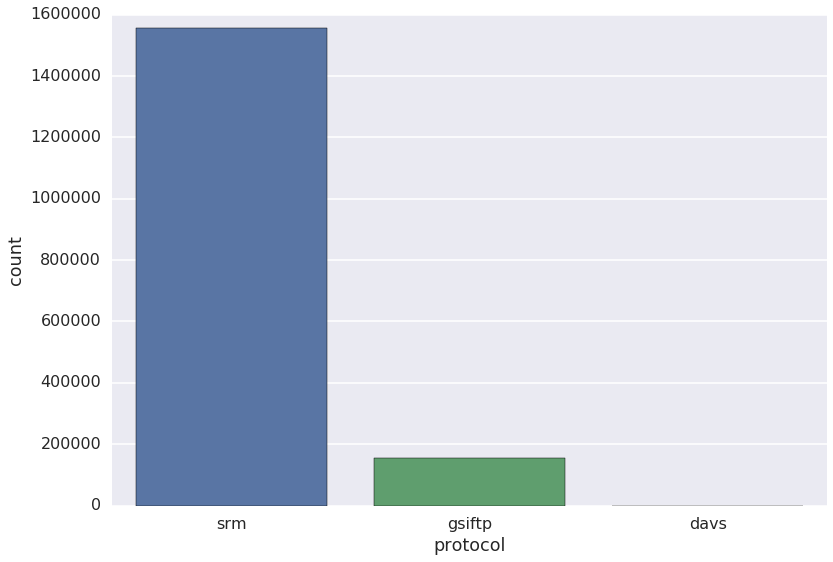

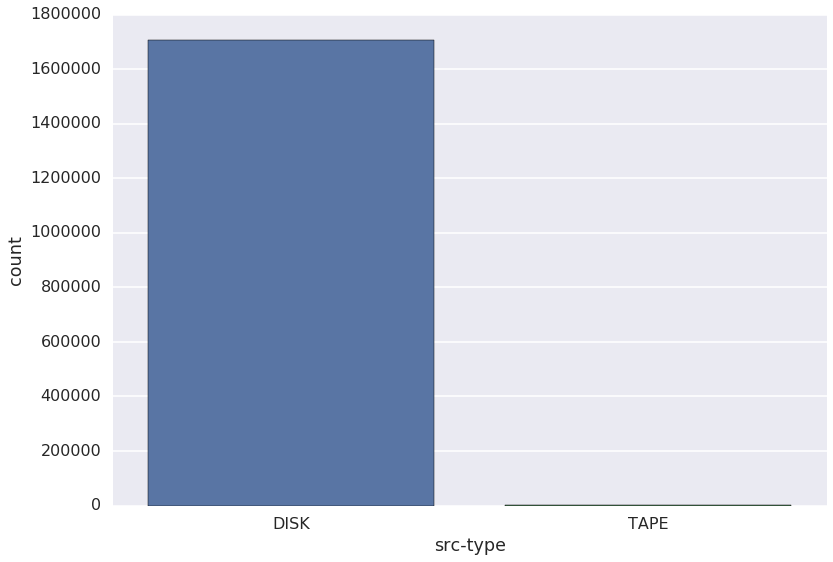

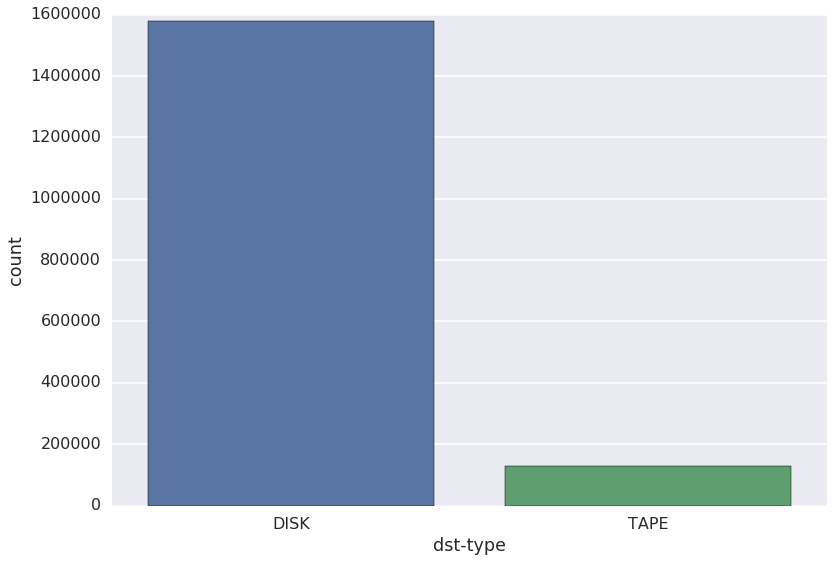

Saved atlas_rucio-events-2017.06.19 data to disk !!
total hits in atlas_rucio-events-2017.06.11 : 1234481
Scrolling index : atlas_rucio-events-2017.06.11 ; step : 0 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.11 ; step : 10 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.11 ; step : 20 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.11 ; step : 30 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.11 ; step : 40 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.11 ; step : 50 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.11 ; step : 60 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.11 ; step : 70 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.11 ; step : 80 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.11 ; step : 90 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.

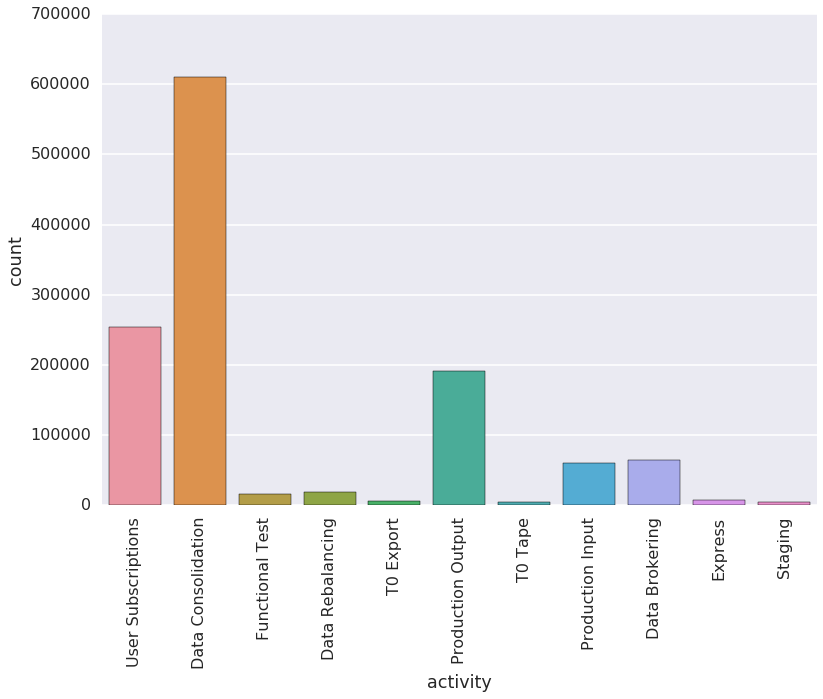

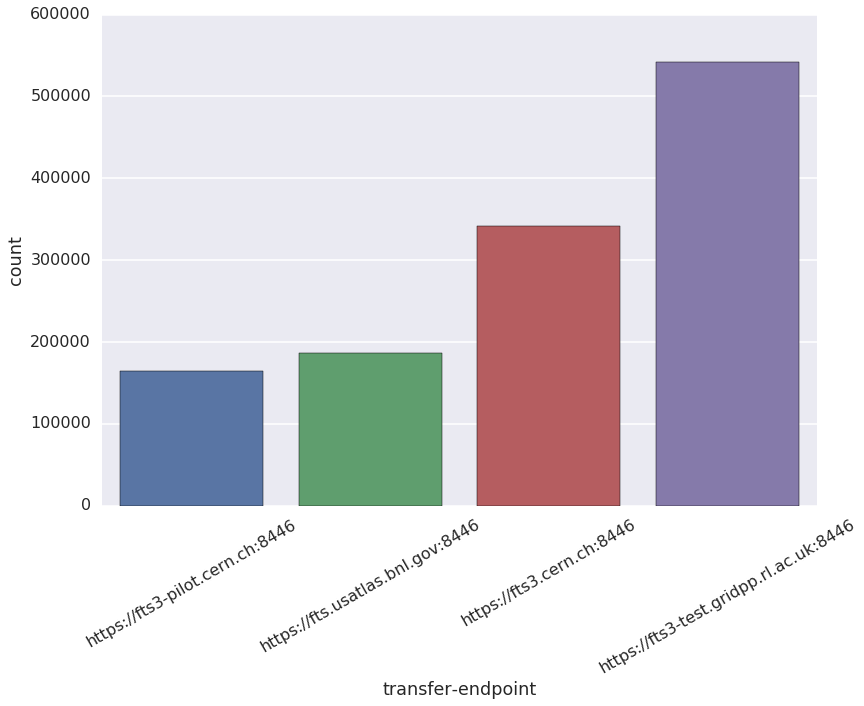

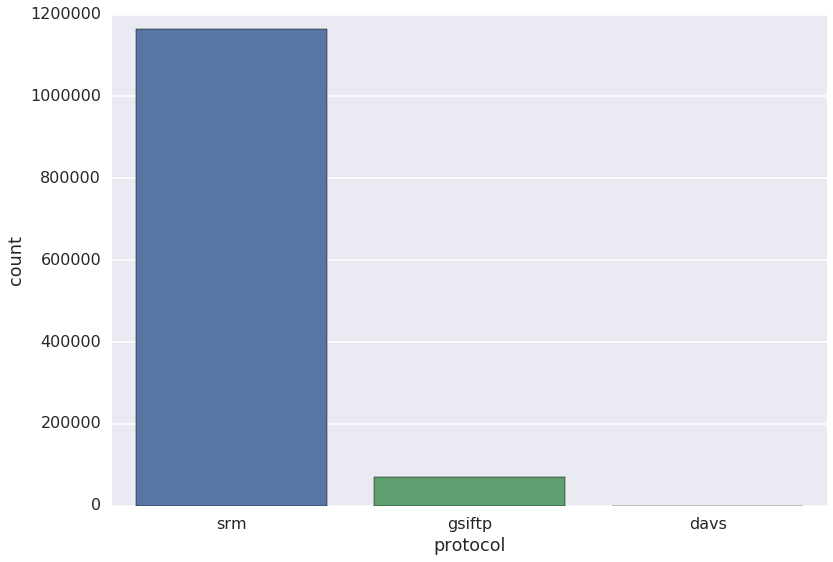

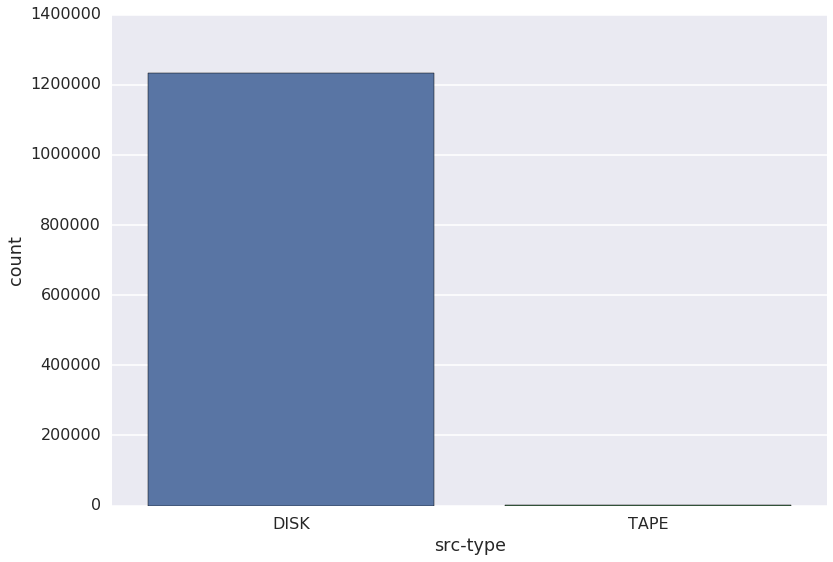

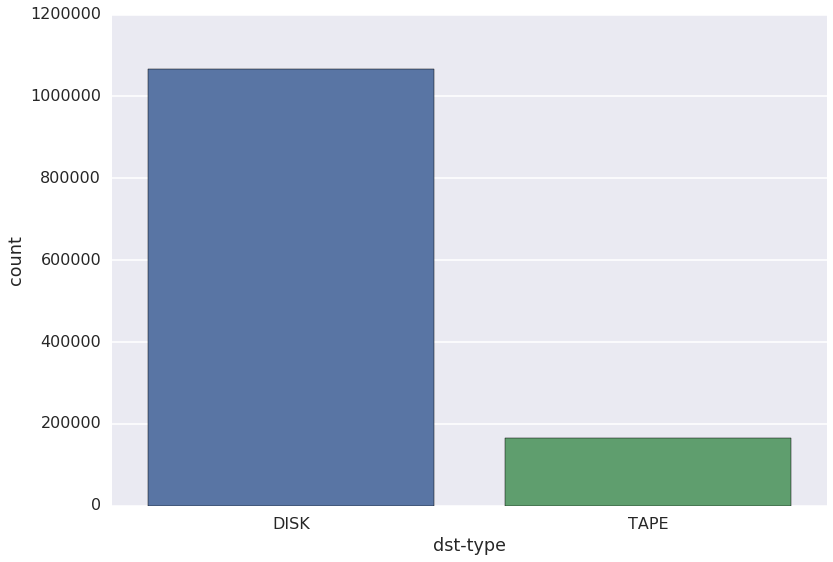

Saved atlas_rucio-events-2017.06.11 data to disk !!
total hits in atlas_rucio-events-2017.06.16 : 1698234
Scrolling index : atlas_rucio-events-2017.06.16 ; step : 0 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.16 ; step : 10 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.16 ; step : 20 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.16 ; step : 30 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.16 ; step : 40 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.16 ; step : 50 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.16 ; step : 60 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.16 ; step : 70 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.16 ; step : 80 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.16 ; step : 90 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.

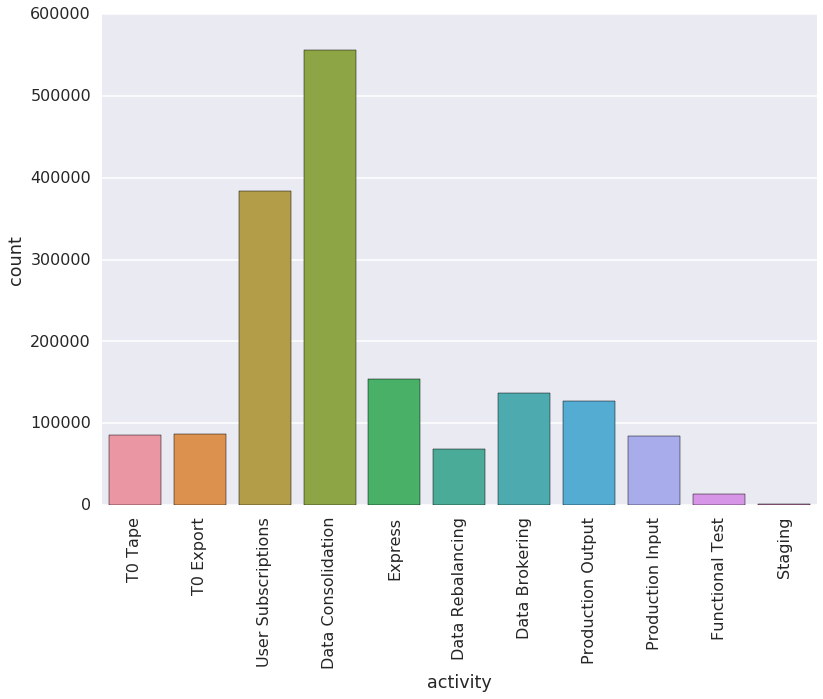

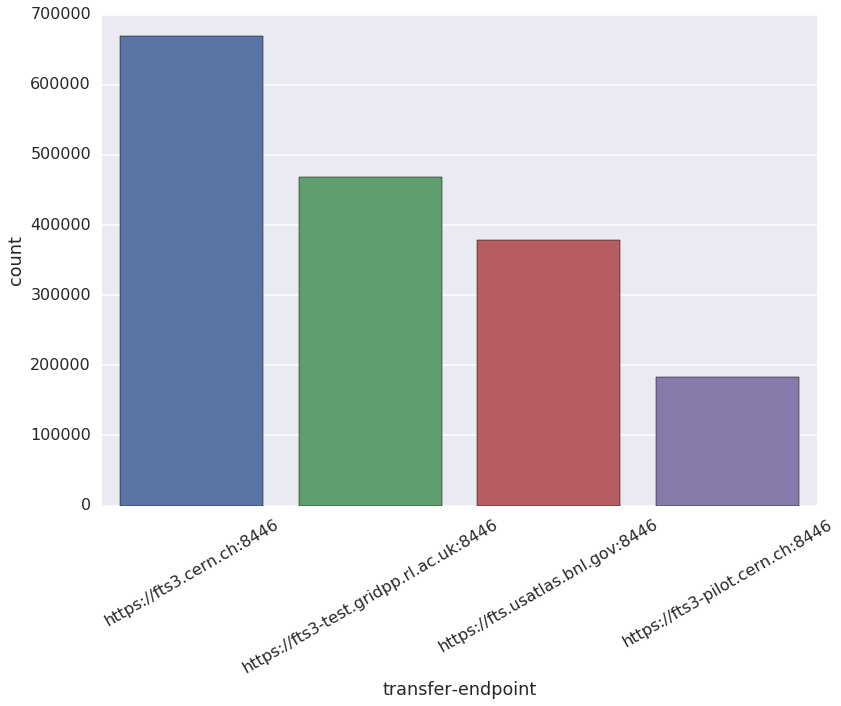

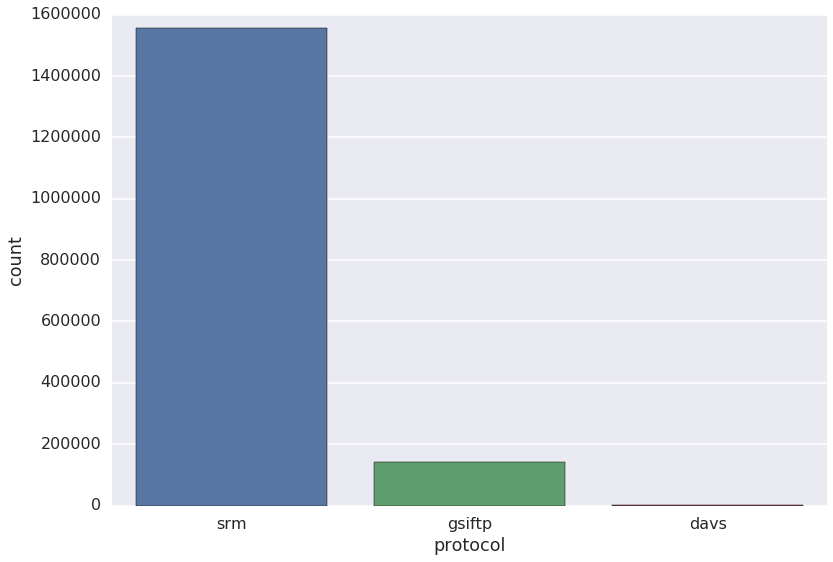

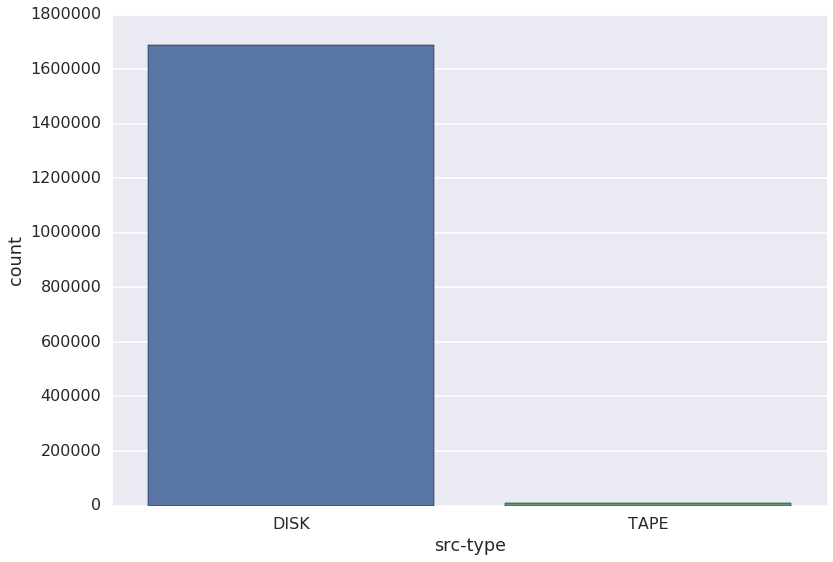

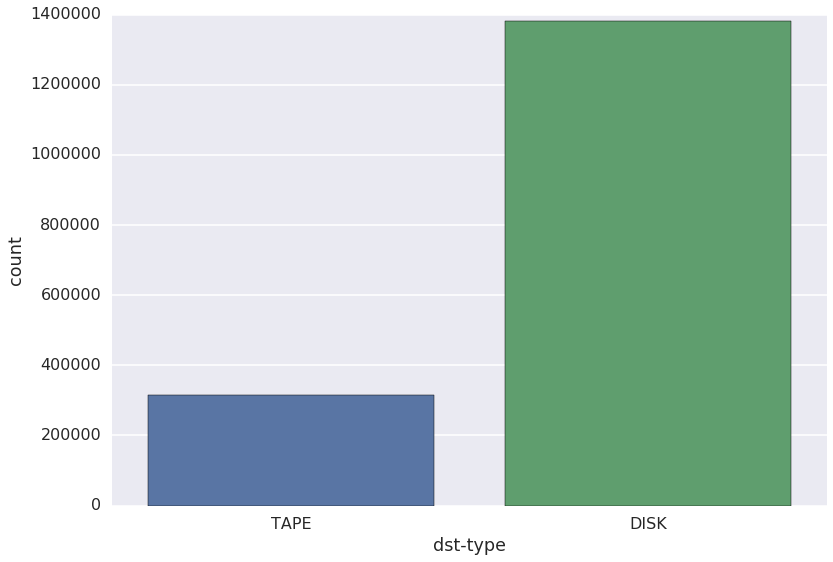

Saved atlas_rucio-events-2017.06.16 data to disk !!
total hits in atlas_rucio-events-2017.06.21 : 2085203
Scrolling index : atlas_rucio-events-2017.06.21 ; step : 0 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.21 ; step : 10 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.21 ; step : 20 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.21 ; step : 30 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.21 ; step : 40 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.21 ; step : 50 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.21 ; step : 60 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.21 ; step : 70 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.21 ; step : 80 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.21 ; step : 90 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.

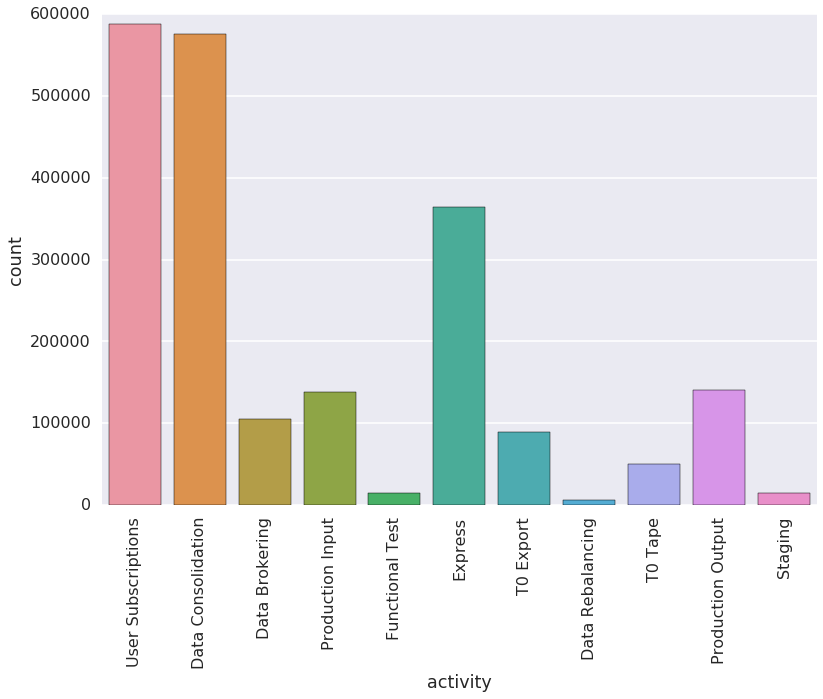

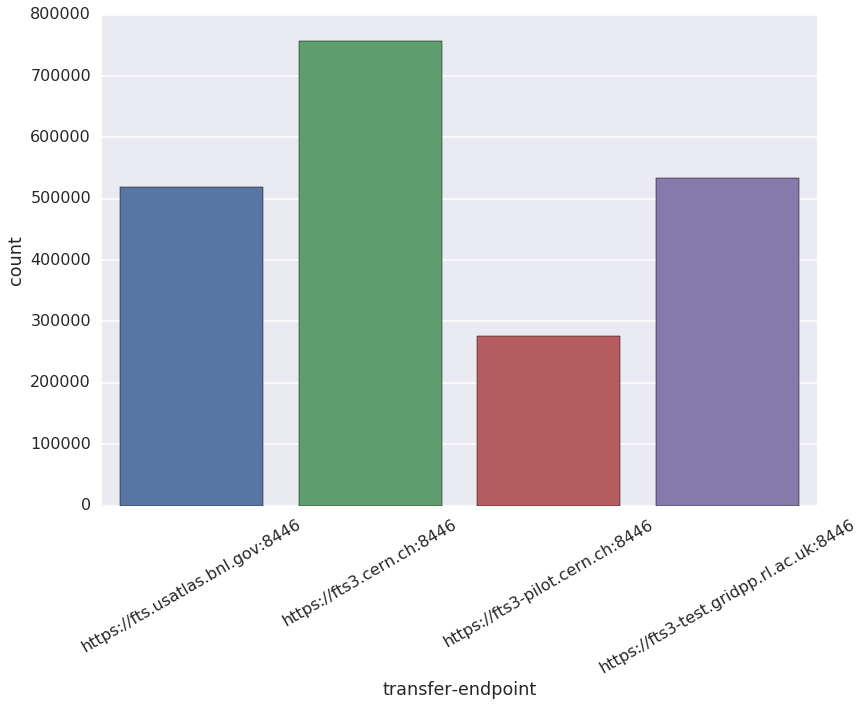

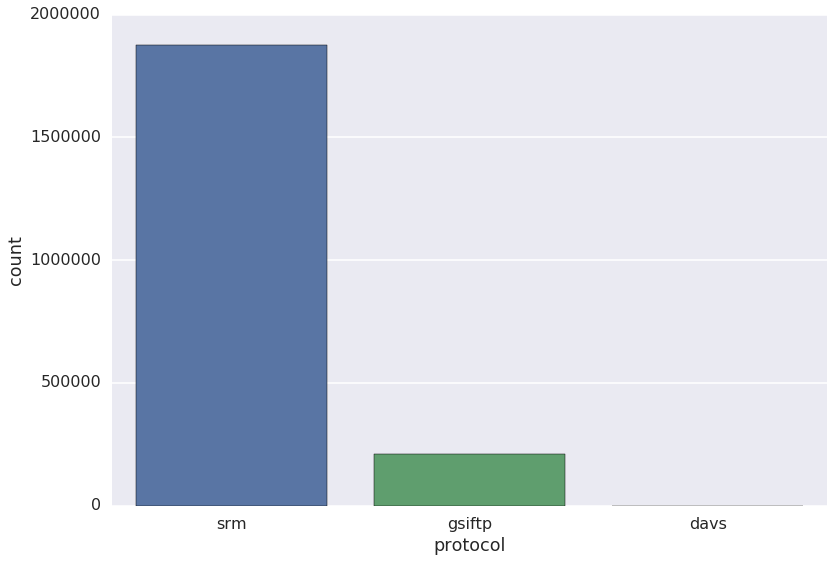

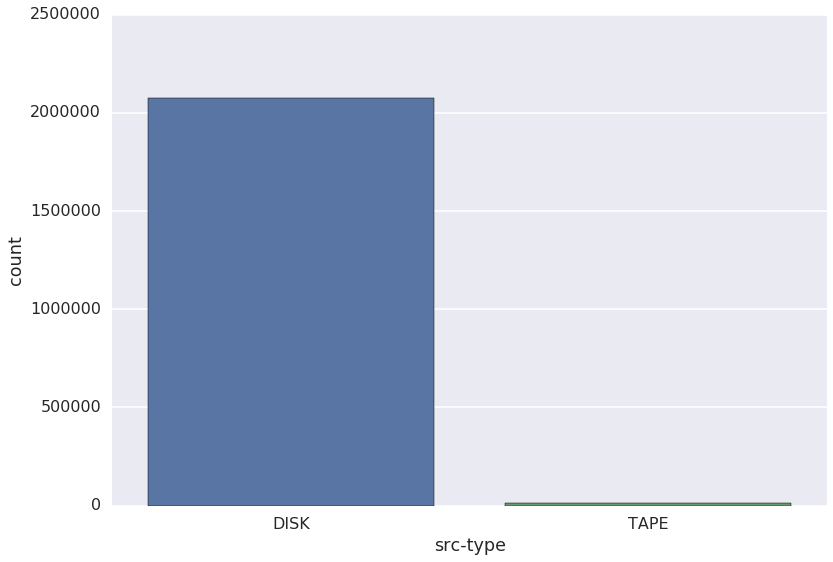

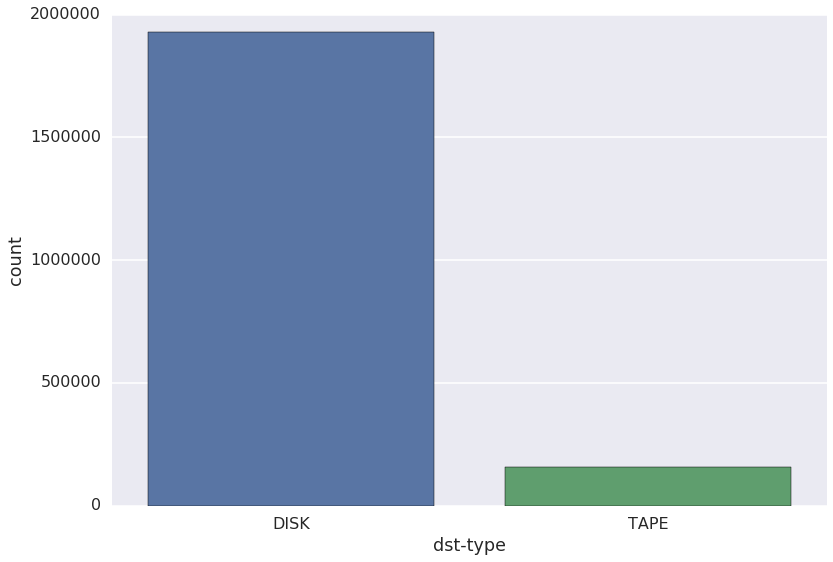

Saved atlas_rucio-events-2017.06.21 data to disk !!
total hits in atlas_rucio-events-2017.06.06 : 2136482
Scrolling index : atlas_rucio-events-2017.06.06 ; step : 0 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.06 ; step : 10 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.06 ; step : 20 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.06 ; step : 30 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.06 ; step : 40 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.06 ; step : 50 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.06 ; step : 60 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.06 ; step : 70 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.06 ; step : 80 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.06 ; step : 90 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.

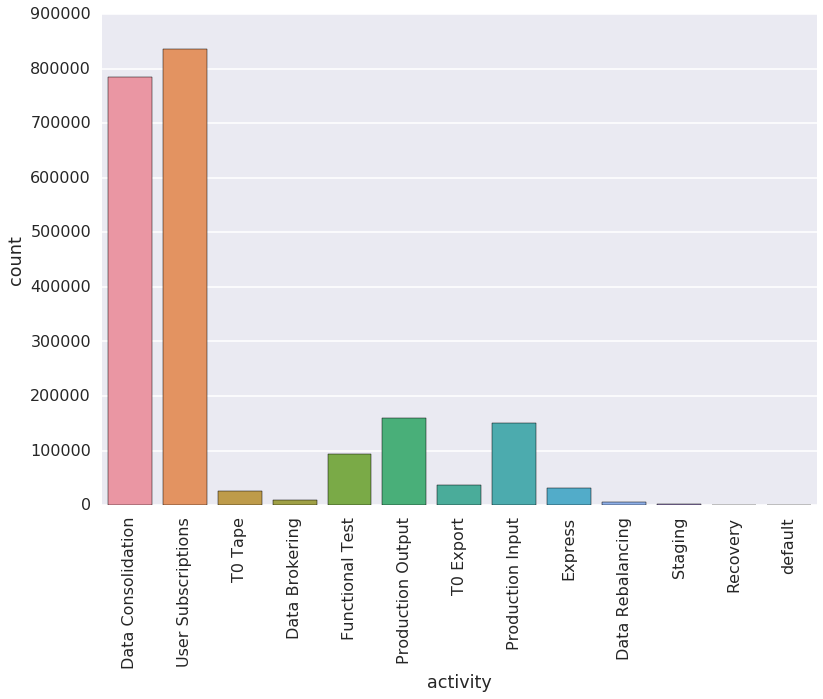

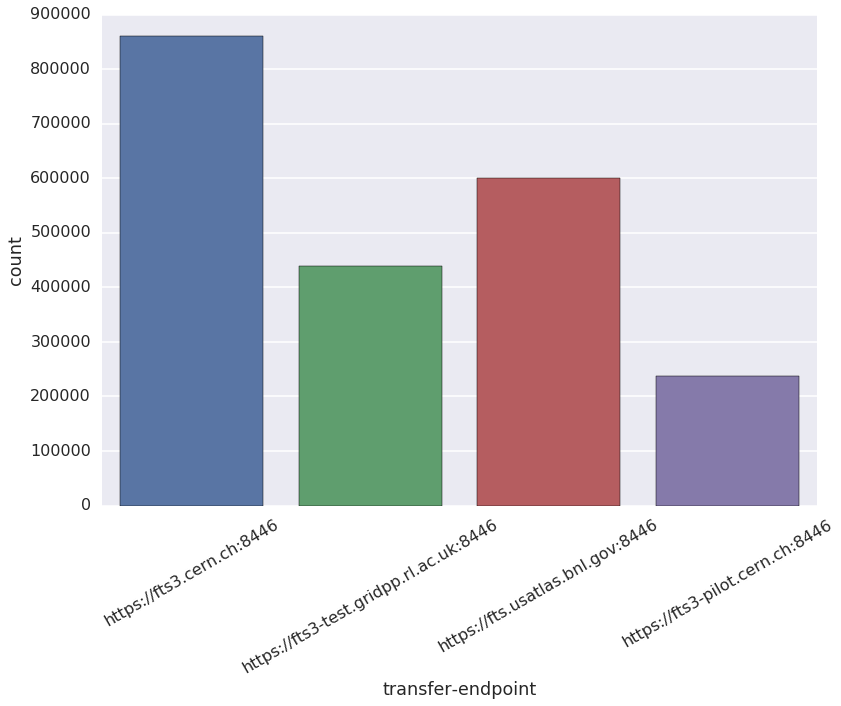

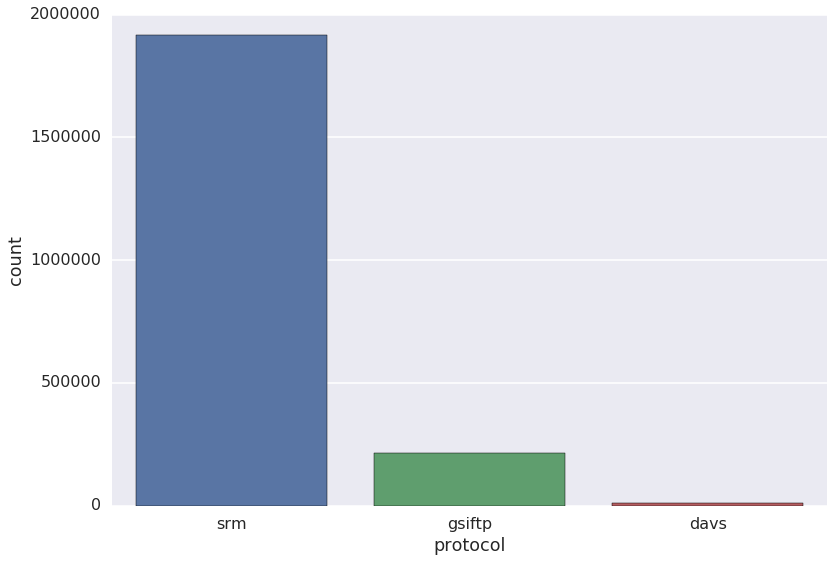

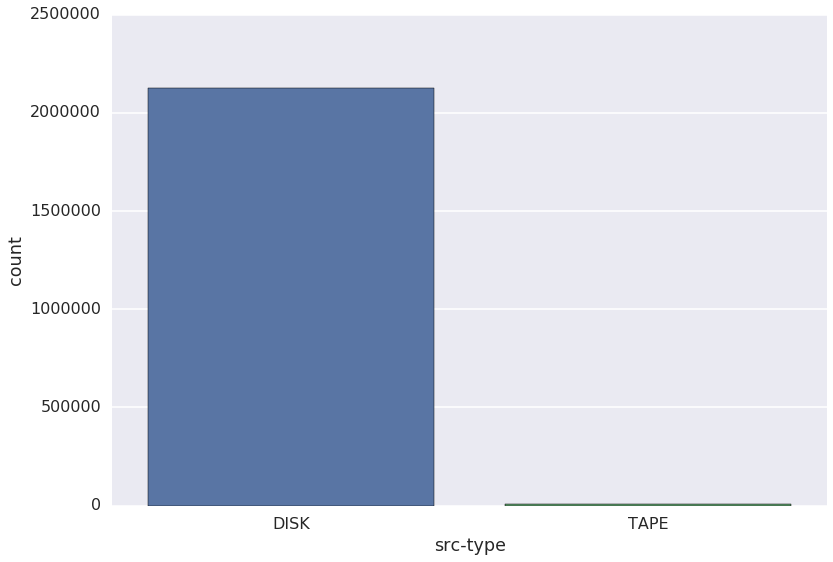

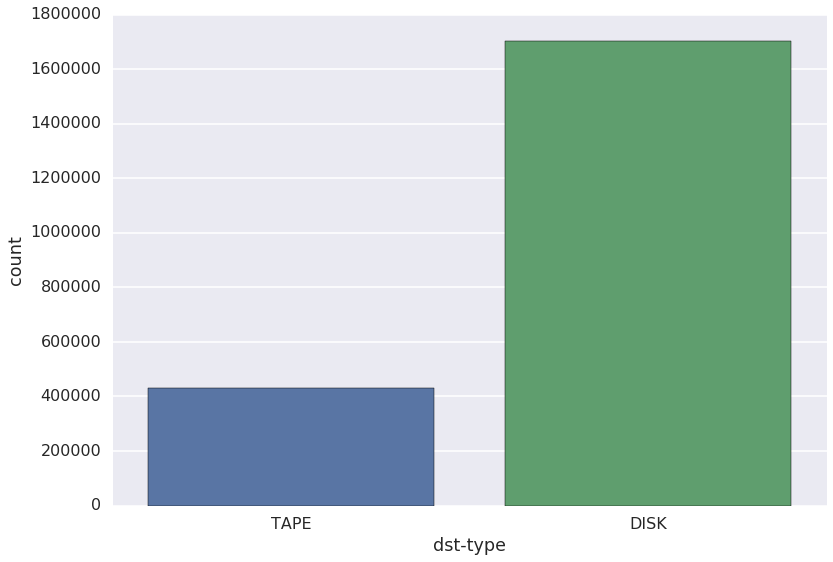

Saved atlas_rucio-events-2017.06.06 data to disk !!
total hits in atlas_rucio-events-2017.06.02 : 1983351
Scrolling index : atlas_rucio-events-2017.06.02 ; step : 0 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.02 ; step : 10 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.02 ; step : 20 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.02 ; step : 30 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.02 ; step : 40 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.02 ; step : 50 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.02 ; step : 60 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.02 ; step : 70 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.02 ; step : 80 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.02 ; step : 90 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.

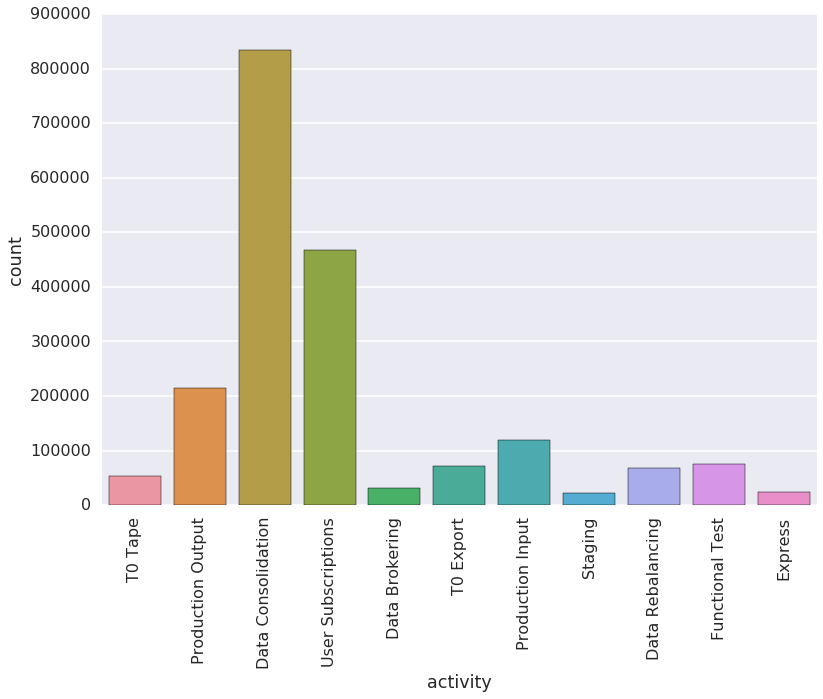

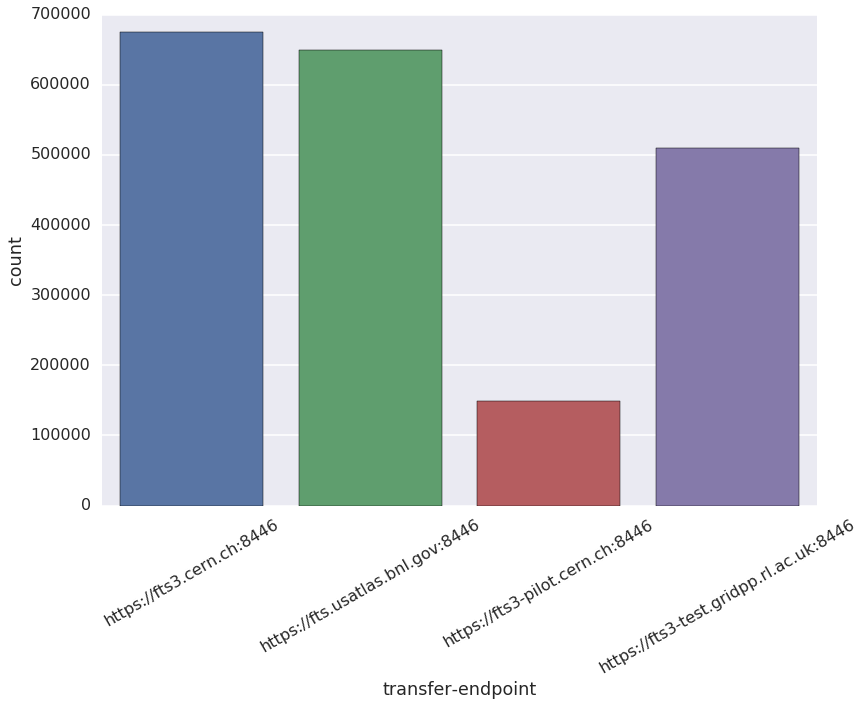

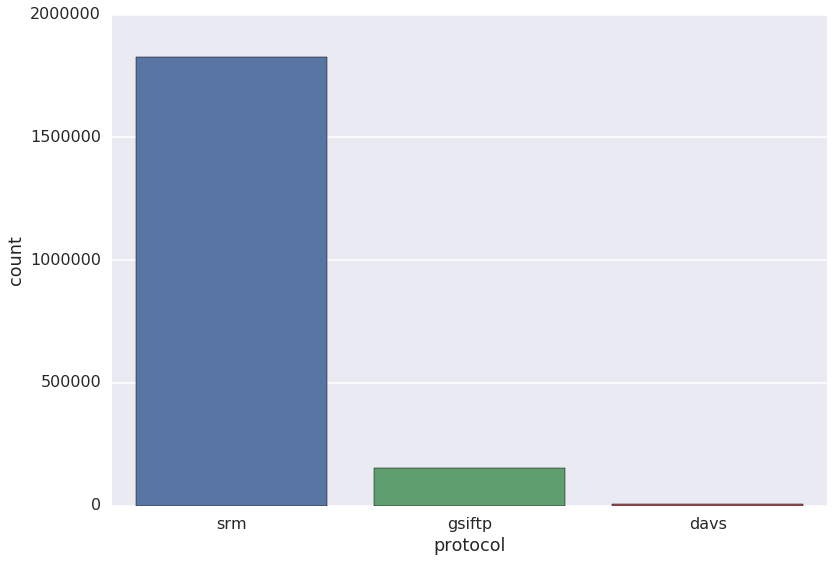

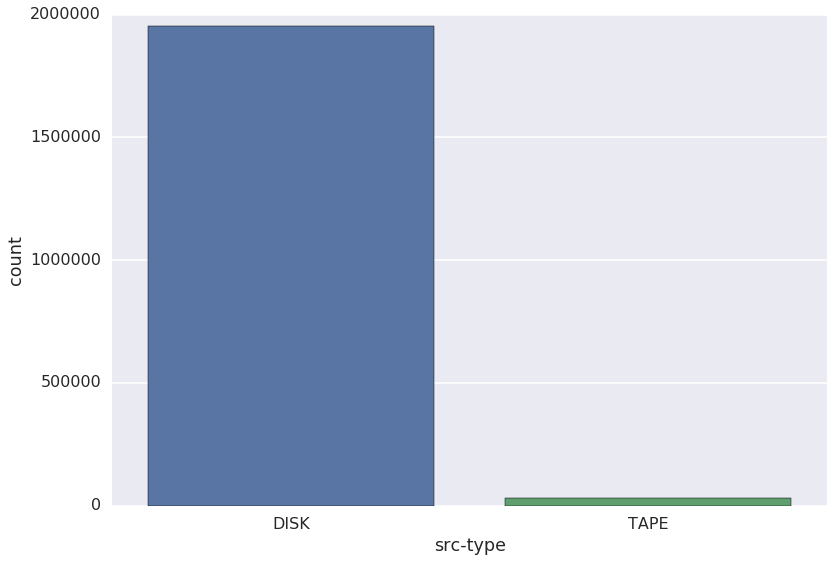

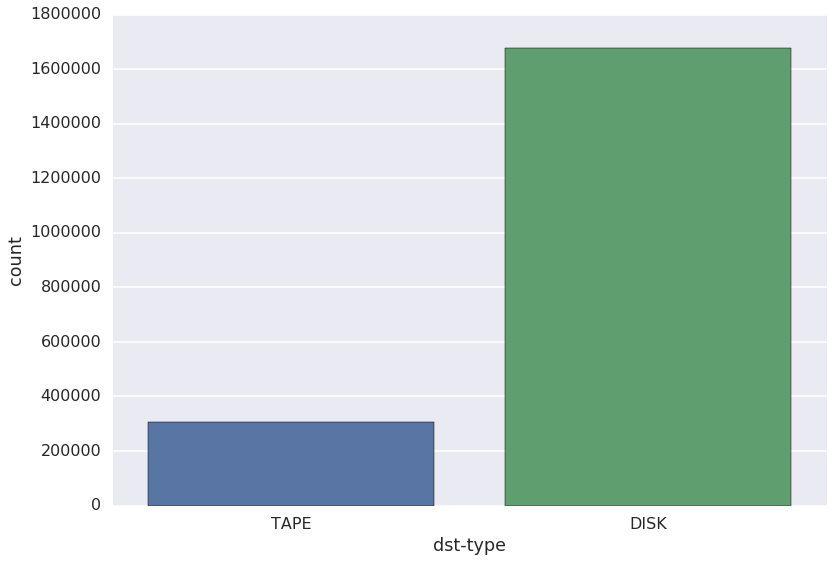

Saved atlas_rucio-events-2017.06.02 data to disk !!
total hits in atlas_rucio-events-2017.06.18 : 1626545
Scrolling index : atlas_rucio-events-2017.06.18 ; step : 0 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.18 ; step : 10 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.18 ; step : 20 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.18 ; step : 30 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.18 ; step : 40 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.18 ; step : 50 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.18 ; step : 60 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.18 ; step : 70 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.18 ; step : 80 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.18 ; step : 90 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.

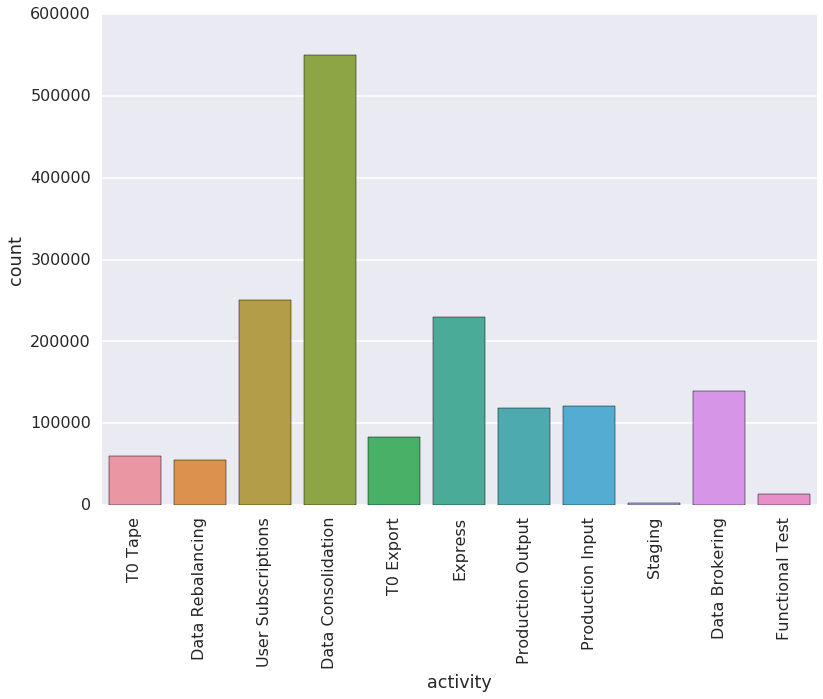

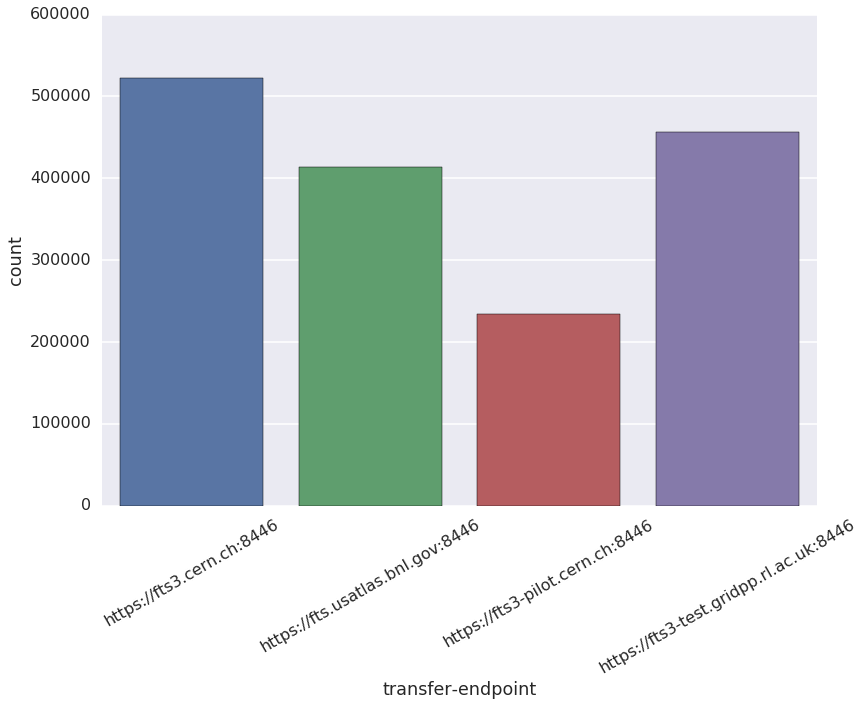

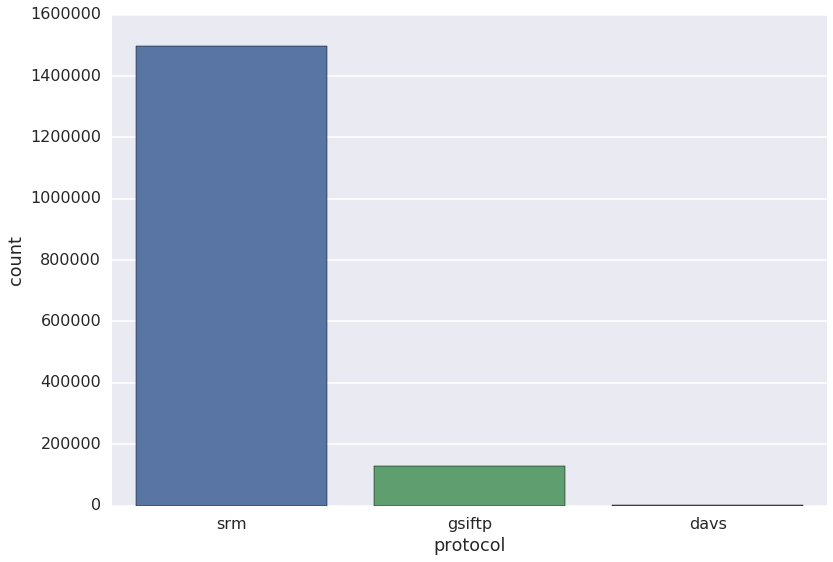

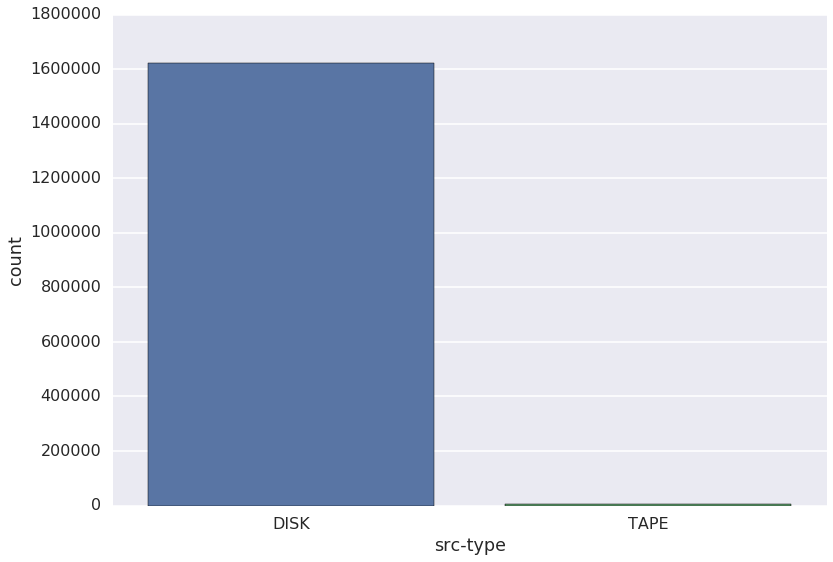

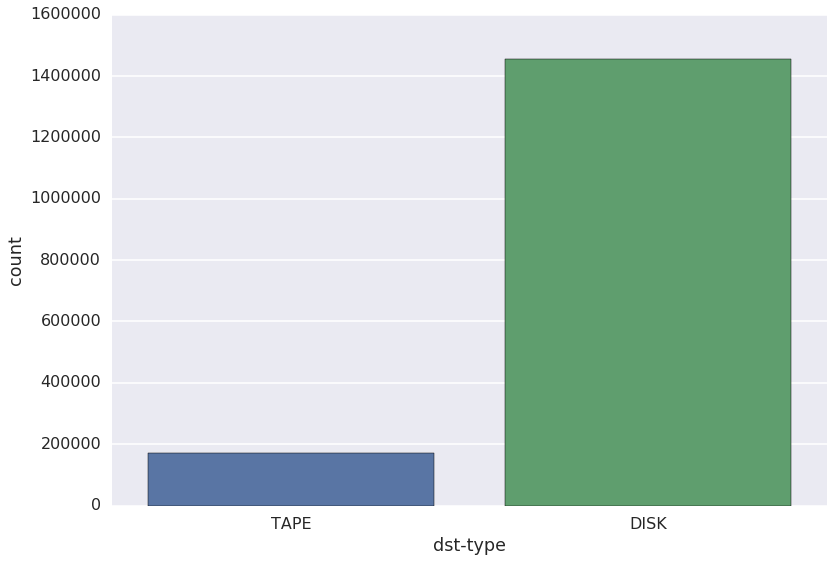

Saved atlas_rucio-events-2017.06.18 data to disk !!

------------------- ALL DONE !!!!! -----------------------


In [13]:
myquery = {
    "query": {
        "term": {
            '_type': 'transfer-done'
            }
        }
    }
l.remove('atlas_rucio-events-2017.06.03')
len(l)
df_june = get_indices_data(indices_list=l, query=myquery,
                           scan_step= 10000,
                           scan_size=None,
                           indices_dict=indices_to_count)

In [ ]:
# myquery={
#       'query': {
#         'bool': {
#           'must': {
#             'match': {'description': 'fix'}
#           },
#           'must_not': {
#             'term': {'files': 'test_elasticsearch'}
#           }
#         }
#       }
#     }

# # es.get_source(index='atlas_rucio-events-*', doc_type=, id= )     , filter_path='hits.hits._source'
# es.search(index='atlas_rucio-events-*', size=5)

In [69]:
dFF=extract_data(index='atlas_rucio-events-2017.06.08',query=myquery,scan_size=300000, scan_step=10000)

Scrolling index : atlas_rucio-events-2017.06.08 ; step : 0 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.08 ; step : 10 ...
 
scroll size: 10000
Scrolling index : atlas_rucio-events-2017.06.08 ; step : 20 ...
 
scroll size: 10000

 Done Scrolling through atlas_rucio-events-2017.06.08 !! 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 26 columns):
account                0 non-null object
activity               300000 non-null object
bytes                  300000 non-null int64
checksum-adler         300000 non-null object
checksum-md5           0 non-null object
dst-rse                300000 non-null object
dst-type               300000 non-null object
dst-url                300000 non-null object
duration               300000 non-null int64
guid                   0 non-null object
name                   300000 non-null object
previous-request-id    32780 non-null object
protocol               300000 non-null ob

In [71]:
a=dFF.groupby(df.columns.tolist(),as_index=False).size()
a.unique()

array([], dtype=int64)

In [48]:
index= 'atlas_rucio-events-2017.05.17'
myquery = {
    "query": {
        "term": {
            '_type': 'transfer-done'
            }
        }
    }

# # scan_size=indices_dict['atlas_rucio-events-2017.05.17'],
# #                     scan_step=10000

# data = extract_data(index=index,
#                     query=myquery,
#                     scan_size=100000,
#                     scan_step=1000)

In [54]:
rucio_data = df

In [52]:
z=(df['previous-request-id'][0]) 

In [60]:
# df.to_csv('may.csv')
# id = (df['previous-request-id']!=z)
# id
a=df['previous-request-id'].notnull()

In [62]:
b=df['previous-request-id'][a]
b

47        c48c643a28f3467390801546a39bc836
90        e26c9d992afc439587821ac6d98aad17
296       73c33434d3ce43018eb75906d86cc43a
312       0304ec1b2e9245edaf7e557b80fe2370
351       b235a6c772204d22b4980d639282b54d
356       8d83a76f954a4568813ea0698f3ca43e
734       d2305fb1893547759c9cb4afa844844e
1130      49ec8faf7eb940a69ea0fe314946d61e
1138      4e50b47b67b64debaf8c8d4d62cf1560
1588      db705903b9c74dfc80c41a75b6d75ae7
1652      ee465b085d36427bbf0ac1fbb0a2ac5a
1769      414aa872c8d54672854ac595e54bbabe
2324      76a7be1948514ad3957eae7f50a5ea38
2339      52baaaabfa604f0abd7717b5bb451f07
2765      14950165f19e445b87c59dc2bf72462f
2771      01a12ff105b549c6ae3aeb877651aebe
2867      43142a581ef247f1952746b9c1455ec3
2996      6a5d1232aba04d93b930579c2f1409b7
3182      113d51814b8a4514ac52879c1c7af4f1
3183      8693f725b9634e88901c5bc1a2c2b8a3
3186      36dc5a202ab845d2ba5d032d8d4bcdc0
3190      d6453b8460d54385b2bcc19e9ada9ae0
3200      8c92b7edf59e415bafb41673714c87a0
3215      8

In [13]:
# from elasticsearch_dsl import Search
# from elasticsearch_dsl.query import MultiMatch, Match

# s = Search(using=es, index='atlas_rucio-events-2017.05.17', size=indices_dict['atlas_rucio-events-2017.05.17'])

# response = s.execute()
# print('Total %d hits found.' % response.hits.total)

# # indices_dict['atlas_rucio-events-2017.05.17']
# # print((response))
# # response.to_dict()
# print(response.success())
# print(response.took)
# print(response.hits.total)
# print(len(response.hits.hits))
# response.hits.hits[0]

# Preprocessing data

In [36]:
rucio_data = pd.read_csv('may.csv')

In [37]:
rucio_data.head()


,Unnamed: 0,account,activity,bytes,checksum-adler,checksum-md5,dst-rse,dst-type,dst-url,duration,...,src-rse,src-type,src-url,started_at,submitted_at,tool-id,transfer-endpoint,transfer-id,transfer-link,transferred_at
0,0,NaN,Production Input,533918,aadc03c6,NaN,CERN-PROD_DATADISK,DISK,gsiftp://eosatlassftp.cern.ch:2811/eos/atlas/a...,10,...,TOKYO-LCG2_DATADISK,DISK,srm://lcg-se01.icepp.jp:8446/srm/managerv2?SFN...,2017-05-28 07:00:38,2017-05-28 06:45:22,rucio-conveyor,https://fts3.cern.ch:8446,c9f91f7b-f91b-5df5-ae11-e9dcd249c244,https://fts3.cern.ch:8449/fts3/ftsmon/#/job/c9...,2017-05-28 07:00:48
1,1,NaN,Production Input,591160,68fe0316,NaN,CERN-PROD_DATADISK,DISK,gsiftp://eosatlassftp.cern.ch:2811/eos/atlas/a...,9,...,TOKYO-LCG2_DATADISK,DISK,srm://lcg-se01.icepp.jp:8446/srm/managerv2?SFN...,2017-05-28 07:03:02,2017-05-28 06:56:11,rucio-conveyor,https://fts3.cern.ch:8446,ff43c9e0-9716-5176-9c1e-3f0990f87745,https://fts3.cern.ch:8449/fts3/ftsmon/#/job/ff...,2017-05-28 07:03:11
2,2,NaN,Production Input,512581,3deb51ec,NaN,CERN-PROD_DATADISK,DISK,gsiftp://eosatlassftp.cern.ch:2811/eos/atlas/a...,9,...,TOKYO-LCG2_DATADISK,DISK,srm://lcg-se01.icepp.jp:8446/srm/managerv2?SFN...,2017-05-28 06:58:12,2017-05-28 06:45:31,rucio-conveyor,https://fts3.cern.ch:8446,3d1d5437-700d-54a3-a0ba-46d0b3f11360,https://fts3.cern.ch:8449/fts3/ftsmon/#/job/3d...,2017-05-28 06:58:21
3,3,NaN,Production Input,478343,62736ced,NaN,CERN-PROD_DATADISK,DISK,gsiftp://eosatlassftp.cern.ch:2811/eos/atlas/a...,8,...,TOKYO-LCG2_DATADISK,DISK,srm://lcg-se01.icepp.jp:8446/srm/managerv2?SFN...,2017-05-28 07:02:51,2017-05-28 06:56:11,rucio-conveyor,https://fts3.cern.ch:8446,ff43c9e0-9716-5176-9c1e-3f0990f87745,https://fts3.cern.ch:8449/fts3/ftsmon/#/job/ff...,2017-05-28 07:02:59
4,4,NaN,Production Input,513541,965123c5,NaN,NET2_DATADISK,DISK,srm://atlas.bu.edu:8443/srm/v2/server?SFN=/gpf...,3,...,CERN-PROD_DATADISK,DISK,gsiftp://eosatlassftp.cern.ch:2811/eos/atlas/a...,2017-05-28 07:02:10,2017-05-28 06:56:06,rucio-conveyor,https://fts.usatlas.bnl.gov:8446,853cf990-478d-58b6-8669-d8a3396efd11,https://fts.usatlas.bnl.gov:8449/fts3/ftsmon/#...,2017-05-28 07:02:13


In [38]:
rucio_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540000 entries, 0 to 539999
Data columns (total 27 columns):
Unnamed: 0             540000 non-null int64
account                0 non-null float64
activity               540000 non-null object
bytes                  540000 non-null int64
checksum-adler         540000 non-null object
checksum-md5           0 non-null float64
dst-rse                540000 non-null object
dst-type               540000 non-null object
dst-url                540000 non-null object
duration               540000 non-null int64
guid                   0 non-null float64
name                   540000 non-null object
previous-request-id    9770 non-null object
protocol               540000 non-null object
reason                 0 non-null float64
request-id             540000 non-null object
scope                  540000 non-null object
src-rse                540000 non-null object
src-type               540000 non-null object
src-url                540000 non-nu

In [39]:
duplicates = rucio_data.groupby(rucio_data.columns.tolist(),as_index=False).size()
duplicates

Series([], dtype: int64)

In [56]:
names = (rucio_data['name'].unique())
print(names[0:5])
len(names)

['HITS.11404688._056591.pool.root.1' 'HITS.11404674._069995.pool.root.1'
 'HITS.11404688._056559.pool.root.1' 'HITS.11404674._070002.pool.root.1'
 'HITS.11404651._074986.pool.root.1']


503379

In [57]:
s_urls = rucio_data['src-url'].unique()
print(s_urls, '\n', len(s_urls))

[ 'srm://lcg-se01.icepp.jp:8446/srm/managerv2?SFN=/dpm/icepp.jp/home/atlas/atlasdatadisk/rucio/mc15_14TeV/6a/48/HITS.11404688._056591.pool.root.1'
 'srm://lcg-se01.icepp.jp:8446/srm/managerv2?SFN=/dpm/icepp.jp/home/atlas/atlasdatadisk/rucio/mc15_14TeV/9c/d6/HITS.11404674._069995.pool.root.1'
 'srm://lcg-se01.icepp.jp:8446/srm/managerv2?SFN=/dpm/icepp.jp/home/atlas/atlasdatadisk/rucio/mc15_14TeV/5a/a8/HITS.11404688._056559.pool.root.1'
 ...,
 'srm://f-dpm001.grid.sinica.edu.tw:8446/srm/managerv2?SFN=/dpm/grid.sinica.edu.tw/home/atlas/atlasdatadisk/rucio/mc15_13TeV/77/e1/EVNT.11330811._027544.pool.root.1'
 'gsiftp://eosatlassftp.cern.ch:2811/eos/atlas/atlastier0/rucio/data17_13TeV/physics_CosmicCalo/00324857/data17_13TeV.00324857.physics_CosmicCalo.merge.RAW/data17_13TeV.00324857.physics_CosmicCalo.merge.RAW._lb0352._SFO-4._0001.1'
 'srm://f-dpm001.grid.sinica.edu.tw:8446/srm/managerv2?SFN=/dpm/grid.sinica.edu.tw/home/atlas/atlasdatadisk/rucio/mc15_13TeV/44/d7/EVNT.11330811._029359.pool.

In [58]:
d_urls = rucio_data['dst-url'].unique()
print(d_urls, '\n', len(d_urls))

[ 'gsiftp://eosatlassftp.cern.ch:2811/eos/atlas/atlasdatadisk/rucio/mc15_14TeV/6a/48/HITS.11404688._056591.pool.root.1'
 'gsiftp://eosatlassftp.cern.ch:2811/eos/atlas/atlasdatadisk/rucio/mc15_14TeV/9c/d6/HITS.11404674._069995.pool.root.1'
 'gsiftp://eosatlassftp.cern.ch:2811/eos/atlas/atlasdatadisk/rucio/mc15_14TeV/5a/a8/HITS.11404688._056559.pool.root.1'
 ...,
 'srm://srmatlas.pic.es:8443/srm/managerv2?SFN=/pnfs/pic.es/data/atlas/atlasdatadisk/rucio/mc15_13TeV/77/e1/EVNT.11330811._027544.pool.root.1'
 'srm://dcsrm.usatlas.bnl.gov:8443/srm/managerv2?SFN=/pnfs/usatlas.bnl.gov/BNLT1D0/data17_13TeV/RAW/other/data17_13TeV.00324857.physics_CosmicCalo.merge.RAW/data17_13TeV.00324857.physics_CosmicCalo.merge.RAW._lb0352._SFO-4._0001.1'
 'srm://srmatlas.pic.es:8443/srm/managerv2?SFN=/pnfs/pic.es/data/atlas/atlasdatadisk/rucio/mc15_13TeV/44/d7/EVNT.11330811._029359.pool.root.1'] 
 539827


In [40]:
# reasons = rucio_data['reason'].unique()
# print(reasons,'\n',len(reasons))

rucio_data['reason']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
6        NaN
7        NaN
8        NaN
9        NaN
10       NaN
11       NaN
12       NaN
13       NaN
14       NaN
15       NaN
16       NaN
17       NaN
18       NaN
19       NaN
20       NaN
21       NaN
22       NaN
23       NaN
24       NaN
25       NaN
26       NaN
27       NaN
28       NaN
29       NaN
          ..
539970   NaN
539971   NaN
539972   NaN
539973   NaN
539974   NaN
539975   NaN
539976   NaN
539977   NaN
539978   NaN
539979   NaN
539980   NaN
539981   NaN
539982   NaN
539983   NaN
539984   NaN
539985   NaN
539986   NaN
539987   NaN
539988   NaN
539989   NaN
539990   NaN
539991   NaN
539992   NaN
539993   NaN
539994   NaN
539995   NaN
539996   NaN
539997   NaN
539998   NaN
539999   NaN
Name: reason, dtype: float64

In [41]:
src = rucio_data['src-rse'].unique()
print(src,'\n',len(src))

['TOKYO-LCG2_DATADISK' 'CERN-PROD_DATADISK' 'INFN-T1_DATADISK'
 'IFIC-LCG2_DATADISK' 'MWT2_DATADISK' 'PIC_DATADISK' 'SWT2_CPB_DATADISK'
 'CERN-PROD_TZDISK' 'IN2P3-CC_DATADISK' 'BNL-OSG2_DATADISK'
 'NET2_SCRATCHDISK' 'LRZ-LMU_SCRATCHDISK' 'CERN-PROD_SCRATCHDISK'
 'IFIC-LCG2_SCRATCHDISK' 'UKI-SOUTHGRID-BHAM-HEP_SCRATCHDISK'
 'NDGF-T1_DATADISK' 'FZK-LCG2_DATADISK' 'NIKHEF-ELPROD_DATADISK'
 'UTA_SWT2_DATADISK' 'DESY-HH_DATADISK' 'CA-VICTORIA-WESTGRID-T2_DATADISK'
 'GRIF-IRFU_DATADISK' 'SARA-MATRIX_DATADISK' 'RRC-KI-T1_DATADISK'
 'BNL-OSG2_DATATAPE' 'NDGF-T1_SCRATCHDISK' 'MWT2_UC_SCRATCHDISK'
 'BNL-OSG2_SCRATCHDISK' 'INFN-FRASCATI_DATADISK' 'NET2_DATADISK'
 'UKI-LT2-QMUL_SCRATCHDISK' 'AGLT2_DATADISK' 'SLACXRD_DATADISK'
 'UKI-NORTHGRID-MAN-HEP_DATADISK' 'UNI-FREIBURG_SCRATCHDISK'
 'UKI-SCOTGRID-DURHAM_DATADISK' 'RO-07-NIPNE_DATADISK' 'GRIF-LAL_DATADISK'
 'CSCS-LCG2_DATADISK' 'UKI-SOUTHGRID-SUSX_DATADISK'
 'AUSTRALIA-ATLAS_DATADISK' 'TAIWAN-LCG2_DATADISK' 'TRIUMF-LCG2_DATADISK'
 'RU-PROTVINO-

In [42]:
dest = rucio_data['dst-rse'].unique()
print(dest,'\n',len(dest))

['CERN-PROD_DATADISK' 'NET2_DATADISK' 'CA-VICTORIA-WESTGRID-T2_DATADISK'
 'RRC-KI-T1_DATADISK' 'MWT2_DATADISK' 'UTA_SWT2_DATADISK'
 'TRIUMF-LCG2_DATADISK' 'CA-SCINET-T2_DATADISK' 'IN2P3-CC_DATATAPE'
 'INFN-T1_DATATAPE' 'TOKYO-LCG2_DATADISK' 'IN2P3-CC_DATADISK'
 'IFIC-LCG2_DATADISK' 'IN2P3-CC_SCRATCHDISK' 'TOKYO-LCG2_SCRATCHDISK'
 'FZK-LCG2_SCRATCHDISK' 'CERN-PROD_SCRATCHDISK' 'UKI-LT2-QMUL_SCRATCHDISK'
 'CA-MCGILL-CLUMEQ-T2_DATADISK' 'BNL-OSG2_DATADISK' 'BNL-OSG2_DATATAPE'
 'UKI-NORTHGRID-LANCS-HEP_DATADISK' 'GRIF-LPNHE_DATADISK'
 'FMPHI-UNIBA_DATADISK' 'BNL-OSG2_LOCALGROUPDISK' 'SWT2_CPB_DATADISK'
 'NIKHEF-ELPROD_DATADISK' 'UKI-SCOTGRID-GLASGOW_DATADISK'
 'SARA-MATRIX_DATADISK' 'NET2_SCRATCHDISK' 'UKI-LT2-IC-HEP_DATADISK'
 'UKI-SOUTHGRID-RALPP_DATADISK' 'RRC-KI-T1_SCRATCHDISK' 'INFN-T1_DATADISK'
 'PIC_SCRATCHDISK' 'UKI-LT2-RHUL_DATADISK' 'NDGF-T1_DATADISK'
 'UKI-SCOTGRID-DURHAM_DATADISK' 'IFAE_SCRATCHDISK' 'INFN-FRASCATI_DATADISK'
 'UKI-SOUTHGRID-OX-HEP_DATADISK' 'SLACXRD_DATADISK' 'F

In [43]:
scopes = rucio_data['scope'].unique()
print(scopes, '\n', len(scopes))

['mc15_14TeV' 'mc16_13TeV' 'mc15_13TeV' 'data17_13TeV' 'group.phys-sm'
 'user.fatsai' 'user.dkoeck' 'user.cgeng' 'user.mmarjano' 'data16_13TeV'
 'mc12_8TeV' 'user.ddmadmin' 'data15_5TeV' 'user.shion' 'group.det-indet'
 'user.cfischer' 'user.ohaldik' 'mc15_valid' 'user.deroy' 'user.jroloff'
 'user.sdjones' 'valid1' 'user.jcantero' 'group.phys-higgs' 'user.amelzer'
 'user.rasmith' 'data15_13TeV' 'user.tholm' 'user.tcuhadar' 'user.tpelzer'
 'user.hson' 'mc16_valid' 'user.maklein' 'user.aloesle' 'user.lixia'
 'user.egozani' 'user.cvarni' 'user.dengfeng' 'user.shelena' 'user.oducu'
 'user.crizzi' 'user.mvanadia' 'user.dkrauss' 'user.dbogavac' 'user.ruyuan'
 'user.lcorpe' 'user.btong' 'user.ppodbere' 'user.tripiana' 'user.vaustrup'
 'group.phys-gener' 'user.ggustavi' 'user.mrybar' 'user.jlindon'
 'user.wbalunas' 'user.relkosse' 'user.korona' 'user.fawilk' 'data17_calib'
 'user.abetti' 'user.zmeadows' 'user.tkunigo' 'user.rles' 'data11_hi'
 'data17_comm' 'user.moles' 'user.paramon' 'user.mkol

In [44]:
adlers = rucio_data['checksum-adler'].unique()
len(adlers)

502728

In [45]:
tool_ids = rucio_data['tool-id'].unique()
tool_ids

array(['rucio-conveyor'], dtype=object)

In [46]:
transfer_links = rucio_data['transfer-link'].unique()
print(transfer_links, len(transfer_links)) 

[ 'https://fts3.cern.ch:8449/fts3/ftsmon/#/job/c9f91f7b-f91b-5df5-ae11-e9dcd249c244'
 'https://fts3.cern.ch:8449/fts3/ftsmon/#/job/ff43c9e0-9716-5176-9c1e-3f0990f87745'
 'https://fts3.cern.ch:8449/fts3/ftsmon/#/job/3d1d5437-700d-54a3-a0ba-46d0b3f11360'
 ...,
 'https://fts3.cern.ch:8449/fts3/ftsmon/#/job/e5141d92-c5da-5ce2-918a-e69ab89ced80'
 'https://fts3.cern.ch:8449/fts3/ftsmon/#/job/70736bf5-7d35-5ffe-ac1d-b15b7ba75603'
 'https://fts3.cern.ch:8449/fts3/ftsmon/#/job/377882a9-97f2-5dd3-bc39-848a2e1261a3'] 359192


In [47]:
t_end = rucio_data['transfer-endpoint'].unique()
t_end

array(['https://fts3.cern.ch:8446', 'https://fts.usatlas.bnl.gov:8446',
       'https://fts3-test.gridpp.rl.ac.uk:8446',
       'https://fts3-pilot.cern.ch:8446'], dtype=object)

In [48]:
activities = rucio_data['activity'].unique()
activities

array(['Production Input', 'T0 Export', 'Production Output',
       'User Subscriptions', 'Data Rebalancing', 'Data Consolidation',
       'Functional Test', 'Data Brokering', 'T0 Tape', 'Express',
       'Staging', 'Recovery'], dtype=object)

In [49]:
# rucio_data['reason']
protocols = rucio_data['protocol'].unique()
protocols


array(['gsiftp', 'srm', 'davs'], dtype=object)

In [50]:
dst_types = rucio_data['dst-type'].unique()
dst_types

array(['DISK', 'TAPE'], dtype=object)

In [51]:
src_types = rucio_data['src-type'].unique()
src_types

array(['DISK', 'TAPE'], dtype=object)

# Preprocessing


In [30]:
rucio_data = pd.read_csv('may.csv')

In [25]:
rucio_data.columns

Index(['Unnamed: 0', 'account', 'activity', 'bytes', 'checksum-adler',
       'checksum-md5', 'dst-rse', 'dst-type', 'dst-url', 'duration', 'guid',
       'name', 'previous-request-id', 'protocol', 'reason', 'request-id',
       'scope', 'src-rse', 'src-type', 'src-url', 'started_at', 'submitted_at',
       'tool-id', 'transfer-endpoint', 'transfer-id', 'transfer-link',
       'transferred_at'],
      dtype='object')

In [26]:
from sklearn.preprocessing import LabelEncoder
from datetime import datetime,timedelta
# hdf = pd.HDFStore('datastore.h5')

In [31]:
rucio_data=preprocess_data(rucio_data)

In [32]:
rucio_data.head(1000)

,activity,bytes,dst-rse,dst-type,duration,protocol,scope,src-rse,src-type,transfer-endpoint,delay
387177,11,205156,14,0,0,2,86,13,0,0,275421.0
246435,11,16625,14,0,0,2,44,13,0,0,366459.0
225756,11,11036182,14,0,1,2,44,13,0,0,443889.0
223784,11,134583,14,0,1,2,86,13,0,0,444507.0
227134,11,16633,14,0,0,2,44,13,0,0,445807.0
227132,11,16637,14,0,0,2,44,13,0,0,445193.0
232050,11,8799,14,0,0,2,86,13,0,0,444883.0
223817,11,7868,13,0,1,2,86,14,0,0,342886.0
233089,11,8292,13,0,0,2,86,14,0,0,344119.0
215765,11,198202,13,0,0,2,177,14,0,0,348363.0


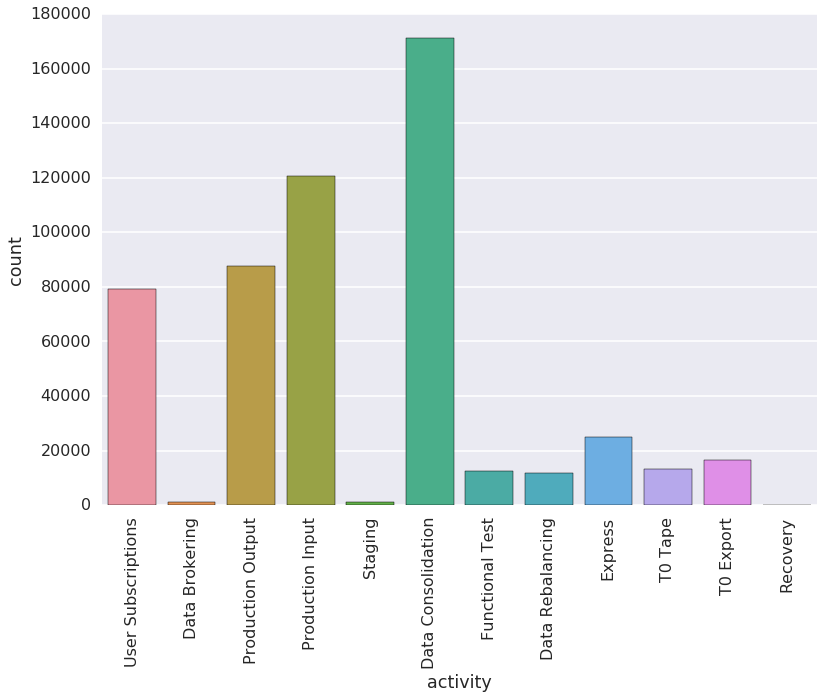

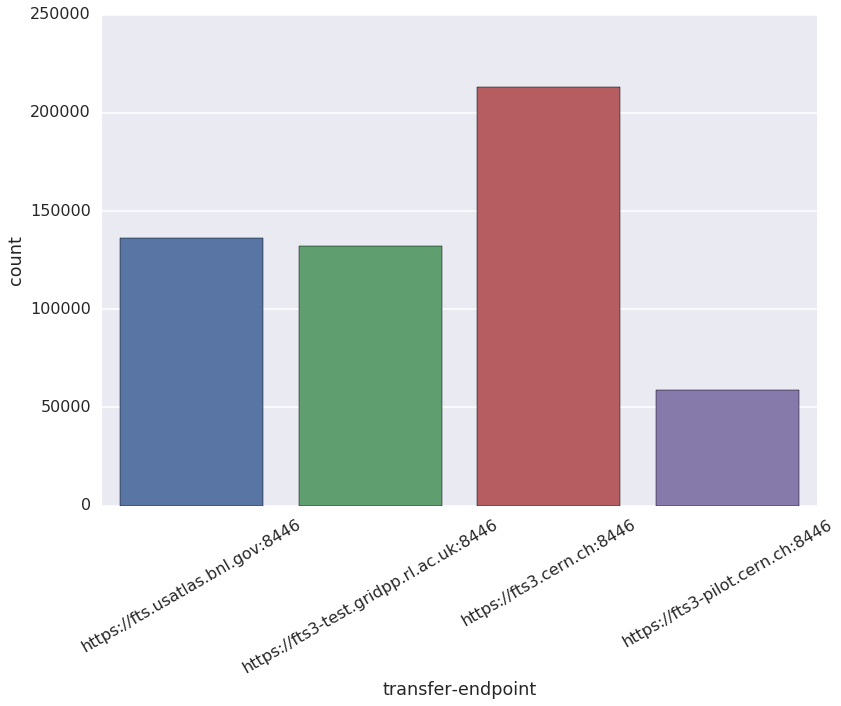

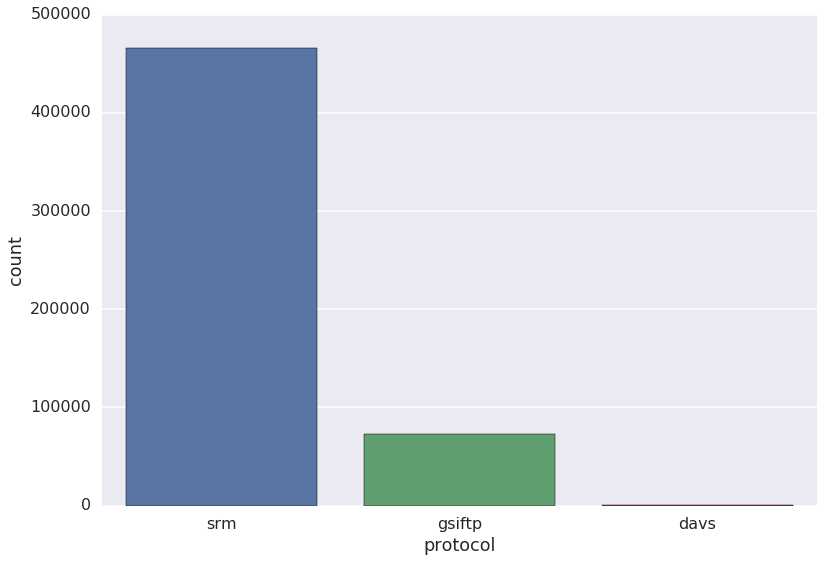

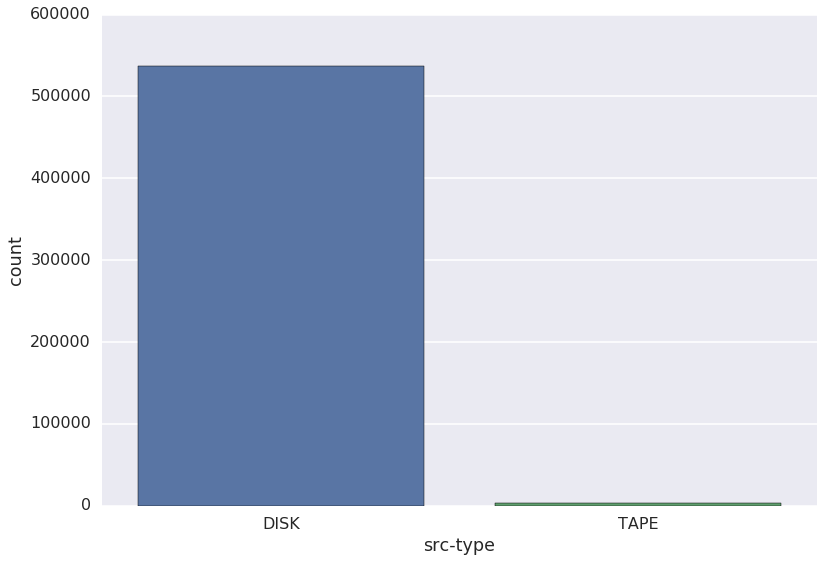

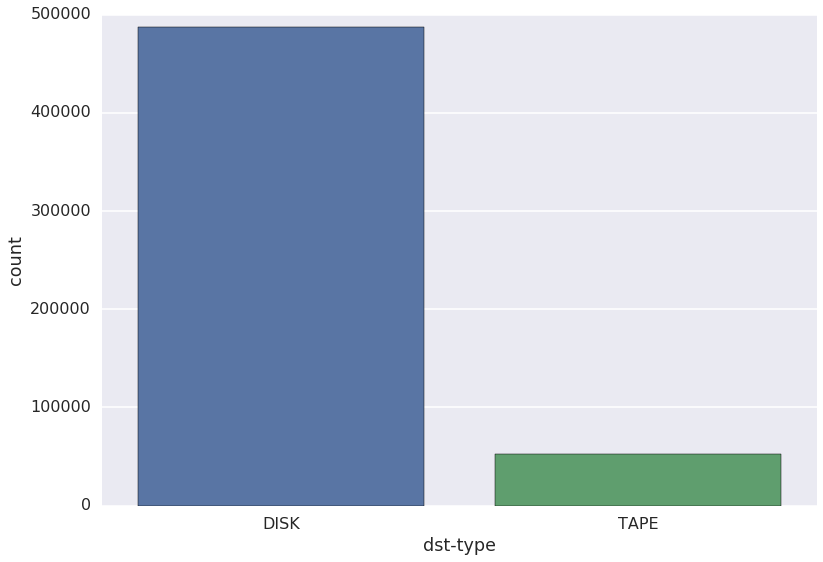

In [23]:
plot_data_stats(rucio_data)

In [97]:
rucio_data.head(30)

,activity,bytes,dst-rse,dst-type,duration,protocol,scope,src-rse,src-type,transfer-endpoint,delay
0,5,533918,23,0,10,1,36,180,0,3,916.0
1,5,591160,23,0,9,1,36,180,0,3,411.0
2,5,512581,23,0,9,1,36,180,0,3,761.0
3,5,478343,23,0,8,1,36,180,0,3,400.0
4,5,513541,142,0,3,2,36,23,0,0,364.0
5,5,540985,23,0,9,1,36,180,0,3,969.0
6,5,458226,21,0,4,2,36,105,0,0,197.0
7,5,531690,142,0,8,2,36,67,0,0,343.0
8,5,527060,23,0,9,1,36,180,0,3,118.0
9,5,478330207,169,0,27,2,42,122,0,0,6318.0


# Basic HDF5 Datastore for storing extracted-preprocessed data

In [96]:
hdf = pd.HDFStore('datastore.h5')
print(hdf)

<class 'pandas.io.pytables.HDFStore'>
File path: datastore.h5
Empty


In [98]:
hdf.put('may/t1', rucio_data, format='table', data_columns=True)
rucio_data.to_csv('may_preprocessed.csv')

/eos/user/v/vysharma/.local/lib/python3.5/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: 'dst-rse'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/eos/user/v/vysharma/.local/lib/python3.5/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: 'dst-type'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/eos/user/v/vysharma/.local/lib/python3.5/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: 'src-rse'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still

In [99]:
print(hdf)

<class 'pandas.io.pytables.HDFStore'>
File path: datastore.h5
/may/t1            frame_table  (typ->appendable,nrows->540000,ncols->11,indexers->[index],dc->[activity,bytes,dst-rse,dst-type,duration,protocol,scope,src-rse,src-type,transfer-endpoint,delay])


In [ ]:
df = pd.read_hdf5